# <font size=5, color = 'black'> Notes </font>

Author: Huan Q. Bui

Affiliation: Fermi1 experiment at Zlabs, MIT
             
PI: Professor Martin Zwierlein

First updated: May 15, 2023

Last updated: July 18, 2023

Description:
- A place to learn how to use QuTip
- A notebook for calculating quantumy stuff using (mostly) QuTip
- Focusing on less "conventional" systems that examples in class
- A visual aid for studying AMO physics
- A place to test code before adding to Fermi1_Calculator notebook

To do:
- Two-level system: single-photon damped Rabi oscillation
- EIT
- STIRAP (with loss, with continuum participation, with Krotov for optimizing pulse shapes, reproduce Yiqi's code, etc.)
- Atom-photon interaction in a cavity
- Statistics of quantum vs classical light?
- NaK calculations: 
    - calculate rotational and hyperfine structure of NaK

# <font size=5, color='black'> Setting up </font>

In [1093]:
# imports
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import os
import scipy
import pandas as pd
from qutip import *
import time
from findiff import FinDiff
from numba import jit
# for diatomic hyperfine + rotational stuff
from sympy.physics.wigner import wigner_3j
from scipy.linalg import block_diag
import scipy.constants
from scipy.special import sph_harm
from matplotlib import pyplot,gridspec,colors,patches,collections

In [2]:
# suppress warnings: do at your own risk!
import warnings
warnings.filterwarnings("ignore")

In [1075]:
# constants
ABSORPTION_LIMIT = 5.0
SPECIAL_CHARACTERS = "!@#$%^&*()-+?_=,<>/"

# physics constants
hbar = 1.05457182*10**(-34) # Js
h_planck = hbar*2*np.pi  # Js
me = 9.1093837015e-31    # electron mass
mn = 1.67493e-27         # neutron mass
eC = 1.60218e-19         # electric charge
muB = eC*hbar/(2*me)     # Bohr magneton
a0 = 5.2917720859e-11    # Bohr radius
muN = scipy.constants.physical_constants['nuclear magneton'][0]
eps0 = scipy.constants.epsilon_0
DebyeSI = 3.33564e-30

# Lithium constants
mLi6 = 9.9883414*10**(-27) # kg
Li6D2Gamma = 5.8724e6 # Hz Note that this is NOT angular freq
Li6D2lambda0 = 670.977338*10**(-9) # meters
Li6D2sigma0 = 3*(Li6D2lambda0)**2/(2*np.pi)
Li6Ahf_s12 = 152.1368407e6  # This is NOT angular freq
Li6Bhf_s12 = 0
Li6Ahf_p12 = 17.386e6 # Hz
Li6Bhf_p12 = 0
Li6Ahf_p32 = -1.155e6 # Hz
Li6Bhf_p32 = -0.10e6 # Hz
Li6I = 1
Li6gI = -0.0004476540

# Sodium-23 constants
mNa23 = 0.38175403519e-25 # kg
Na23D2Gamma = 9.794646e6 # Hz
Na23D2lambda0 = 589.158326415e-9 # meters
Na23D2sigma0 = 3*(Na23D2lambda0)**2/(2*np.pi)
Na23Ahf_s12 = 885.8130644050e6 # Hz
Na23Bhf_s12 = 0e6 # Hz
Na23Ahf_p12 = 94.4413e6 # Hz
Na23Bhf_p12 = 0e6 # Hz
Na23Ahf_p32 = 18.53415e6 # Hz
Na23Bhf_p32 = 2.72430e6 # Hz
Na23I = 3/2
Na23gI = -0.0008046108080

# Potassium-40 constants
mK40 = 39.9639984821*1.6605402e-27 # kg 
K40D2Gamma = 6.03511 # MHz
K40D2lambda0 = 766.700674872173e-9 # meters
K40D2sigma0 = 3*(K40D2lambda0)**2/(2*np.pi)
K40Ahf_s12 = -285.730824e6 # Hz
K40Bhf_s12 = 0
K40Ahf_p12 = -34.52325e6 # Hz
K40Bhf_p12 = 0
K40Ahf_p32 = -7.58510e6 # Hz
K40Bhf_p32 = -3.44590e6 # Hz
K40I = 4
K40gI = 0.00017649034

# NaK constants:
mK41 = 6.80187059497004e-26 # kg
mK40 = 6.63617749148248e-26 # kg
mK39 = 6.47007514485677e-26 # kg
u = 1.660538782e-27  # kg
Eh = 4.35974394e-18 
c = 299792458
RKRcst = hbar/np.sqrt(2*u) * (10**10) * np.sqrt(1/(100 * c * hbar * 2*np.pi)) 
muNa39K = (mNa23 * mK39)/(mNa23 + mK39) * 1/u # atomic units
muNa40K = (mNa23 * mK40)/(mNa23 + mK40) * 1/u # atomic units 
muNa41K = (mNa23 * mK41)/(mNa23 + mK41) * 1/u # atomic units

In [2361]:
# NaK39 molecular constants, to be rescaled to NaK40 via RKR
DeX = 5273.6205    # minimum of the X1S+ GS, according to Tiemann

# B1Pi potential
# data source: http://dx.doi.org/10.1063/1.460157
TeB1Pi = 16992.7446
v_max_B1Pi = 43
# 23Na39K Dunham coefficients:
Y_Na39K_B1Pi = np.zeros((10,3))
Y_Na39K_B1Pi[0][0] = -0.0430
Y_Na39K_B1Pi[1][0] = 71.4630
Y_Na39K_B1Pi[2][0] = -1.15092
Y_Na39K_B1Pi[3][0] = -1.0613e-2
Y_Na39K_B1Pi[4][0] = 9.9950e-4
Y_Na39K_B1Pi[5][0] = -1.42656e-5
Y_Na39K_B1Pi[6][0] = -8.67783e-7
Y_Na39K_B1Pi[7][0] = 4.74996e-8
Y_Na39K_B1Pi[8][0] = -9.30786e-10
Y_Na39K_B1Pi[9][0] = 6.67343e-12
Y_Na39K_B1Pi[0][1] = 7.23853e-2
Y_Na39K_B1Pi[1][1] = -1.17799e-3
Y_Na39K_B1Pi[2][1] = -1.3502e-5
Y_Na39K_B1Pi[3][1] = -4.7933e-7
Y_Na39K_B1Pi[4][1] = 4.82977e-8
Y_Na39K_B1Pi[5][1] = -6.88606e-10
Y_Na39K_B1Pi[6][1] = -1.13984e-11
Y_Na39K_B1Pi[7][1] = 2.09534e-13
Y_Na39K_B1Pi[0][2] = -2.89859e-7
Y_Na39K_B1Pi[1][2] = -1.93901e-8
Y_Na39K_B1Pi[2][2] = 6.45399e-10
Y_Na39K_B1Pi[3][2] = -7.75355e-12
Y_Na39K_B1Pi[4][2] = 9.91847e-13
Y_Na39K_B1Pi[5][2] = -3.46351e-14

# c3SigmaPlus potential
# data source: http://dx.doi.org/10.1063/1.460157 Table IV.
Te_c3SigmaPlus = 15750.64
v_max_c3SigmaPlus = 36 # see paper 
Y_Na39K_c3SigmaPlus = np.zeros((4,4))
Y_Na39K_c3SigmaPlus[1][0] = 73.4
Y_Na39K_c3SigmaPlus[2][0] = -0.480173
Y_Na39K_c3SigmaPlus[3][0] = -9.82485e-4
Y_Na39K_c3SigmaPlus[0][1] = 0.06275
Y_Na39K_c3SigmaPlus[1][1] = -5.91425e-4
Y_Na39K_c3SigmaPlus[2][1] = -1.81058e-6
Y_Na39K_c3SigmaPlus[0][2] = 1.83e-7
Y_Na39K_c3SigmaPlus[1][2] = 3.45e-9
Y_Na39K_c3SigmaPlus[2][2] = -2.17e-11
r_Ferber = np.array([3.3602, 3.3683, 3.3763, 3.3845, 3.3928, 3.4013, 3.4100, 3.4188, 3.4280, 3.4374, 3.4471, 3.4571, 3.4675, 3.4783, 3.4895, 3.5012, 3.5135, 3.5263, 3.5397, 
                  3.5538, 3.5687, 3.5844, 3.6011, 3.6187, 3.6375, 3.6576, 3.6792, 3.7025, 3.7279, 3.7556, 3.7862, 3.8204, 3.8593, 3.9047, 3.9596, 4.0309, 4.1422, 
                  4.4997, 4.6535, 4.7679, 4.8666, 4.9564, 5.0405, 5.1206, 5.1978, 5.2729, 5.3464, 5.4188, 5.4903, 5.5611, 5.6317, 5.7020, 5.7723, 5.8427, 5.9133, 5.9843,
                  6.0558, 6.1278, 6.2006, 6.2741, 6.3485, 6.4240, 6.5006, 6.5783, 6.6574, 6.7380, 6.8201, 6.9040, 6.9897, 7.0773, 7.1672, 7.2593, 7.3540, 7.4514])
U_Ferber = np.array([1991.62, 1956.61, 1920.44, 1883.09, 1844.60, 1804.95, 1764.15, 1722.21, 1679.14, 1634.94, 1589.62, 1543.18, 1495.63, 1446.98, 1397.23, 1346.38, 
                        1294.45, 1241.44, 1187.35, 1132.19, 1075.97, 1018.69, 960.35, 900.98, 840.56, 779.11, 716.63, 653.13, 588.61, 523.08, 456.55, 389.02, 320.49, 250.98, 
                        180.49, 109.02, 36.59, 36.59,  109.02,  180.49,  250.98,  320.49,  389.02,  456.55, 523.08,  588.61,  653.13,  716.63,  779.11,  840.56,  900.98,
                        960.35, 1018.69, 1075.97, 1132.19, 1187.35, 1241.44, 1294.45, 1346.38, 1397.23, 1446.98, 1495.63, 1543.18, 1589.62, 1634.94, 1679.14, 1722.21, 
                        1764.15, 1804.95, 1844.6 , 1883.09, 1920.44, 1956.61, 1991.62])

# b3Pi potential
# data source: https://doi.org/10.1063/1.481149
Te_b3Pi = 11562.18
v_max_b3Pi = 63
Y_Na39K_b3Pi = np.zeros((8,3))
Y_Na39K_b3Pi[1][0] = 120.371380
Y_Na39K_b3Pi[2][0] = -0.332024
Y_Na39K_b3Pi[3][0] = -0.104098e-2
Y_Na39K_b3Pi[4][0] = 0.386127e-4
Y_Na39K_b3Pi[5][0] = -0.123100e-5
Y_Na39K_b3Pi[6][0] = 0.143700e-7
Y_Na39K_b3Pi[7][0] = 0-0.805024e-10
Y_Na39K_b3Pi[0][1] = 0.950673e-1
Y_Na39K_b3Pi[1][1] = -0.328708e-3
Y_Na39K_b3Pi[2][1] = -0.205156e-5
Y_Na39K_b3Pi[3][1] = 0.361430e-7
Y_Na39K_b3Pi[4][1] = -0.186723e-8
Y_Na39K_b3Pi[5][1] = 0.278352e-10
Y_Na39K_b3Pi[6][1] = -0.235550e-12
Y_Na39K_b3Pi[0][2] = -0.230157e-6
Y_Na39K_b3Pi[1][2] = -0.178322e-8
Y_Na39K_b3Pi[2][2] = 0.802326e-10
Y_Na39K_b3Pi[3][2] = -0.159840e-11

# A1SigmaPlus potential
# data source: Ross, Clements, Barrow, J. Mol. Spec. 127, 546-548 (1988) 
# this source is not increadibly easy to find, but I have pdf
Te_A1SigmaPlus = 12137.272
v_max_A1SigmaPlus = 75 # see paper as well
Y_Na39K_A1SigmaPlus = np.zeros((7,3))
Y_Na39K_A1SigmaPlus[1][0] = 81.250506
Y_Na39K_A1SigmaPlus[2][0] = - 0.27470815    # see Dunham-molecular constant table
Y_Na39K_A1SigmaPlus[3][0] = 0.41931994e-2
Y_Na39K_A1SigmaPlus[4][0] = -0.7720508e-4
Y_Na39K_A1SigmaPlus[5][0] = 0.6932446e-6
Y_Na39K_A1SigmaPlus[6][0] = -0.282698e-8
Y_Na39K_A1SigmaPlus[0][1] = 0.0661371
Y_Na39K_A1SigmaPlus[1][1] = - 0.360162e-3  # see Dunham-molecular constant table
Y_Na39K_A1SigmaPlus[2][1] = 0.3300504e-5
Y_Na39K_A1SigmaPlus[3][1] = -0.3409183e-7
Y_Na39K_A1SigmaPlus[0][2] = 0.16600e-6
Y_Na39K_A1SigmaPlus[1][2] = -0.6343e-9

# X1SP potential:
v_max_X1SigmaPlus = 62 # see Tiemann (2008) paper
Y_Na39K_X1SigmaPlus = np.zeros((17,5))
Y_Na39K_X1SigmaPlus[0][0]  = -0.0242
Y_Na39K_X1SigmaPlus[1][0]  = 124.00869
Y_Na39K_X1SigmaPlus[2][0]  = -0.48518740
Y_Na39K_X1SigmaPlus[3][0]  = -0.32143996e-2
Y_Na39K_X1SigmaPlus[4][0]  = 0.31299010e-3
Y_Na39K_X1SigmaPlus[5][0]  = -0.28723065e-4
Y_Na39K_X1SigmaPlus[6][0]  = 0.16126212e-5
Y_Na39K_X1SigmaPlus[7][0]  = -0.60792476e-7
Y_Na39K_X1SigmaPlus[8][0]  = 0.15455135e-8
Y_Na39K_X1SigmaPlus[9][0]  = -0.26202271e-10
Y_Na39K_X1SigmaPlus[10][0] = 0.28401146e-12
Y_Na39K_X1SigmaPlus[11][0] = -0.17819948e-14
Y_Na39K_X1SigmaPlus[12][0] = 0.49310577e-17
Y_Na39K_X1SigmaPlus[0][1]  = 0.95229083e-1
Y_Na39K_X1SigmaPlus[1][1]  = -0.44671511e-3
Y_Na39K_X1SigmaPlus[2][1]  = -0.40119066e-5
Y_Na39K_X1SigmaPlus[3][1]  = 0.36729987e-6
Y_Na39K_X1SigmaPlus[4][1]  = -0.54647786e-7
Y_Na39K_X1SigmaPlus[5][1]  = 0.42699577e-8
Y_Na39K_X1SigmaPlus[6][1]  = -0.21018754e-9
Y_Na39K_X1SigmaPlus[7][1]  = 0.66546163e-11
Y_Na39K_X1SigmaPlus[8][1]  = -0.13577705e-12
Y_Na39K_X1SigmaPlus[9][1]  = 0.17245153e-14
Y_Na39K_X1SigmaPlus[10][1] = -0.12404785e-16
Y_Na39K_X1SigmaPlus[11][1] = 0.38567732e-19
Y_Na39K_X1SigmaPlus[0][2]  = -0.22514747e-6
Y_Na39K_X1SigmaPlus[1][2]  = -0.69379810e-9
Y_Na39K_X1SigmaPlus[2][2]  = -0.38450884e-9
Y_Na39K_X1SigmaPlus[3][2]  = 0.67000514e-10
Y_Na39K_X1SigmaPlus[4][2]  = -0.64846359e-11
Y_Na39K_X1SigmaPlus[5][2]  = 0.36911427e-12
Y_Na39K_X1SigmaPlus[6][2]  = -0.13087875e-13
Y_Na39K_X1SigmaPlus[7][2]  = 0.29228842e-15
Y_Na39K_X1SigmaPlus[8][2]  = -0.40139465e-17
Y_Na39K_X1SigmaPlus[9][2]  = 0.33230366e-19
Y_Na39K_X1SigmaPlus[10][2] = -0.21707093e-21
Y_Na39K_X1SigmaPlus[11][2] = 0.19607647e-23
Y_Na39K_X1SigmaPlus[12][2] = -0.11413562e-25
Y_Na39K_X1SigmaPlus[0][3]  = 0.52399300e-12
Y_Na39K_X1SigmaPlus[1][3]  = 0.46401290e-15
Y_Na39K_X1SigmaPlus[2][3]  = 0.89297698e-15
Y_Na39K_X1SigmaPlus[3][3]  = -0.93109347e-16
Y_Na39K_X1SigmaPlus[4][3]  = 0.28480050e-17
Y_Na39K_X1SigmaPlus[5][3]  = -0.26731300e-17
Y_Na39K_X1SigmaPlus[6][3]  = 0.62287532e-18
Y_Na39K_X1SigmaPlus[7][3]  = -0.62087407e-19
Y_Na39K_X1SigmaPlus[8][3]  = 0.34243139e-20
Y_Na39K_X1SigmaPlus[9][3]  = -0.11566210e-21
Y_Na39K_X1SigmaPlus[10][3] = 0.24468622e-23
Y_Na39K_X1SigmaPlus[11][3] = -0.31442801e-25
Y_Na39K_X1SigmaPlus[12][3] = 0.22286972e-27
Y_Na39K_X1SigmaPlus[13][3] = -0.66367690e-30
Y_Na39K_X1SigmaPlus[0][4]  = -0.28530786e-17
Y_Na39K_X1SigmaPlus[1][4]  = -0.23417169e-18
Y_Na39K_X1SigmaPlus[2][4]  = 0.37965748e-19
Y_Na39K_X1SigmaPlus[3][4]  = -0.39626221e-20
Y_Na39K_X1SigmaPlus[4][4]  = 0.16621617e-21
Y_Na39K_X1SigmaPlus[5][4]  = -0.20577878e-23
Y_Na39K_X1SigmaPlus[6][4]  = -0.92961944e-25
Y_Na39K_X1SigmaPlus[7][4]  = 0.36175686e-26
Y_Na39K_X1SigmaPlus[8][4]  = 0.20473210e-26
Y_Na39K_X1SigmaPlus[9][4]  = -0.33208635e-27
Y_Na39K_X1SigmaPlus[10][4] = 0.23016573e-28
Y_Na39K_X1SigmaPlus[11][4] = -0.46234771e-30
Y_Na39K_X1SigmaPlus[12][4] = -0.16267367e-31
Y_Na39K_X1SigmaPlus[13][4] = 0.10022499e-32
Y_Na39K_X1SigmaPlus[14][4] = -0.20583609e-34
Y_Na39K_X1SigmaPlus[15][4] = 0.19693909e-36
Y_Na39K_X1SigmaPlus[16][4] = -0.74212648e-39

# X1SigmaPlus, analytic potential for Na39K, from https://arxiv.org/pdf/1810.00608.pdf (Hanover, PRA 032711, 2019)
Ri_X1SigmaPlus = 2.617
Ro_X1SigmaPlus = 11.30
A_X1SigmaPlus = -0.7205185e4
B_X1SigmaPlus = 0.696124608e6
q_X1SigmaPlus = 4.92948
b_X1SigmaPlus   = -0.4
Rm_X1SigmaPlus = 3.49901422
a_X1SigmaPlus = np.zeros(31)
a_X1SigmaPlus[0] = -5273.62315
a_X1SigmaPlus[1] = -0.239542348630413837e1
a_X1SigmaPlus[2] = 0.145382657416013644e5
a_X1SigmaPlus[3] = 0.114848641509625941e5
a_X1SigmaPlus[4] = -0.393070200439200050e3
a_X1SigmaPlus[5] = -0.169145814548076414e5
a_X1SigmaPlus[6] = -0.374171063602873910e5
a_X1SigmaPlus[7] = 0.106844724280541472e6
a_X1SigmaPlus[8] = 0.549571543607791886e6
a_X1SigmaPlus[9] = -0.216398544375193026e7
a_X1SigmaPlus[10] = -0.101610099703415297e8
a_X1SigmaPlus[11] = 0.221444819359695017e8
a_X1SigmaPlus[12] = 0.109959157819038272e9
a_X1SigmaPlus[13] = -0.154974082312119037e9
a_X1SigmaPlus[14] = -0.782460601529465795e9
a_X1SigmaPlus[15] = 0.764737042077244759e9
a_X1SigmaPlus[16] = 0.381868029858328533e10
a_X1SigmaPlus[17] = -0.270560975156805658e10
a_X1SigmaPlus[18] = -0.130777134652790947e11
a_X1SigmaPlus[19] = 0.693123967590401554e10
a_X1SigmaPlus[20] = 0.317969910129808044e11
a_X1SigmaPlus[21] = -0.127583274381506557e11
a_X1SigmaPlus[22] = -0.547443981078124619e11
a_X1SigmaPlus[23] = 0.164038438389521656e11
a_X1SigmaPlus[24] = 0.653485806778233261e11
a_X1SigmaPlus[25] = -0.139350456346844196e11
a_X1SigmaPlus[26] = -0.514892853898448334e11
a_X1SigmaPlus[27] = 0.700668473929830647e10
a_X1SigmaPlus[28] = 0.240948997045685349e11
a_X1SigmaPlus[29] = -0.157575108054349303e10
a_X1SigmaPlus[30] = -0.507254397888037300e10
C6_X1SigmaPlus = 0.1184012e8
C8_X1SigmaPlus = 0.3261886e9
C10_X1SigmaPlus = 0.6317249e10
Aex_X1SigmaPlus = 0.41447134e4
gamma_X1SigmaPlus = 5.25669
beta_X1SigmaPlus = 2.11445

# X1SigmaPlus, analytic potential for Na39K, Tiemann 2008 version:
Ri_X1SigmaPlus_2008 = 2.553 # typo fixed, used to be Ri = 2.53 A
Ro_X1SigmaPlus_2008 = 11.30
A_X1SigmaPlus_2008 = -0.44525554e4
B_X1SigmaPlus_2008 = 10711284.0  # another typo here, corrected
q_X1SigmaPlus_2008 = 8.3980
b_X1SigmaPlus_2008   = -0.4
Rm_X1SigmaPlus_2008 = 3.49901422
a_X1SigmaPlus_2008 = np.zeros(31)
a_X1SigmaPlus_2008[0] = -5273.6205
a_X1SigmaPlus_2008[1] = -0.1254
a_X1SigmaPlus_2008[2] = 0.14536158e5
a_X1SigmaPlus_2008[3] = 0.11484948e5
a_X1SigmaPlus_2008[4] = -0.3902171e3
a_X1SigmaPlus_2008[5] = -0.16931635e5
a_X1SigmaPlus_2008[6] = -0.374520762e5
a_X1SigmaPlus_2008[7] = 0.106906160e6
a_X1SigmaPlus_2008[8] = 0.5495867136e6
a_X1SigmaPlus_2008[9] = -0.2164021160e7
a_X1SigmaPlus_2008[10] = -0.10160808788e8
a_X1SigmaPlus_2008[11] = 0.22144308806e8
a_X1SigmaPlus_2008[12] = 0.10995928468e9
a_X1SigmaPlus_2008[13] = -0.15497420539e9
a_X1SigmaPlus_2008[14] = -0.782460886034e9
a_X1SigmaPlus_2008[15] = 0.764737283856e9
a_X1SigmaPlus_2008[16] = 0.3818679376129e10
a_X1SigmaPlus_2008[17] = -0.270560881733e10
a_X1SigmaPlus_2008[18] = -0.1307771478369e11
a_X1SigmaPlus_2008[19] = 0.6931241396136e10
a_X1SigmaPlus_2008[20] = 0.3179698977691e11
a_X1SigmaPlus_2008[21] = -0.1275832531699e11
a_X1SigmaPlus_2008[22] = -0.5474439830834e11
a_X1SigmaPlus_2008[23] = 0.1640384471424e11
a_X1SigmaPlus_2008[24] = 0.6534858404306e11
a_X1SigmaPlus_2008[25] = -0.139350481085e11
a_X1SigmaPlus_2008[26] = -0.5148927815627e11
a_X1SigmaPlus_2008[27] = 0.700666554236e10
a_X1SigmaPlus_2008[28] = 0.240949154116e11
a_X1SigmaPlus_2008[29] = -0.15757958492e10
a_X1SigmaPlus_2008[30] = -0.50725039078e10
C6_X1SigmaPlus_2008 = 0.1179302e8
C8_X1SigmaPlus_2008 = 0.3023023e9
C10_X1SigmaPlus_2008 = 0.9843378e10
Aex_X1SigmaPlus_2008 = 0.1627150e4
gamma_X1SigmaPlus_2008 = 5.25669
beta_X1SigmaPlus_2008 = 2.11445


# a3SigmaPlus potential, Dunham coefs from Tiemann's 2008 paper
v_max_a3SigmaPlus = 18
Te_a3SigmaPlus = 207.8210     # from Table 3 of Tiemann's 2008 paper
Y_Na39K_a3SigmaPlus = np.zeros((8, 5))
Y_Na39K_a3SigmaPlus[1][0] = 23.009914
Y_Na39K_a3SigmaPlus[2][0] = -0.6216925
Y_Na39K_a3SigmaPlus[4][0] = -0.262754e-3
Y_Na39K_a3SigmaPlus[5][0] = 0.252866e-4
Y_Na39K_a3SigmaPlus[6][0] = -0.162332e-5
Y_Na39K_a3SigmaPlus[7][0] = 0.481156e-7
Y_Na39K_a3SigmaPlus[0][1] = 0.039398428 
Y_Na39K_a3SigmaPlus[1][1] = -0.12512381e-2
Y_Na39K_a3SigmaPlus[2][1] = 0.19715e-5
Y_Na39K_a3SigmaPlus[3][1] = -0.1808271e-5
Y_Na39K_a3SigmaPlus[0][2] = -0.5147070e-6
Y_Na39K_a3SigmaPlus[3][2] = -0.183519e-08
Y_Na39K_a3SigmaPlus[4][2] = 0.168217e-09
Y_Na39K_a3SigmaPlus[6][2] = -0.350225e-12
Y_Na39K_a3SigmaPlus[2][3] = -0.258817e-11
Y_Na39K_a3SigmaPlus[3][3] = 0.859381e-12
Y_Na39K_a3SigmaPlus[4][3] = -0.604052e-13
Y_Na39K_a3SigmaPlus[3][4] = -0.396259e-16

# a3SigmaPlus potential, analytic expression from Hanover, https://arxiv.org/pdf/1810.00608.pdf
Ri_a3SigmaPlus = 4.60
Ro_a3SigmaPlus = 11.30
A_a3SigmaPlus = -0.13272988e4
B_a3SigmaPlus = 0.212875317e5
q_a3SigmaPlus = 1.844150
b_a3SigmaPlus   = -0.27
Rm_a3SigmaPlus = 5.4478206
a_a3SigmaPlus = np.zeros(16)
a_a3SigmaPlus[0] = -207.81119
a_a3SigmaPlus[1] = -0.474837907736683607
a_a3SigmaPlus[2] = 0.178992974113576133e4
a_a3SigmaPlus[3] = -0.159602468357546013e4
a_a3SigmaPlus[4] = -0.948541718924311908e3
a_a3SigmaPlus[5] = -0.135179373273532747e4
a_a3SigmaPlus[6] = -0.183565449370861752e5
a_a3SigmaPlus[7] = 0.124501710356527314e6 
a_a3SigmaPlus[8] = -0.163160543217713166e5
a_a3SigmaPlus[9] = -0.199688039882199257e7
a_a3SigmaPlus[10] = 0.617100814516823366e7
a_a3SigmaPlus[11] = 0.588039077124197735e6
a_a3SigmaPlus[12] = -0.391885588318469822e8
a_a3SigmaPlus[13] = 0.881312470507461876e8
a_a3SigmaPlus[14] = -0.839469806952623278e8
a_a3SigmaPlus[15] = 0.307023775214641131e8
C6_a3SigmaPlus = 0.1184012e8
C8_a3SigmaPlus = 0.3261886e9
C10_a3SigmaPlus = 0.6317249e10
Aex_a3SigmaPlus = 0.414471344e4
gamma_a3SigmaPlus = 5.25669
beta_a3SigmaPlus = 2.11445

# a3SigmaPlus potential, analytic expression from Tieman 2008 paper:
Ri_a3SigmaPlus_2008 = 4.655
Ro_a3SigmaPlus_2008 = 11.30
A_a3SigmaPlus_2008 = -0.6838392e3
B_a3SigmaPlus_2008 = 0.281763541e6
q_a3SigmaPlus_2008 = 4
b_a3SigmaPlus_2008   = -0.66
Rm_a3SigmaPlus_2008 = 5.47298825
a_a3SigmaPlus_2008 = np.zeros(16)
a_a3SigmaPlus_2008[0] = -207.7495
a_a3SigmaPlus_2008[1] =  0.104345e2
a_a3SigmaPlus_2008[2] = 0.3811560e3
a_a3SigmaPlus_2008[3] = 0.2432236e3
a_a3SigmaPlus_2008[4] = 0.182422e2
a_a3SigmaPlus_2008[5] = -0.1183588e3
a_a3SigmaPlus_2008[6] = -0.5243827e3
a_a3SigmaPlus_2008[7] = -0.7362683e3
a_a3SigmaPlus_2008[8] = 0.12436734e4
a_a3SigmaPlus_2008[9] = 0.13720076e4
a_a3SigmaPlus_2008[10] = -0.40511451e4
a_a3SigmaPlus_2008[11] = -0.25977888e4
a_a3SigmaPlus_2008[12] = 0.59928116e4
a_a3SigmaPlus_2008[13] = 0.37710157e4
a_a3SigmaPlus_2008[14] = -0.29764114e4
a_a3SigmaPlus_2008[15] = -0.20459436e4
C6_a3SigmaPlus_2008 = 0.1179302e8
C8_a3SigmaPlus_2008 = 0.3023023e9
C10_a3SigmaPlus_2008 = 0.9843378e10
Aex_a3SigmaPlus_2008 = 0.1627150e4
gamma_a3SigmaPlus_2008 = 5.25669
beta_a3SigmaPlus_2008 = 2.11445


# <font size=5, color = 'black'> Two-level atom in a leaky cavity  </font>

Here we consider a system of an atom in a leaky cavity. The cavity and atom share the same resonance frequency. The atom is initially in the ground state. The cavity is initially in an $n$-photon Fock state $\ket{n}$. The "decay rate" of the cavity is given by $\gamma_c$, so the associated collapse operator is $C_c = \sqrt{\gamma_e} a$ where $a$ photon annihilation operator. The projectors for the atom are $\sigma^+, \sigma^-$ as usual. We will solve for the dynamics of the system.

In [151]:
def atom_fock_in_leaky_cavity(tlist, fock_space_size, atom_space_size, atom_cavity_coupling, cavity_decay_rate, initial_photon_number):
    # convention: atom X photons
    psi0_atom_fock = tensor(fock(atom_space_size,0), fock(fock_space_size, initial_photon_number))
    a  = tensor(qeye(2), destroy(fock_space_size))
    sigma_minus = tensor(destroy(atom_space_size), qeye(fock_space_size))

    # Jaynes-Cummings Hamiltonian
    H = 2*np.pi*(a.dag()*a + sigma_minus.dag()*sigma_minus + atom_cavity_coupling * (sigma_minus * a.dag() + sigma_minus.dag() * a))

    # collapse operators:
    c_op_list = [np.sqrt(cavity_decay_rate)*a]

    # calculate
    result_atom_fock = mesolve(H, psi0_atom_fock, tlist, c_op_list, [a.dag()*a, sigma_minus.dag()*sigma_minus])

    # plot results at short-time limit:
    fig, ax = plt.subplots(figsize=(5,3))
    ax.plot(tlist, result_atom_fock.expect[0], label='cavity photon number')
    ax.plot(tlist, result_atom_fock.expect[1], label='excited state population')
    ax.legend()
    plt.ylabel('Expectation values')
    plt.xlabel('Time')
    plt.show()

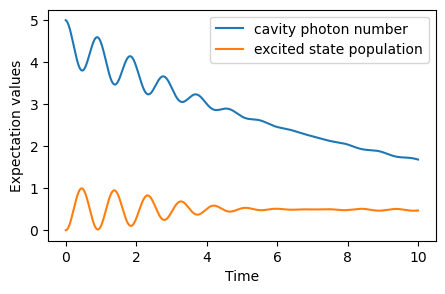

In [152]:
# short-time limit: damped Rabi oscillations
tlist = np.linspace(0,10,10000)
fock_space_size = 10
atom_space_size = 2
atom_cavity_coupling = 0.25
cavity_decay_rate = 0.1
initial_photon_number = 5

atom_fock_in_leaky_cavity(tlist, fock_space_size, atom_space_size, atom_cavity_coupling, cavity_decay_rate, initial_photon_number)


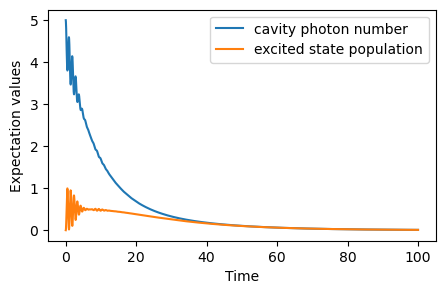

In [52]:
# long-time limit: no photons left, atom in ground state
tlist = np.linspace(0,100,10000)
fock_space_size = 10
atom_space_size = 2
atom_cavity_coupling = 0.25
cavity_decay_rate = 0.1
initial_photon_number = 5

atom_fock_in_leaky_cavity(tlist, fock_space_size, atom_space_size, atom_cavity_coupling, cavity_decay_rate, initial_photon_number)

What if the cavity is initially in a coherent state $\ket{\alpha}$ in a Hilbert space with size $N$? We expect to see Rabi oscillations getting washed out more due to there being a large number of Rabi frequencies. But we also expect to see collapse and revival in the case of low cavity decay due to constructive and destructive interferences of Rabi oscillations!

In [69]:
def atom_coherent_state_in_leaky_cavity(tlist, fock_space_size, atom_space_size, atom_cavity_coupling, cavity_decay_rate, coherent_alpha):
    # convention: atom X photons
    psi0_atom_fock = tensor(fock(atom_space_size,0), coherent(fock_space_size, coherent_alpha))
    a  = tensor(qeye(2), destroy(fock_space_size))
    sigma_minus = tensor(destroy(atom_space_size), qeye(fock_space_size))

    # Jaynes-Cummings Hamiltonian
    H = 2*np.pi*(a.dag()*a + sigma_minus.dag()*sigma_minus + atom_cavity_coupling * (sigma_minus * a.dag() + sigma_minus.dag() * a))

    # collapse operators:
    c_op_list = [np.sqrt(cavity_decay_rate)*a]

    # calculate
    result_atom_fock = mesolve(H, psi0_atom_fock, tlist, c_op_list, [a.dag()*a, sigma_minus.dag()*sigma_minus])

    # plot results at short-time limit:
    fig, ax = plt.subplots(figsize=(5,3))
    ax.plot(tlist, result_atom_fock.expect[0], label='cavity photon number')
    ax.plot(tlist, result_atom_fock.expect[1], label='excited state population')
    ax.legend()
    plt.ylabel('Expectation values')
    plt.xlabel('Time')
    plt.show()

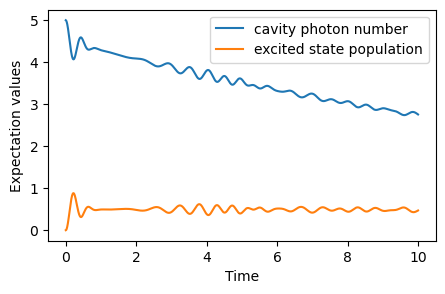

In [72]:
# short-time limit: damped Rabi oscillations
tlist = np.linspace(0,10,10000)
fock_space_size = 100
atom_space_size = 2
atom_cavity_coupling = 0.5
cavity_decay_rate = 0.05
coherent_alpha = np.sqrt(5)

atom_coherent_state_in_leaky_cavity(tlist, fock_space_size, atom_space_size, atom_cavity_coupling, cavity_decay_rate, coherent_alpha=coherent_alpha)


What if we have a thermal state instead? I was asked this question very early on in my PhD and I had idea how to answer it until later when I have some mental picture of what's supposed to happen. But now with QuTip I can explicitly calculate it. 

# <font size=5, color = 'black'> Three-level system: Two-photon damped Rabi-Raman oscillation </font>

Consider a three-level system given by $\ket{1}, \ket{2}, \ket{3}$ where $\ket{2}$ is some intermediate, lossy, excited level. Here, $\ket{1}, \ket{3}$ are the ground states (which are not necessarily degenerate). Assume that $\ket{1}, \ket{2}$ are coupled via a field with detuning $\Delta$ and Rabi frequency $\Omega_{12}$ and $\ket{2}, \ket{3}$ are coupled via a field with detuning $\Delta + \delta$ and Rabi frequency $\Omega_{23}$. We model the lossiness of state $\ket{2}$ by considering another dummy state $\ket{4}$ to which $\ket{2}$ decays with rate $\gamma_e$. With this we have an effective four-level system, but the point just to demonstrate damped two-photon Rabi-Raman damped oscillation. 

Assume that $\Delta \gg \gamma_e$ as typically is the case. Since we do not want the excited, lossy state $\ket{2}$ to participate much, we want to set the Rabi frequencies $\Omega_{12}, \Omega_{23}$ to be small compared to $\Delta$. This process is called adiabatic elimination. We set up our solver so that the initial state is $\ket{1}$.

The end results, which we will check, are that the ground states experience a light shift $\Omega_i^2/4\Delta$, and two-photon Rabi-Raman oscillation occurs with rate 
$$\Omega_\text{Rabi-Raman} = \frac{\Omega_{12}\Omega_{23} \Delta / 2   }{\Delta^2 + \gamma_e^2/4}$$ 
and is damped at rate
$$ \Gamma_\text{Rabi-Raman} = \frac{\Omega_{12} \Omega_{23} \gamma_e / 4}{ \Delta^2 + \gamma_e^2/4} .$$

In [49]:
 # Two-photon damped Rabi-Raman oscillation solver
def two_photon_rabi_raman_damped_oscillation(tlist, levels, gamma_e, Delta, delta, OmegaR_12, OmegaR_23, delta_24):

    one = levels[0]
    two = levels[1]
    three = levels[2]
    four = levels[3]

    # generate relevant projectors
    sig11 = one * one.dag()
    sig22 = two * two.dag()
    sig33 = three * three.dag()
    sig44 = four * four.dag()
    sig12 = one * two.dag()
    sig23 = two * three.dag()
    sig42 = four * two.dag() # |4><2| : sends |2> to |4>

    c_op_list = [np.sqrt(gamma_e)*sig42]

    H0 = Delta*sig11 + 0*sig22 + (Delta+delta)*sig33 + delta_24*sig44 # assuming |2> and |4> are degenerate, it doesn't matter!
    H1 = OmegaR_12*(sig12 + sig12.dag())/2.0 + OmegaR_23*(sig23 + sig23.dag())/2.0
    H = H0 + H1

    output = mesolve(H, one, tlist, c_op_list, [sig11, sig22, sig33, sig44])

    # calculate Rabi-Raman oscillation rate and Rabi-Raman damping rate:
    omega_Rabi_Raman = OmegaR_12 * OmegaR_23 * (Delta/2) / (Delta**2 + gamma_e**2/4)
    gamma_Rabi_Raman = OmegaR_12 * OmegaR_23 * (gamma_e/4) / (Delta**2 + gamma_e**2/4)

    fig, ax = plt.subplots(figsize=(5,3))
    ax.plot(tlist, output.expect[0], label='1')
    ax.plot(tlist, output.expect[1], label='2')
    ax.plot(tlist, output.expect[2], label='3')
    ax.plot(tlist, output.expect[3], label='4')
    ax.plot(tlist, np.cos(tlist * omega_Rabi_Raman/2)**2 *np.exp(-tlist * gamma_Rabi_Raman), ':' , label='analytics')
    plt.ylabel('Population')
    plt.xlabel('Time')
    ax.legend()
    plt.show()

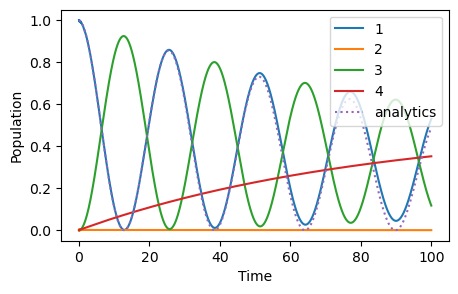

In [48]:
# Zero two-photon detuning case
gamma_e = 0.05*100
Delta = 100 # 12 detuning
delta = 0.0 # 13 two-photon detuning
OmegaR_12 = 7
OmegaR_23 = 7
delta_24 = 0.0 # energy difference between 2 & 4: it doesn't matter! 
tlist = np.linspace(0,100,100000)

# generate basis
one = basis(4,0)
two = basis(4,1)
three = basis(4,2)
four = basis(4,3)
four_levels = [one, two, three, four]

# calculate
two_photon_rabi_raman_damped_oscillation(tlist, four_levels, gamma_e, Delta, delta, OmegaR_12, OmegaR_23, delta_24)

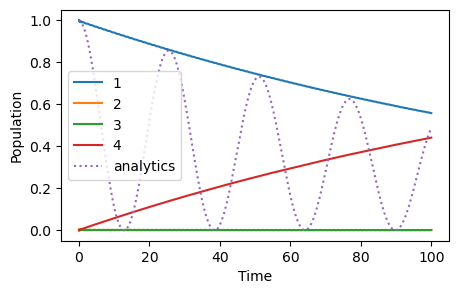

In [50]:
# Non-zero two-photon detuning case: garbage RR oscillation
gamma_e = 0.05*100
Delta = 100 # 12 detuning
delta = 5.0 # 13 two-photon detuning
OmegaR_12 = 7
OmegaR_23 = 7
delta_24 = 0.0 # energy difference between 2 & 4: it doesn't matter! 
tlist = np.linspace(0,100,100000)

# generate basis
one = basis(4,0)
two = basis(4,1)
three = basis(4,2)
four = basis(4,3)
four_levels = [one, two, three, four]

# calculate
two_photon_rabi_raman_damped_oscillation(tlist, four_levels, gamma_e, Delta, delta, OmegaR_12, OmegaR_23, delta_24)

# <font size=5, color='black'> STIRAP </font>

# <font size=5, color='black'>Radial Schrodinger equation solver (Numerov-Cooley method) </font>

In [4]:
# potential definitions and helper functions
def Vr_Morse(r, De, re, beta):
    return De*(1 - np.exp(-beta*(r-re)))**2 - De

def Vr_harmonic(r,omega,re):
    return (1/2)* omega**2 * (r-re)**2

def Vr_Lennard_Jones(r, lamb, re):
    return (lamb / re**2)*( (re/r)**12 - 2 * (re/r)**6 )

def Vr_hardcore(r,V, re):
    return -V * np.heaviside(re-r,1)

# find bound state energies for finite square well:
def bound_state_energies_finite_square_well(re, V):
    # cot is pi-periodic, so need to search for roots in intervals set by r_e * sqrt[V + E] = pi n
    E_intervals = []
    # returns all n's for which this is met:
    for n in range(0, int(np.ceil(np.sqrt(V) * re / np.pi) )):
        E_intervals.append( n**2 * np.pi**2 / re**2 - V)
    E_intervals = np.array(E_intervals)

    f = lambda E: -np.sqrt(-E) - np.sqrt(E+V) / np.tan(re * np.sqrt(V + E))
    E_root = []
    for i in range(E_intervals.size-1):
        # need to re-adjust values to make sure we're avoiding singularities
        E_min = E_intervals[i] + 1e-6
        E_max = E_intervals[i+1] - 1e-6 
        # now find a root of the transcendental equation within this range:
        E_root.append(scipy.optimize.brentq(f, E_min, E_max))
    E_root = np.array(E_root)
    return E_root

# calculate r which minimizes Vr:
def r_Vrmin(r,Vr):
    return r[np.argmin(Vr)], np.argmin(Vr)

# calculate turning points:
def turning_points(r,Vr, E_guess):
    tpts = np.where(np.diff(np.sign( Vr - E_guess )))[0]
    if tpts.size != 2:
        r1, r2 = (0,r.size-1)
    else:
        r1, r2 = tpts
    return r1, r2

# estimate spectrum up to k bound states:
def SE_radial_solver(r, Vr, l, num_states):
    # setting hbar**2/2m = 1
    energies, states = scipy.sparse.linalg.eigs(- FinDiff(0, r[1]-r[0], 2).matrix(r.shape) + scipy.sparse.diags(Vr + l*(l+1)/r**2), k=num_states, which='SR')
    for i in range(0,num_states):
        states[:,i] = states[:,i]/np.sqrt(scipy.integrate.simps(abs(states[:,i])**2, x=r))
    return energies #, states

In [1837]:
# numerov calculate, for E_guess:
@jit(nopython=True, cache=True)
def numerov(r, gr, r_center_idx, dr=1e-3):
    u = np.zeros(r.size)
    # integrate forward to get u[0],...,u[r_center_idx]
    for j in np.linspace(0, r_center_idx, r_center_idx+1):
        i = int(j)
        if i == 0:
            u[i] = 0
        elif i == 1:
            u[i] = 1e-20
        else:
            u[i] = 2*(1 - (5/12)*gr[i-1]*dr**2)*u[i-1] - (1+gr[i-2]*dr**2/12)*u[i-2]
            u[i] /= 1 + gr[i]*dr**2/12 
    # normalize to match wfns
    u[0:r_center_idx] /= u[r_center_idx]
    # integrate backward to get u[r_center_idx],...,u[r.size-1], overwriting u[r_center_idx]
    for j in np.linspace(r.size-1, r_center_idx, r.size - r_center_idx):
        i = int(j)
        if i == r.size-1:
            u[i] = 0
        elif i == r.size-2:
            u[i] = 1e-20
        else:
            u[i] = 2*(1 - (5/12)*gr[i+1]*dr**2)*u[i+1] - (1+gr[i+2]*dr**2/12)*u[i+2]
            u[i] /= 1 + gr[i]*dr**2/12
    # normalize to match wfns    
    u[r_center_idx:r.size-1] /= u[r_center_idx]

    return u

In [1956]:
# Numerov-Cooley optimization
def numerov_optimize(r, Vr, E_guess, r_center_idx, l=0, E_tolerance=1e-5, max_iter=1e5, method='slope', cst = 1, verbose = False):
    # calculate u and initialize:
    dr = abs(r[0] - r[1])
    Veff = Vr + (l*(l+1)/r**2)/cst
    gr = cst*(E_guess - Veff) # cst = 2m / hbar**2
    u = numerov(r, gr, r_center_idx, dr=dr)
    if method == 'slope':
        slope_out  = (u[r_center_idx] - u[r_center_idx-1])/(r[r_center_idx] - r[r_center_idx-1])
        slope_in = (u[r_center_idx+1] - u[r_center_idx+0])/(r[r_center_idx+1] - r[r_center_idx+0])
        E_corr = (slope_out - slope_in)/scipy.integrate.simps(abs(u)**2,r)
    elif method == 'Cooley':
        Y = (1 + gr*dr**2/12)*u
        E_corr = (-Y[r_center_idx-1]+2*Y[r_center_idx]-Y[r_center_idx+1])/dr**2 + gr[r_center_idx]*u[r_center_idx]
        E_corr /= abs(sum(u[:]*np.conjugate(u[:])))
    else: 
        print('Invalid iteration method!')
        return u, E_guess
    
    iteration = 0
    while True:
        if abs(E_corr) >= E_tolerance:
            if iteration <= max_iter:
                # correct E_guess
                E_guess = E_guess + E_corr
                # update wfn
                Veff = Vr + (l*(l+1)/r**2)/cst
                gr = cst*(E_guess - Veff) # cst = 2m / hbar**2
                u = numerov(r, gr, r_center_idx, dr=dr) 
                if method == 'slope':
                    slope_out  = (u[r_center_idx] - u[r_center_idx-1])/(r[r_center_idx] - r[r_center_idx-1])
                    slope_in = (u[r_center_idx+1] - u[r_center_idx+0])/(r[r_center_idx+1] - r[r_center_idx+0])
                    E_corr = (slope_out - slope_in)/scipy.integrate.simps(abs(u)**2,r)
                elif method == 'Cooley':
                    Y = (1 + gr*dr**2/12)*u
                    E_corr = (-Y[r_center_idx-1]+2*Y[r_center_idx]-Y[r_center_idx+1])/dr**2 + gr[r_center_idx]*u[r_center_idx]
                    E_corr /= abs(sum(u[:]*np.conjugate(u[:])))
                iteration += 1

                # update r_center_idx:
                # find r_center_idx at which the solution from the inward integration is maximized:
                r_center_idx = np.argmax(abs(u[r_center_idx:r.size].real)) + r_center_idx
            else:
                if verbose:
                    print('Max iteration exceeded!')
                    print('Iteration completed, last iteration: ' + str(iteration))
                    print('Iteration completed, last correction: ' + str(E_corr))
                    print('Final energy: ' + str(E_guess))
                break
        else:
            if verbose:
                print('Iteration completed, last iteration: ' + str(iteration))
                print('Iteration completed, last correction: ' + str(E_corr))
                print('Final energy: ' + str(E_guess))
            break
    # finally, normalize total wfn:
    u /= np.sqrt(scipy.integrate.simps(abs(u)**2, x=r))
    return u, E_guess

In [1946]:
# generate E_guess using WKB:
def WKB_integral(E_guess, r, Vr, v, cst = 1):
    return abs(np.trapz(np.sqrt(np.heaviside(E_guess - Vr,1)*cst*(E_guess - Vr)),r) - (v+1/2)*np.pi)

def WKB_energy(r, Vr, v, cst = 1):
    v = np.array(v)
    result = np.array([])
    for v_level in v:
        res = scipy.optimize.fsolve(WKB_integral, args = (r, Vr, v_level, cst), x0 = min(Vr[0], Vr[-1]))
        result = np.append(result, res[0])
    return result

## <font size=3, color=37A5C0> Example 1: Morse potential </font>

The Morse potential is given by 
$$ V(r) = D_e (1 - \exp(-\beta (r - r_e))) - D_e $$
where $D_e$ is the dissociation energy, $r_e$ is the equilibrium bond length, and $1/\beta$ is the effective range of the potential. The Morse potential is one of the very few that can be solved exactly. By setting $\hbar^2 / 2\mu = 1$ in the SE, we find that the spectrum for this potential is 
$$ E_n =  \beta \sqrt{4D_e} \left( n + \frac{1}{2}\right)    - \beta^2 \left( n + \frac{1}{2} \right)^2 - D_e.$$  
Note that this spectrum is only correct for $s$-wave interaction, i.e. $l=0$.

Spectrum:
[-178.79853835 -160.28342563 -142.78006034 -126.28844249 -110.80857207
  -96.34044909  -82.88407355  -70.43944543  -59.00656476  -48.58543152
  -39.17604571  -30.77840734  -23.3925164   -17.0183729   -11.65597683
   -7.3053282    -3.96642701   -1.63927324]
E guess:
[-178.80084026 -142.80480653  -96.42494985  -70.56192912  -39.32989413
  -17.15889651]
-178.7985139555214
-142.78001966256366
-96.34041676045969
-70.43941945670733
-39.17602863772304
-17.01836366485556


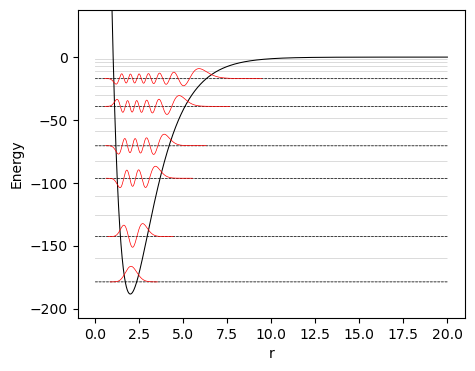

In [1653]:
# Morse potential
rmin = 1e-10
rmax = 20
rpoints = 10000000
r = np.linspace(rmin,rmax,rpoints)
De = 188.4355 # following example from Cooley's 1961 paper
re = 1.9975
beta = 0.711248
Vr = Vr_Morse(r, De, re, beta)

# setup solver
n = np.array([0,2,5,7,10,13])
num_states = max(n)+5
# this spectrum only works for l = 0
spec = beta*np.sqrt(4*De)*(np.linspace(0,num_states-1,num_states)+1/2) - beta**2 *(np.linspace(0,num_states-1,num_states)+1/2)**2 - De
print('Spectrum:')
print(spec)

# use Scipy to estimate spectrum and get E_guess
guess_spectrum = SE_radial_solver(r=r[::int(rpoints/1000)],Vr=Vr[::int(rpoints/1000)], l=0, num_states=num_states)
E_guess = guess_spectrum.real[n]
print('E guess:')
print(E_guess)

# plot potential, E_guess, spectrum, and final wfn
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(r[::100], Vr[::100],'k',linewidth=0.75)
for i in range(num_states):
    ax.plot(r[::5], np.ones(r[::5].size)*spec[i],'k',linewidth=0.1)
for state_idx in range(0,n.size):
    # plot E_guesses:
    ax.plot(r[::100], E_guess[state_idx]*np.ones(r[::100].size), 'k', linewidth=0.5,linestyle='--')
    # solve and optimize  
    r_left_idx, r_right_idx = turning_points(r, Vr, E_guess[state_idx])
    r_left_idx = int(r_left_idx/2)
    r_right_idx = int(r_right_idx * 1.5)
    r_center_idx = int((r_left_idx + r_right_idx)/2) - r_left_idx
    u_final, E_final = numerov_optimize(r[r_left_idx:r_right_idx], 
                                        Vr[r_left_idx:r_right_idx], 
                                        E_guess[state_idx], r_center_idx, l=0, E_tolerance=1e-6, max_iter = 100, method='slope', verbose=False)
    print(E_final)
    # plot results
    scale = De/20
    ax.plot(r[r_left_idx:r_right_idx:2],scale*u_final[::2]+E_final, 'red',linewidth=0.5)
plt.ylim([-1.1*De, 0.2*De])
plt.xlabel('r')
plt.ylabel('Energy')
plt.show()

## <font size=3, color=37A5C0> Example 2: Lennard-Jones potential </font>

The Lennard-Jones potential has the form:
$$ V(r) =  \frac{\lambda}{r_e^2} \left[ \left( \frac{r_e}{r} \right)^{12} - 2 \left( \frac{r_e}{r} \right)^6 \right] $$ 

E guess:
[-50.10397577]
-50.09406738942048


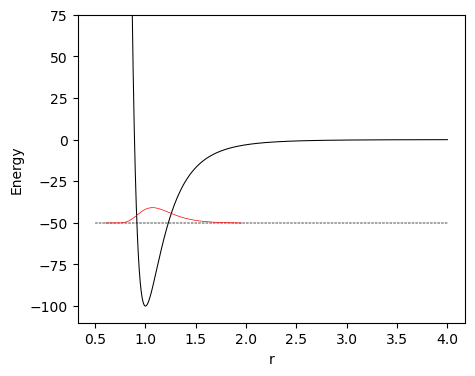

In [225]:
# Lennard-Jones potential
rmin = 0.5
rmax = 4.0
rpoints = 20000000
r = np.linspace(rmin,rmax,rpoints)
re = 1
lamb = 100
l = 0
Vr = Vr_Lennard_Jones(r, lamb, re)

# use Scipy to estimate spectrum and get E_guess
num_states = 1
guess_spectrum = SE_radial_solver(r=r[::int(rpoints/500)],Vr=Vr[::int(rpoints/500)], l=l, num_states=num_states)
E_guess = guess_spectrum.real
print('E guess:')
print(E_guess)

# plot potential, E_guess, spectrum, and final wfn
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(r[::100], Vr[::100],'k',linewidth=0.75)

for state_idx in range(0,num_states):
    # plot E_guesses:
    ax.plot(r[::100], E_guess[state_idx]*np.ones(r[::100].size), 'k', linewidth=0.5,linestyle='--')
    # solve and optimize  
    r_left_idx, r_right_idx = turning_points(r, Vr, E_guess[state_idx])

    r_left_idx = int(r_left_idx/4) 
    r_right_idx = min( int(r_right_idx * 2), r.size-1)
    r_center_idx = int((r_left_idx + r_right_idx)/2) - r_left_idx

    u_final, E_final = numerov_optimize(r[r_left_idx:r_right_idx], 
                                        Vr[r_left_idx:r_right_idx], 
                                        E_guess[state_idx], r_center_idx, l=l, E_tolerance=1e-7, max_iter = 100, method='Cooley', verbose=False)
    print(E_final)
    # plot results
    scale = lamb/20
    ax.plot(r[r_left_idx:r_right_idx:2],scale*u_final[::2]+E_final, 'red',linewidth=0.5)
plt.ylim([-1.1*lamb,0.75*lamb])
plt.xlabel('r')
plt.ylabel('Energy')
plt.show()

## <font size=3, color=37A5C0> Example 3: Square well potential and the scattering length </font>

Consider a finite square well potential of the form $V(r) = V_0 \Theta(R_e - r)$, with $r \geq 0$. 

For bound states, $-V_0 \leq E < V_\text{max} = 0$. The in order for the wavefunctions to be continuous and differentiable, it is required that $ -\sqrt{- E} = \sqrt{ E +V_0} \cot \left( R_e \sqrt{E + V_0}\right) $ (one derives this condition the usual way plus noting the fact that $u(0) = 0$). This is a transcendental equation which must be solved numerically. For example, let $R_e = 2, V_0 = 100$. Then we have $$E = -97.76, -91.06, -79.93, -64.43, -44.72, -21.17.$$ There are 6 bound states in this case. 

Number of bound states: 
9
Analytic E guess: 
[-98.97309993 -95.89379161 -90.76644746 -83.59908438 -74.40477116
 -63.20450162 -50.03354685 -34.95815154 -18.13691785]
NC Bound state energy: -98.97310034289661
NC Bound state energy: -95.89378261752437
NC Bound state energy: -90.7664331605326
NC Bound state energy: -83.59905962856706
NC Bound state energy: -74.40473340106533
NC Bound state energy: -63.2044477490118
NC Bound state energy: -50.0334781549896
NC Bound state energy: -34.95806249922485
NC Bound state energy: -18.136813746911404


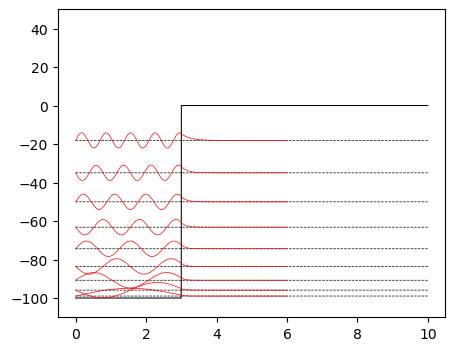

In [300]:
# square well potential
rmin = 1e-6
rmax = 10
rpoints = 1000000
r = np.linspace(rmin, rmax, rpoints)
V = 100
l = 0
re = 3
Vr = Vr_hardcore(r,V,re)

#############################################
######### BOUND STATE SEARCH ################
#############################################

# use analytics to estimate spectrum and get E_guess:
E_guess = bound_state_energies_finite_square_well(re, V)
print('Number of bound states: ')
num_states = E_guess.size
print(num_states)
print('Analytic E guess: ')
print(E_guess)

# plot potential, E_guess, spectrum, and final wfn
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(r[::100], Vr[::100],'k',linewidth=0.75)

r_left_idx = 0
r_right_idx = 2 * int(re * r.size/(rmax - rmin))
r_center_idx = int(r.size // int( (rmax - rmin) / re)  )

for state_idx in range(0,num_states):
    # plot E_guesses:
    ax.plot(r[::100], E_guess[state_idx]*np.ones(r[::100].size), 'k', linewidth=0.5,linestyle='--')
    # solve and optimize  
    u_final, E_final = numerov_optimize(r[r_left_idx:r_right_idx], 
                                        Vr[r_left_idx:r_right_idx], 
                                        E_guess[state_idx], r_center_idx, l=l, E_tolerance=1e-7, max_iter = 100, method='Cooley', verbose=False)
    print('NC Bound state energy: ' + str(E_final))
    # plot results
    scale = V/20
    ax.plot(r[r_left_idx:r_right_idx:2],scale*u_final[::2]+E_final, 'red',linewidth=0.5)
plt.ylim([-1.1*V, 0.5*V])
plt.show()

It turns out that there is a threshold behavior in 3D (as in our case here). The potential well could be too shallow to host a bound state (unlike in 1D or 2D). This is due to the boundary condition $u(0) = rR(r) = 0$, which does not arise in one or two dimensions. What is this threshold? One can derive it from the requirement that $0 < n^2 < VR_e^2/\pi^2$. The result is that a bound state exists only for $V > (\pi/R_e)^2$.  When on bound state exists, the ground state of the system is a scattering state. 

Number of bound states: 
7
Bound and scattering state energy guesses:
[-52.8314027  -49.82545764 -44.82773555 -37.86034929 -28.96551031
 -18.23372127  -5.95136822   1.        ]
NC Bound state energy: -52.83140248114112
NC Bound state energy: -49.825450084048725
NC Bound state energy: -44.827722180125335
NC Bound state energy: -37.86032666500178
NC Bound state energy: -28.965477984778307
NC Bound state energy: -18.23368125569271
NC Bound state energy: -5.951317291573732
NC Scattering state energy: 1.7852312526946448


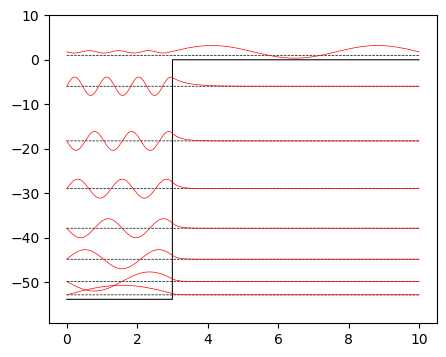

In [328]:
# square well potential
rmin = 1e-6
rmax = 10
rpoints = 1000000
r = np.linspace(rmin, rmax, rpoints)
re = 3
n = 7 # gives the number of bound states
V = (n*np.pi/re)**2 + 0.1
l = 0
Vr = Vr_hardcore(r,V,re)

#############################################
######### BOUND STATE SEARCH ################
#############################################

# use analytics to estimate spectrum and get E_guess:
E_guess = bound_state_energies_finite_square_well(re, V)
print('Number of bound states: ')
num_states = E_guess.size
print(num_states)
# print('Analytic E guess: ')
# print(E_guess)

# add guesses for scattering states:
print('Bound and scattering state energy guesses:')
E_guess = np.append(E_guess, 1.0)
num_states = E_guess.size
print(E_guess)

# plot potential, E_guess, spectrum, and final wfn
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(r[::100], Vr[::100],'k',linewidth=0.75)

r_left_idx = 0
r_right_idx = r.size - 1
r_center_idx = int(r.size // int( (rmax - rmin) / re)  )

for state_idx in range(0,num_states):
    # plot E_guesses:
    ax.plot(r[::100], E_guess[state_idx]*np.ones(r[::100].size), 'k', linewidth=0.5,linestyle='--')
    # solve and optimize  
    u_final, E_final = numerov_optimize(r[r_left_idx:r_right_idx], 
                                        Vr[r_left_idx:r_right_idx], 
                                        E_guess[state_idx], r_center_idx, l=l, E_tolerance=1e-7, max_iter = 100, method='Cooley', verbose=False)
    if E_final < Vr[-1]:
        print('NC Bound state energy: ' + str(E_final))
    else:
        print('NC Scattering state energy: ' + str(E_final))
    # plot results
    scale = V/20
    ax.plot(r[r_left_idx:r_right_idx:2],scale*u_final[::2]+E_final, 'red',linewidth=0.5)
plt.ylim([-1.1*V, 10])
plt.show()

We notice that the wavefunction $u(r) = rR(r)$ looks like $\sin(kr + \delta(k))$ far from the potential well. The phase shift $\delta(k)$ is related to the scattering length $a$ defined as 

$$ a = \lim_{k \ll 1/R_e} \frac{\tan \delta(k)}{k} $$

In ultracold atom experiments, $k$ is very small and in particular the de Broglie wavelength $\lambda_{dB} \sim 1/k$ is very large, much larger than the effective range of the potential well. As a result, we don't think about the microscopic details of the potential (unless we're worried about the bound state wavefunctions) and think only about the phase shift of the wavefunction $rR(r)$ due to the existence of the potential well. The scattering length basically tells us how much the wavefunction has been shifted from the origin due to the potential well. This shift $a$ can be positive, negative, or infinite. Without worrying about Bessel functions (which arise if we treat this problem with partial waves), we can have this mental picture to keep things simple. 

# <font size=5, color='black'> NaK Electronic potentials and their bound states</font>

## <font size=4, color='blue'>Setup: potential definitions, RKR procedure, and helper functions</font>

Here is a table with Dunham coefficients and how they translate to molecular constants:

$$ \begin{align*}
Y_{10} &= \omega_e\\
Y_{01} &= B_e\\
Y_{02} &= D_e \\
Y_{03} &= F_e \\
Y_{20} &= -\omega_e x\\  
Y_{11} &= -\alpha_e \\
Y_{12} &= \beta_e  \\
Y_{04} &= H_e \\
Y_{30} &= \omega_e y\\  
Y_{21} &= \gamma_e \\
Y_{40} &= \omega_e z\\ 
\end{align*} $$


In [2081]:
# RKR procedure: 

def RKR_T(v,Y,J=0): # verified correct
    T=0
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            T += Y[i][j] * (v+1/2)**i * (J*(J+1))**j
    return T

def RKR_B(v,Y): # should be correct
    B = 0
    for i in range(Y.shape[0]):
        B += Y[i][1] * (v + 1/2)**i
    return B

def RKR_s(v, Y): # should be correct
    s = 0
    for i in range(Y.shape[0]-1):
        s += (i+1) * Y[i+1][0] * (v+1/2)**i
    return s

def RKR_f(v,Y,J=0):
    df = 1e-10
    first_term, first_term_err = scipy.integrate.quad(lambda n: 1/np.sqrt(RKR_T(v,Y,J) - RKR_T(n,Y,J)), -0.5, v-df, epsabs=1e-10, epsrel=1e-10)
    second_term = 2 * np.sqrt(df / RKR_s(v,Y))   
    return first_term + second_term

def RKR_g(v,Y,J=0):
    df = 1e-10
    first_term, first_term_err = scipy.integrate.quad(lambda ns: RKR_B(ns,Y)/np.sqrt(RKR_T(v,Y,J) - RKR_T(ns,Y,J)), -0.5, v-df, epsabs=1e-10, epsrel=1e-10)
    second_term = RKR_B(v,Y) * 2 * np.sqrt(df /RKR_s(v,Y))   
    return first_term + second_term

def RKR_r1r2(v,Y,J=0):
    f = RKR_f(v,Y,J) 
    g = RKR_g(v,Y,J)
    r1 = (RKRcst/np.sqrt(muNa39K)) * ( np.sqrt(f/g + f**2) - f  )
    r2 = (RKRcst/np.sqrt(muNa39K)) * ( np.sqrt(f/g + f**2) + f  )
    Vr = RKR_T(v, Y, J)
    return r1, r2, Vr

def RKR_mass_scaled_Y(Y, initial='39K', final='40K'):
    # formulas from Dunham's 1932 paper
    Y_corr = np.copy(Y)
    beta = np.copy(Y*0)
    # the coefs above are for 23Na-39K. We need to rescale to get 23Na-40K. 
    # mass-rescaling... act on Yij. More details can be found in Dunham's 1932 paper
    a1 = Y[1][1]*Y[1][0]/(6*Y[0][1]**2) - 1
    beta[0][1] = Y[1][0]**2 * Y[2][1]/(4*Y[0][1]**3) + 16*a1*Y[2][0]/(3*Y[0][1])- 8*a1 - 6*a1**2 + 4*a1**3
    beta[1][0] = 5*Y[1][0]*Y[3][0]/(4*Y[0][1]**2) + a1*Y[1][0]**2*Y[2][1]/(3*Y[0][1]**3) - 10*a1 - 20*a1**2 - 15*a1**3/2 - (5*a1**4)/2 + Y[2][0]*(4*a1+(16*a1**2) / 3)/Y[0][1] + Y[2][0]**2/(2*Y[0][1]**2)
    beta[0][2] = 73/2 + 37*a1 + 67*a1**2/2 + 33*a1*3 - 6*a1**4 - 9*Y[1][0]*Y[3][0]/(2*Y[0][1]**2) + Y[1][0]**2*Y[2][1]*(3-11*a1/6)/(2*Y[0][1]**3) - Y[2][0]*(130/3+4*a1+74*a1**2/3)/(2*Y[0][1]) + (31*Y[2][0]**2)/(9*Y[0][1]**2)

    # print('Typical correction:')
    # print(beta[0][1] * (Y[0][1]/Y[1][0])**2 * (muNa39K - muNa40K)/muNa40K) # = -1.49683e-7 verified

    # now generate Y_corr[i][j]
    if initial == '39K' and final == '40K':
        for i in range(Y_corr.shape[0]):
            for j in range(Y_corr.shape[1]):
                # note: Y01 ~ Be, the vibrational constant... Y10 ~ \omega_e, the vibrational frequency (see Dunham's paper)
                # mass-scaling: see Dunham's paper for formula 
                Y_corr[i][j] = Y[i][j] * (muNa39K/muNa40K)**(i/2 + j) * (1 + beta[i][j] * (Y[0][1]/Y[1][0])**2 * (muNa39K - muNa40K)/muNa40K) 
    return Y_corr

In [1627]:
# cm-1 to nm:
def cm1_to_nm(cm1):
    wavelength_nm = (( 1/cm1 )/100) * 1e9
    return wavelength_nm

In [1871]:
# cm-1 to THz:
def cm1_to_THz(cm1):
    return c*(cm1*100)*1e-12

In [2296]:
# # E(v,J) bound state energies in cm-1 from absolute ground state:
def bound_state_energy_cm1(potential = 'c3SigmaPlus', j=0, mass_scaled = False):
    
    if potential == 'c3SigmaPlus':
        Y = Y_Na39K_c3SigmaPlus
        v_max = v_max_c3SigmaPlus
        Te = Te_c3SigmaPlus
    if potential == 'b3Pi':
        Y = Y_Na39K_b3Pi
        v_max = v_max_b3Pi
        Te = Te_b3Pi
    if potential == 'A1SigmaPlus':
        Y = Y_Na39K_A1SigmaPlus
        v_max = v_max_A1SigmaPlus
        Te = Te_A1SigmaPlus
    if potential == 'B1Pi':
        Y = Y_Na39K_B1Pi
        v_max = v_max_B1Pi
        Te = TeB1Pi
    if potential == 'X1SigmaPlus':
        print('Not supported!')
        return 
    if potential == 'a3SigmaPlus':
        print('Not supported!')
        return 
    
    if mass_scaled:
        Y = RKR_mass_scaled_Y(Y=Y, initial='39K', final='40K')
        
    PA_lines = np.array([])
    for v in range(v_max+1):
        PA_lines = np.append(PA_lines, RKR_T(v=v, Y=Y, J=j) + Te)
    return PA_lines


In [2218]:
# calculate mass-scaled rotational constant Be:
def rotational_constant(potential = 'c3SigmaPlus', v=0, mass_scaled = False):
    if potential == 'c3SigmaPlus':
        Y = Y_Na39K_c3SigmaPlus
        v_max = v_max_c3SigmaPlus
    if potential == 'b3Pi':
        Y = Y_Na39K_b3Pi
        v_max = v_max_b3Pi
    if potential == 'A1SigmaPlus':
        Y = Y_Na39K_A1SigmaPlus
        v_max = v_max_A1SigmaPlus
    if potential == 'B1Pi':
        Y = Y_Na39K_B1Pi
        v_max = v_max_B1Pi
    if potential == 'X1SigmaPlus':
        print('Not supported!')
        return 0
    if potential == 'a3SigmaPlus':
        print('Not supported!')
        return 0
    if mass_scaled:
        Y = RKR_mass_scaled_Y(Y=Y, initial='39K', final='40K')

    Bv = 0
    for i in range(Y.shape[0]):
        Bv += Y[i][1] * (v+1/2)**i
    return Bv

In [1938]:
def Vr_X1SigmaPlus(r, j=0, mass_scaled=True, version = '2019'):
    # if mass-scaling is required, then rescale Tiemann's Dunham coefs to get those for Na40K
    # else, use analytic expansion from https://arxiv.org/pdf/1810.00608.pdf Hanover, PRA 032711, 2019 

    if mass_scaled:
        Y = Y_Na39K_X1SigmaPlus
        Y = RKR_mass_scaled_Y(Y, initial='39K', final='40K')
        # next, generate Vr data from RKR procedure for interpolation:
        vs = np.linspace(0,v_max_X1SigmaPlus,v_max_X1SigmaPlus+1)
        vs = vs.astype(int)
        r_X1SigmaPlus_data = []
        Vr_X1SigmaPlus_data = []
        for v in vs:
            rmin, rmax, U = RKR_r1r2(v=v, Y=Y, J=j) 
            r_X1SigmaPlus_data.append(rmin)
            Vr_X1SigmaPlus_data.append(U)
            r_X1SigmaPlus_data.append(rmax)
            Vr_X1SigmaPlus_data.append(U)
        # numpize data for interpolation later
        r_X1SigmaPlus_data = np.array(r_X1SigmaPlus_data)          # verified
        Vr_X1SigmaPlus_data = np.array(Vr_X1SigmaPlus_data) - DeX  # verified

        # take some small r's for fitting the short-range part and some large r's for fitting the long-range part
        # first we sort, then get the short-range and long-range data:
        sort_data = np.argsort(r_X1SigmaPlus_data)
        r_short_range = r_X1SigmaPlus_data[sort_data][0:9]
        U_RKR_short_range = Vr_X1SigmaPlus_data[sort_data][0:9]
        r_long_range = r_X1SigmaPlus_data[sort_data][-12:]
        U_RKR_long_range  = Vr_X1SigmaPlus_data[sort_data][-12:]

        # fit the short-range data to Tiemann's constants, with flexibility for mass-scaling: only change B!
        if version == '2019':
            def sr(z, B):
                return A_X1SigmaPlus + B/z**q_X1SigmaPlus
            def lr(z, C6, C8, C10):
                return - C6/z**6 - C8/z**8 - C10/z**10  - Aex_X1SigmaPlus*z**gamma_X1SigmaPlus*np.exp(-beta_X1SigmaPlus*z)
        elif version == '2008':
            def sr(z, B):
                return A_X1SigmaPlus_2008 + B/z**q_X1SigmaPlus_2008
            def lr(z, C6, C8, C10):
                return - C6/z**6 - C8/z**8 - C10/z**10  - Aex_X1SigmaPlus_2008*z**gamma_X1SigmaPlus_2008*np.exp(-beta_X1SigmaPlus_2008*z)
            
        short_range_params, short_range_cov = scipy.optimize.curve_fit(sr, r_short_range, U_RKR_short_range, 
                                                                    p0 = [1e6],
                                                                    bounds = ([0], [1e9]))
        long_range_params, long_range_cov = scipy.optimize.curve_fit(lr, r_long_range, U_RKR_long_range, 
                                                                    p0 = [-1e8, 1e9, -1e10],
                                                                    bounds = ([-1e12,-1e12,-1e12], [1e12, 1e12, 1e12]))
        BB    = short_range_params[0]
        C6    = long_range_params[0]
        C8    = long_range_params[1]
        C10   = long_range_params[2]

        # now we can generate the smooth potential curve. We can interpolate on the Ferber data or the RKR-generated data. Will use Ferber for consistency:
        Vr = r*0
        Vr_X1SigmaPlus_interpolate = scipy.interpolate.CubicSpline(r_X1SigmaPlus_data[sort_data], Vr_X1SigmaPlus_data[sort_data])
        r_short = r[r<=max(r_short_range)]
        r_med = r[r > max(r_short_range)]
        r_med = r_med[r_med <= min(r_long_range)]
        r_long = r[r > min(r_long_range)]
        Vr_medium_range = Vr_X1SigmaPlus_interpolate(r_med)
        Vr_short_range = sr(r_short, BB)
        Vr_long_range  = lr(r_long, C6, C8, C10)
        Vr = np.concatenate((Vr_short_range, Vr_medium_range, Vr_long_range), axis=None)

    else: # without mass-scaling, use constants from Table II of https://arxiv.org/pdf/1810.00608.pdf (Hanover, PRA 032711, 2019)
        Vr = np.zeros(r.size)
        if version == '2019':
            for i in range(r.size):
                if r[i] < Ri_X1SigmaPlus:
                    Vr[i] = A_X1SigmaPlus + B_X1SigmaPlus/ (r[i]**q_X1SigmaPlus)
                elif Ri_X1SigmaPlus <= r[i] <= Ro_X1SigmaPlus:
                    for k in range(a_X1SigmaPlus.size):
                        Vr[i] +=  a_X1SigmaPlus[k] * ( (r[i] - Rm_X1SigmaPlus) / (r[i] + b_X1SigmaPlus * Rm_X1SigmaPlus) )**k
                elif r[i] > Ro_X1SigmaPlus:
                    E_ex = Aex_X1SigmaPlus * r[i]**gamma_X1SigmaPlus *np.exp(- beta_X1SigmaPlus * r[i])
                    Vr[i] = -C6_X1SigmaPlus/r[i]**6 - C8_X1SigmaPlus/r[i]**8 - C10_X1SigmaPlus/r[i]**10  - E_ex # final minus singlet state
        elif version == '2008':
            for i in range(r.size):
                if r[i] < Ri_X1SigmaPlus_2008:
                    Vr[i] = A_X1SigmaPlus_2008 + B_X1SigmaPlus_2008/ (r[i]**q_X1SigmaPlus_2008)
                elif Ri_X1SigmaPlus_2008 <= r[i] <= Ro_X1SigmaPlus_2008:
                    for k in range(a_X1SigmaPlus_2008.size):
                        Vr[i] +=  a_X1SigmaPlus_2008[k] * ( (r[i] - Rm_X1SigmaPlus_2008) / (r[i] + b_X1SigmaPlus_2008 * Rm_X1SigmaPlus_2008) )**k
                elif r[i] > Ro_X1SigmaPlus_2008:
                    E_ex = Aex_X1SigmaPlus_2008 * r[i]**gamma_X1SigmaPlus_2008 *np.exp(- beta_X1SigmaPlus_2008 * r[i])
                    Vr[i] = -C6_X1SigmaPlus_2008/r[i]**6 - C8_X1SigmaPlus_2008/r[i]**8 - C10_X1SigmaPlus_2008/r[i]**10  - E_ex # final minus singlet state

    return Vr

In [1937]:
def Vr_a3SigmaPlus(r, j=0, mass_scaled = True, version = '2019'):
    # a3SigmaPlus potential of NaK
    # if no mass-scaling then use analytical expression from Hanover 2019 paper
    # if masss-scaling required then use scaled Dunham coefs for Na39K, taken from Tiemann's 2008 paper

    if mass_scaled:
        Y = Y_Na39K_a3SigmaPlus
        Y = RKR_mass_scaled_Y(Y, initial='39K', final='40K')  # can be disabled for testing
        # next, generate Vr data from RKR procedure for interpolation:
        vs = np.linspace(0,v_max_a3SigmaPlus,v_max_a3SigmaPlus+1)
        vs = vs.astype(int)
        r_a3SigmaPlus_data = []
        Vr_a3SigmaPlus_data = []
        for v in vs:
            rmin, rmax, U = RKR_r1r2(v=v, Y=Y, J=j) 
            r_a3SigmaPlus_data.append(rmin)
            Vr_a3SigmaPlus_data.append(U)
            r_a3SigmaPlus_data.append(rmax)
            Vr_a3SigmaPlus_data.append(U)
        # numpize data for interpolation later
        r_a3SigmaPlus_data = np.array(r_a3SigmaPlus_data)                      # verified
        Vr_a3SigmaPlus_data = np.array(Vr_a3SigmaPlus_data) - Te_a3SigmaPlus   # verified

        # take some small r's for fitting the short-range part and some large r's for fitting the long-range part
        # first we sort, then get the short-range and long-range data:
        sort_data = np.argsort(r_a3SigmaPlus_data)
        r_short_range = r_a3SigmaPlus_data[sort_data][0:9]
        U_RKR_short_range = Vr_a3SigmaPlus_data[sort_data][0:9]
        r_long_range = r_a3SigmaPlus_data[sort_data][-12:]
        U_RKR_long_range  = Vr_a3SigmaPlus_data[sort_data][-12:]

        # fit the short-range data to Hanover's constants, with flexibility for mass-scaling: only change B!
        if version == '2019':
            def sr(z,B):
                return A_a3SigmaPlus + B/z**q_a3SigmaPlus      
            def lr(z, C6, C8, C10):
                return - C6/z**6 - C8/z**8 - C10/z**10  + Aex_a3SigmaPlus*z**gamma_a3SigmaPlus*np.exp(-beta_a3SigmaPlus*z)
        elif version == '2008':
            def sr(z,B):
                return A_a3SigmaPlus_2008 + B/z**q_a3SigmaPlus_2008
            def lr(z, C6, C8, C10):
                return - C6/z**6 - C8/z**8 - C10/z**10  + Aex_a3SigmaPlus_2008*z**gamma_a3SigmaPlus_2008*np.exp(-beta_a3SigmaPlus_2008*z)        
        
        short_range_params, short_range_cov = scipy.optimize.curve_fit(sr, r_short_range, U_RKR_short_range, 
                                                                    p0 = [1e6],
                                                                    bounds = ([0], [1e9]))
        long_range_params, long_range_cov = scipy.optimize.curve_fit(lr, r_long_range, U_RKR_long_range, 
                                                                    p0 = [0.1e8, 0.3e9, 0.4e10],
                                                                    bounds = ([0,0,0], [1e12, 1e12, 1e14]))
        BB    = short_range_params[0]
        C6    = long_range_params[0]
        C8    = long_range_params[1]
        C10   = long_range_params[2]

        # now we can generate the smooth potential curve. We can interpolate on the Ferber data or the RKR-generated data. Will use Ferber for consistency:
        Vr = r*0
        Vr_a3SigmaPlus_interpolate = scipy.interpolate.CubicSpline(r_a3SigmaPlus_data[sort_data], Vr_a3SigmaPlus_data[sort_data])
        r_short = r[r<=max(r_short_range)]
        r_med = r[r > max(r_short_range)]
        r_med = r_med[r_med <= min(r_long_range)]
        r_long = r[r > min(r_long_range)]
        Vr_medium_range = Vr_a3SigmaPlus_interpolate(r_med)
        Vr_short_range = sr(r_short, BB)
        Vr_long_range  = lr(r_long, C6, C8, C10)
        Vr = np.concatenate((Vr_short_range, Vr_medium_range, Vr_long_range), axis=None)

    else:
        Vr = np.zeros(r.size)
        if version == '2019':
            for i in range(r.size):
                if r[i] < Ri_a3SigmaPlus:
                    Vr[i] = A_a3SigmaPlus + B_a3SigmaPlus/ (r[i]**q_a3SigmaPlus)
                elif Ri_a3SigmaPlus <= r[i] <= Ro_a3SigmaPlus:
                    for k in range(a_a3SigmaPlus.size):
                        Vr[i] +=  a_a3SigmaPlus[k] * ( (r[i] - Rm_a3SigmaPlus) / (r[i] + b_a3SigmaPlus * Rm_a3SigmaPlus) )**k
                elif r[i] > Ro_a3SigmaPlus:
                    E_ex = Aex_a3SigmaPlus * r[i]**gamma_a3SigmaPlus *np.exp(- beta_a3SigmaPlus * r[i])
                    Vr[i] = -C6_a3SigmaPlus/r[i]**6 - C8_a3SigmaPlus/r[i]**8 - C10_a3SigmaPlus/r[i]**10 + E_ex # final plus triplet state
        elif version == '2008':
            for i in range(r.size):
                if r[i] < Ri_a3SigmaPlus_2008:
                    Vr[i] = A_a3SigmaPlus_2008 + B_a3SigmaPlus_2008/ (r[i]**q_a3SigmaPlus_2008)
                elif Ri_a3SigmaPlus_2008 <= r[i] <= Ro_a3SigmaPlus_2008:
                    for k in range(a_a3SigmaPlus_2008.size):
                        Vr[i] +=  a_a3SigmaPlus_2008[k] * ( (r[i] - Rm_a3SigmaPlus_2008) / (r[i] + b_a3SigmaPlus_2008 * Rm_a3SigmaPlus_2008) )**k
                elif r[i] > Ro_a3SigmaPlus:
                    E_ex = Aex_a3SigmaPlus_2008 * r[i]**gamma_a3SigmaPlus_2008 *np.exp(- beta_a3SigmaPlus_2008 * r[i])
                    Vr[i] = -C6_a3SigmaPlus_2008/r[i]**6 - C8_a3SigmaPlus_2008/r[i]**8 - C10_a3SigmaPlus_2008/r[i]**10 + E_ex # final plus triplet state
    return Vr

In [2227]:
def Vr_B1Pi(r, j=0, mass_scaled = True, no_kink=True):
    Y = Y_Na39K_B1Pi
    
    # now generate mass-scaled Y[i][j] from muNa39K to muNa40K
    if mass_scaled:
        Y = RKR_mass_scaled_Y(Y, initial='39K', final='40K')

    # next, generate Vr data from RKR procedure for interpolation:
    vs = np.linspace(0,v_max_B1Pi,v_max_B1Pi+1)
    vs = vs.astype(int)
    r_B1Pi_data = []
    Vr_B1Pi_data = []
    r_B1Pi_short_range_data = []
    Vr_B1Pi_short_range_data = []
    for v in vs:
        rmin, rmax, U = RKR_r1r2(v=v, Y=Y, J=j) 
        r_B1Pi_data.append(rmin)
        Vr_B1Pi_data.append(U)
        r_B1Pi_data.append(rmax)
        Vr_B1Pi_data.append(U)
        r_B1Pi_short_range_data.append(rmin)
        Vr_B1Pi_short_range_data.append(U)
    # numpize data for interpolation later
    r_B1Pi_data = np.array(r_B1Pi_data)
    Vr_B1Pi_data = np.array(Vr_B1Pi_data)
    r_B1Pi_short_range_data = np.array(r_B1Pi_short_range_data)
    Vr_B1Pi_short_range_data = np.array(Vr_B1Pi_short_range_data)

    # We can't interpolate this data yet because of a "backbend" issue for v = 35 to 43 at small r (plot this and see for yourself!
    # to fix the backbend issue by fixing some values of r: do this using the fitted form of potential in short-range:
    def sr(z, A, B):
        return A + B/z**12
    def lr(z, De, C6, C8, C10):
        return De - C6/z**6 - C8/z**8 - C10/z**10
        
    Vr_B1Pi_data_corrected = np.copy(Vr_B1Pi_data) # nothing to correct here, but good for readability
    r_B1Pi_data_corrected  = np.copy(r_B1Pi_data)
    sort_sr_data = np.argsort(Vr_B1Pi_short_range_data)

    v_start = 30
    v_end   = 34
    # fit the short-range to inner turning points associated with v = 30 to v = 34.
    r_sr_backbend_fix = np.copy( r_B1Pi_short_range_data[sort_sr_data])[v_start:(v_end+1)]
    V_sr_backbend_fix = np.copy(Vr_B1Pi_short_range_data[sort_sr_data])[v_start:(v_end+1)]

    backbend_fix_short_range_params, sr_bb_cov = scipy.optimize.curve_fit(sr, r_sr_backbend_fix, V_sr_backbend_fix, 
                                                                   p0 = [-1000, 1e8],
                                                                   bounds = ([-5000,1e3], [5000, 1e10]))
    AA_backbend = backbend_fix_short_range_params[0]
    BB_backbend = backbend_fix_short_range_params[1]

    num_pts_correct = 12 # how many points do I want to correct?
    for v in range(v_max_B1Pi - num_pts_correct, v_max_B1Pi+1):
        r_root = scipy.optimize.fsolve(lambda r: (AA_backbend + BB_backbend/r**12) - Vr_B1Pi_data_corrected[2*v], [3.0-2.0, 3.0+2.0])  # fix rmin for this U(r)
        r_B1Pi_data_corrected[2*v]   = r_root[0]
        r_B1Pi_data_corrected[2*v+1] = (r_B1Pi_data[2*v+1] - r_B1Pi_data[2*v]) + r_B1Pi_data_corrected[2*v]  # fix rmax for this U(r)

    # finally, we need to generate the short-range, medium-range, and long-range parts
    sort_data = np.argsort(r_B1Pi_data_corrected)
    num_r_short_range = 10
    num_r_long_range  = 10
    r_short_range     = np.copy(r_B1Pi_data_corrected[sort_data][0:num_r_short_range])
    r_long_range      = np.copy(r_B1Pi_data_corrected[sort_data][-num_r_long_range:])
    U_RKR_long_range  = np.copy(Vr_B1Pi_data_corrected[sort_data][-num_r_long_range:])
    
    long_range_params, long_range_cov = scipy.optimize.curve_fit(lr, r_long_range, U_RKR_long_range, 
                                                                 p0 = [5000, 1e6, 1e8, 1e10],
                                                                 bounds = ([0,-1e12,-np.Inf,-np.Inf], [5000, 1e12, np.Inf, np.Inf]))
    De  = long_range_params[0]
    C6  = long_range_params[1]
    C8  = long_range_params[2]
    C10 = long_range_params[3]

    # print(long_range_params)

    Vr = r*0
    if no_kink:
        trimmed_r_B1Pi_data_corrected  = np.delete( r_B1Pi_data_corrected[sort_data],  np.linspace(num_pts_correct-4,num_pts_correct+6,9).astype(int))
        trimmed_Vr_B1Pi_data_corrected = np.delete(Vr_B1Pi_data_corrected[sort_data],  np.linspace(num_pts_correct-4,num_pts_correct+6,9).astype(int))
        # add more data to trimmed data for interpolation:
        x = min(trimmed_r_B1Pi_data_corrected)
        extra_r_sr = np.array([x-0.005, x-0.01])
        trimmed_r_B1Pi_data_corrected = np.concatenate([trimmed_r_B1Pi_data_corrected, extra_r_sr], axis=None)
        trimmed_Vr_B1Pi_data_corrected = np.concatenate([trimmed_Vr_B1Pi_data_corrected, sr(extra_r_sr, AA_backbend, BB_backbend)], axis=None)
        sort_trimmed_r = np.argsort(trimmed_r_B1Pi_data_corrected)
        Vr_B1Pi_interpolate = scipy.interpolate.CubicSpline(trimmed_r_B1Pi_data_corrected[sort_trimmed_r], trimmed_Vr_B1Pi_data_corrected[sort_trimmed_r])
    else:
        Vr_B1Pi_interpolate = scipy.interpolate.CubicSpline(r_B1Pi_data_corrected[sort_data], Vr_B1Pi_data_corrected[sort_data])

    r_short = r[r<max(r_short_range)]
    r_med = r[r >= max(r_short_range)]
    r_med = r_med[r_med <= min(r_long_range)]
    r_long = r[r > min(r_long_range)]
    Vr_medium_range = Vr_B1Pi_interpolate(r_med)
    Vr_short_range = sr(r_short,AA_backbend,BB_backbend)
    Vr_long_range  = lr(r_long,De, C6, C8, C10)
    Vr = np.concatenate((Vr_short_range, Vr_medium_range, Vr_long_range), axis=None)

    return Vr + TeB1Pi - DeX

In [1936]:
def Vr_c3SigmaPlus(r, j=0, mass_scaled=True):
    Y = Y_Na39K_c3SigmaPlus

    # now generate mass-scaled Y[i][j] from muNa39K to muNa40K
    if mass_scaled:
        Y = RKR_mass_scaled_Y(Y, initial='39K', final='40K')

    # next, generate Vr data from RKR procedure for interpolation:
    vs = np.linspace(0,v_max_c3SigmaPlus,v_max_c3SigmaPlus+1)
    vs = vs.astype(int)
    r_c3SigmaPlus_data = []
    Vr_c3SigmaPlus_data = []
    for v in vs:
        rmin, rmax, U = RKR_r1r2(v=v, Y=Y, J=j) 
        r_c3SigmaPlus_data.append(rmin)
        Vr_c3SigmaPlus_data.append(U)
        r_c3SigmaPlus_data.append(rmax)
        Vr_c3SigmaPlus_data.append(U)
    # numpize data for interpolation later
    r_c3SigmaPlus_data = np.array(r_c3SigmaPlus_data)
    Vr_c3SigmaPlus_data = np.array(Vr_c3SigmaPlus_data)

    # there's no backbend issue like the B1Pi potential, but still need the short-range, medium-range, and long-range
    # to generate these, we use Ferber's Table V RKR potential data
    # take some small r's for fitting the short-range part and some large r's for fitting the long-range part
    # first we sort, then get the short-range and long-range data:
    sort_Ferber = np.argsort(r_Ferber)
    r_short_range = r_Ferber[sort_Ferber][0:11]
    U_RKR_short_range = U_Ferber[sort_Ferber][0:11]
    r_long_range = r_Ferber[sort_Ferber][-10:]
    U_RKR_long_range  = U_Ferber[sort_Ferber][-10:]

    # fit the short-range data to A + B/r^12:
    def sr(z, A, B):
        return A + B/z**12
    def lr(z, De, C6, C8, C10):
        return De - C6/z**6 - C8/z**8 - C10/z**10
    
    short_range_params, short_range_cov = scipy.optimize.curve_fit(sr, r_short_range, U_RKR_short_range, 
                                                                   p0 = [500, 1e9],
                                                                   bounds = ([0,1e3], [1000, 1e10]))
    long_range_params, long_range_cov = scipy.optimize.curve_fit(lr, r_long_range, U_RKR_long_range, 
                                                                 p0 = [5000, 1e6, 1e8, 1e10],
                                                                 bounds = ([0,-1e12,-np.Inf,-np.Inf], [5000, 1e12, np.Inf, np.Inf]))
    AA  = short_range_params[0]
    BB  = short_range_params[1]
    De  = long_range_params[0]
    C6  = long_range_params[1]
    C8  = long_range_params[2]
    C10 = long_range_params[3]

    # now we can generate the smooth potential curve. We can interpolate on the Ferber data or the RKR-generated data. Will use Ferber for consistency:
    Vr = r*0
    Vr_c3SigmaPlus_interpolate = scipy.interpolate.CubicSpline(r_Ferber[sort_Ferber], U_Ferber[sort_Ferber])
    r_short = r[r<max(r_short_range)]
    r_med = r[r >= max(r_short_range)]
    r_med = r_med[r_med <= min(r_long_range)]
    r_long = r[r > min(r_long_range)]
    Vr_medium_range = Vr_c3SigmaPlus_interpolate(r_med)
    Vr_short_range = sr(r_short,AA,BB)
    Vr_long_range  = lr(r_long,De, C6, C8, C10)
    Vr = np.concatenate((Vr_short_range, Vr_medium_range, Vr_long_range), axis=None)
    
    return Vr + Te_c3SigmaPlus - DeX

In [2323]:
def Vr_b3Pi(r, j=0, mass_scaled = True):
    Y = Y_Na39K_b3Pi
    
    # now generate mass-scaled Y[i][j] from muNa39K to muNa40K
    if mass_scaled:
        Y = RKR_mass_scaled_Y(Y, initial='39K', final='40K')

    # next, generate Vr data from RKR procedure for interpolation:
    vs = np.linspace(0,v_max_b3Pi,v_max_b3Pi+1)
    vs = vs.astype(int)
    r_b3Pi_data = []
    Vr_b3Pi_data = []
    for v in vs:
        rmin, rmax, U = RKR_r1r2(v=v, Y=Y, J=j) 
        r_b3Pi_data.append(rmin)
        Vr_b3Pi_data.append(U)
        r_b3Pi_data.append(rmax)
        Vr_b3Pi_data.append(U)
    # numpize data for interpolation later
    r_b3Pi_data  = np.array(r_b3Pi_data)    # verified
    Vr_b3Pi_data = np.array(Vr_b3Pi_data)   # verified

    # take some small r's for fitting the short-range part and some large r's for fitting the long-range part
    # first we sort, then get the short-range and long-range data:
    sort_data = np.argsort(r_b3Pi_data)
    r_short_range = r_b3Pi_data[sort_data][0:8]
    U_RKR_short_range = Vr_b3Pi_data[sort_data][0:8]
    r_long_range = r_b3Pi_data[sort_data][-12:]
    U_RKR_long_range  = Vr_b3Pi_data[sort_data][-12:]

    # fit the short-range data to A + B/r^12:
    def sr(z, A, B):
        return A + B/z**12
    def lr(z, De, C6, C8, C10):
        return De - C6/z**6 - C8/z**8 - C10/z**10
    
    short_range_params, short_range_cov = scipy.optimize.curve_fit(sr, r_short_range, U_RKR_short_range, 
                                                                   p0 = [0, 1e9],
                                                                   bounds = ([0,1e3], [10000, 1e10]))
    long_range_params, long_range_cov = scipy.optimize.curve_fit(lr, r_long_range, U_RKR_long_range, 
                                                                 p0 = [0, -1e8, 1e9, -1e10],
                                                                 bounds = ([0,-1e12,-1e12,-1e12], [7000, 1e12, 1e12, 1e12]))
    AA  = short_range_params[0]
    BB  = short_range_params[1]
    De  = long_range_params[0]
    C6  = long_range_params[1]
    C8  = long_range_params[2]
    C10 = long_range_params[3]

    # now we can generate the smooth potential curve. We can interpolate on the Ferber data or the RKR-generated data. Will use Ferber for consistency:
    Vr = r*0
    Vr_b3Pi_interpolate = scipy.interpolate.CubicSpline(r_b3Pi_data[sort_data], Vr_b3Pi_data[sort_data])
    r_short = r[r<max(r_short_range)]
    r_med = r[r >= max(r_short_range)]
    r_med = r_med[r_med <= min(r_long_range)]
    r_long = r[r > min(r_long_range)]
    Vr_medium_range = Vr_b3Pi_interpolate(r_med)
    Vr_short_range = sr(r_short,AA,BB)
    Vr_long_range  = lr(r_long,De, C6, C8, C10)
    Vr = np.concatenate((Vr_short_range, Vr_medium_range, Vr_long_range), axis=None)
    
    return Vr + Te_b3Pi - DeX

In [2225]:
def Vr_A1SigmaPlus(r, j=0, mass_scaled = True):
    Y = Y_Na39K_A1SigmaPlus
    
    # now generate mass-scaled Y[i][j] from muNa39K to muNa40K
    if mass_scaled:
        Y = RKR_mass_scaled_Y(Y, initial='39K', final='40K')

    # next, generate Vr data from RKR procedure for interpolation:
    vs = np.linspace(0,v_max_A1SigmaPlus,v_max_A1SigmaPlus+1)
    vs = vs.astype(int)
    r_A1SigmaPlus_data = []
    Vr_A1SigmaPlus_data = []
    for v in vs:
        rmin, rmax, U = RKR_r1r2(v=v, Y=Y, J=j) # rotationless 
        r_A1SigmaPlus_data.append(rmin)
        Vr_A1SigmaPlus_data.append(U)
        r_A1SigmaPlus_data.append(rmax)
        Vr_A1SigmaPlus_data.append(U)
    # numpize data for interpolation later
    r_A1SigmaPlus_data  = np.array(r_A1SigmaPlus_data)    # verified
    Vr_A1SigmaPlus_data = np.array(Vr_A1SigmaPlus_data)   # verified

    sort_data = np.argsort(r_A1SigmaPlus_data)
    r_short_range = r_A1SigmaPlus_data[sort_data][0:11]
    U_RKR_short_range = Vr_A1SigmaPlus_data[sort_data][0:11]
    r_long_range = r_A1SigmaPlus_data[sort_data][-12:]
    U_RKR_long_range  = Vr_A1SigmaPlus_data[sort_data][-12:]

    # fit the short-range data to A + B/r^12:
    def sr(z, A, B):
        return A + B/z**12
    def lr(z, De, C6, C8, C10):
        return De - C6/z**6 - C8/z**8 - C10/z**10
    
    short_range_params, short_range_cov = scipy.optimize.curve_fit(sr, r_short_range, U_RKR_short_range, 
                                                                   p0 = [0, 1e9],
                                                                   bounds = ([0,1e3], [10000, 1e10]))
    long_range_params, long_range_cov = scipy.optimize.curve_fit(lr, r_long_range, U_RKR_long_range, 
                                                                 p0 = [3000, 1e8, 1e10, -1e12],
                                                                 bounds = ([0,-1e12,-1e12,-1e13], [7000, 1e12, 1e12, 1e13]))

    AA  = short_range_params[0]
    BB  = short_range_params[1]
    De  = long_range_params[0]
    C6  = long_range_params[1]
    C8  = long_range_params[2]
    C10 = long_range_params[3]

    # now we can generate the smooth potential curve. We can interpolate on the Ferber data or the RKR-generated data. Will use Ferber for consistency:
    Vr = r*0
    Vr_A1SigmaPlus_interpolate = scipy.interpolate.CubicSpline(r_A1SigmaPlus_data[sort_data], Vr_A1SigmaPlus_data[sort_data])
    r_short = r[r<max(r_short_range)]
    r_med = r[r >= max(r_short_range)]
    r_med = r_med[r_med <= min(r_long_range)]
    r_long = r[r > min(r_long_range)]
    Vr_medium_range = Vr_A1SigmaPlus_interpolate(r_med)
    Vr_short_range = sr(r_short,AA,BB)
    Vr_long_range  = lr(r_long,De, C6, C8, C10)
    Vr = np.concatenate((Vr_short_range, Vr_medium_range, Vr_long_range), axis=None)
    
    return Vr + Te_A1SigmaPlus - DeX

## <font size=4, color='blue'>Calculate all bound-state energies and wavefunctions with Numerov-Cooley (J = 0, 1, 2)</font>

Here we calculate all bound-state wavefunctions with Numerov-Cooley integration for all potentials, for all $J=0,1,2$. The result is not surprising: the wavefunctions do not change all that much with the inclusion of $J=1,2$. As a result, the Franck-Condon factors also do not change significantly, and it suffices to use their values for all wavefunctions in the $J=0$ state. The inclusion of $J\neq 0$ has an effect, however. According to calculations, the state $\ket{v=0,J=1}$ in the potential $X^1\Sigma^+$ is higher in energy than the $\ket{v=0,J=0}$ state by roughly $5.64$ GHz.

The calculation of bound-state energies for $J\neq 0$ can be proceeded in two ways. One is to keep the rotationaless potential $V(r)$ and explicitly include the centrifugal term $J(J+1)/r^2$ in the Hamiltonian. The other way is to modify the generation of the potential $V(r)$ from Dunham coefficients to include the $J\neq 0$ terms and not include the centrifugal term in the Hamiltonian. It is important to stress that we cannot do both at the same time. As it turns out, the method of modifying the potential to include $J\neq 0$ Dunham coefficients give better results. While both are legitimate methods, the latter gives $5.643$ GHz for the $\ket{v=0,J=1} - \ket{v=0,J=0}$ splitting in the $X^1\Sigma^+$ potential which agress better to experimental result ($5.643$ GHz) than the number calculated using the centrifugal term ($5.59$ GHz). 

In [2230]:
# generate NaK potential dataframes
def generate_NaK_potential_df(r, mass_scaled, j=0, centrifugal_explicit = False, potential_name='X1SigmaPlus', v_extension = 0):
    if mass_scaled:
        cst = (2 * muNa40K / hbar**2)*u * (hbar*2*np.pi) * c * 100 * 1e-20 # in cm-1 to unitless (1e-20 due to r in Angstrom)
    else:
        cst = (2 * muNa39K / hbar**2)*u * (hbar*2*np.pi) * c * 100 * 1e-20 # in cm-1 to unitless (1e-20 due to r in Angstrom)

    if potential_name == 'X1SigmaPlus':
        if centrifugal_explicit:
            Vr = Vr_X1SigmaPlus(r, j=0, mass_scaled=mass_scaled, version='2019')
        else:
            Vr = Vr_X1SigmaPlus(r, j=j, mass_scaled=mass_scaled, version='2019')
        vs = np.linspace(0,v_max_X1SigmaPlus+v_extension+1,v_max_X1SigmaPlus+v_extension+2).astype(int)
    elif potential_name == 'a3SigmaPlus':
        if centrifugal_explicit:
            Vr = Vr_a3SigmaPlus(r, j=0, mass_scaled=mass_scaled, version='2019')
        else:
            Vr = Vr_a3SigmaPlus(r, j=j, mass_scaled=mass_scaled, version='2019')
        vs = np.linspace(0,v_max_a3SigmaPlus+v_extension+1,v_max_a3SigmaPlus+v_extension+2).astype(int)
    elif potential_name == 'B1Pi':
        if centrifugal_explicit:
            Vr = Vr_B1Pi(r, j=0, mass_scaled=mass_scaled, no_kink=True)
        else:
            Vr = Vr_B1Pi(r, j=j, mass_scaled=mass_scaled, no_kink=True)
        vs = np.linspace(0,v_max_B1Pi+v_extension+1,v_max_B1Pi+v_extension+2).astype(int)
    elif potential_name == 'c3SigmaPlus':
        if centrifugal_explicit:
            Vr = Vr_c3SigmaPlus(r, j=0, mass_scaled=mass_scaled)
        else:
            Vr = Vr_c3SigmaPlus(r, j=j, mass_scaled=mass_scaled)
        vs = np.linspace(0,v_max_c3SigmaPlus+v_extension+1,v_max_c3SigmaPlus+v_extension+2).astype(int)
    elif potential_name == 'b3Pi':
        if centrifugal_explicit:
            Vr = Vr_b3Pi(r, j=0, mass_scaled=mass_scaled)
        else:
            Vr = Vr_b3Pi(r, j=j, mass_scaled=mass_scaled)
        vs = np.linspace(0,v_max_b3Pi+v_extension+1,v_max_b3Pi+v_extension+2).astype(int)
    elif potential_name == 'A1SigmaPlus':
        if centrifugal_explicit:
            Vr = Vr_A1SigmaPlus(r, j=0, mass_scaled=mass_scaled)
        else:
            Vr = Vr_A1SigmaPlus(r, j=j, mass_scaled=mass_scaled)
        vs = np.linspace(0,v_max_A1SigmaPlus+v_extension+1,v_max_A1SigmaPlus+v_extension+2).astype(int)

    # WKB energy:
    WKB_energies = WKB_energy(r, Vr, v=vs, cst = cst)

    # pad zeros for NC wfns
    def pad_zeros(u, rpoints, r_left_idx, r_right_idx):
        u_new = np.zeros(rpoints)
        u_new[r_left_idx:r_right_idx] = u
        return u_new

    # generate df
    En_NC = []
    u_NC = []
    j_df = [[]]*len(vs)
    j_df[0] = j
    mass_scaled_df = [[]]*len(vs)
    mass_scaled_df[0] = mass_scaled
    potential = [[]]*len(vs)
    potential[0] = Vr 
    eff_potential = [[]]*len(vs)
    eff_potential[0] = Vr + (j*(j+1)/(r**2)) / cst
    r_df = [[]]*len(vs)
    r_df[0] = r
    r_right_idx_factor = 1.5
    for v in vs:
        r_left_idx, r_right_idx = turning_points(r, Vr, WKB_energies[v])
        r_left_idx = int(r_left_idx/2)
        r_right_idx = min(int(r_right_idx * r_right_idx_factor), r.shape[0]-1)
        r_center_idx = int((r_left_idx + r_right_idx)/2) - r_left_idx
        if centrifugal_explicit: # if centrifugal barrier not accounted for by Vr
            u_final, E_final = numerov_optimize(r[r_left_idx:r_right_idx], Vr[r_left_idx:r_right_idx], 
                                                        WKB_energies[v], r_center_idx, l=j, E_tolerance=1e-10, max_iter = 1000, method='Cooley', cst = cst, verbose=False)
        else:  # if centrifugal barrier already accounted for by Vr
            u_final, E_final = numerov_optimize(r[r_left_idx:r_right_idx], Vr[r_left_idx:r_right_idx], 
                                                        WKB_energies[v], r_center_idx, l=0, E_tolerance=1e-10, max_iter = 1000, method='Cooley', cst = cst, verbose=False)
        u_final = pad_zeros(u_final, r.shape[0], r_left_idx, r_right_idx)
        En_NC.append(E_final)
        u_NC.append(u_final)

    df = pd.DataFrame()
    df['v'] = vs
    df['En_WKB'] = WKB_energies
    df['En_NC'] = En_NC
    df['wfn_NC'] = u_NC
    df['potential'] = potential
    df['eff_potential'] = eff_potential
    df['r'] = r_df
    df['mass_scaled'] = mass_scaled_df
    df['j'] = j_df
    df['En_THz'] = c/(cm1_to_nm(np.array(En_NC))*1e-9) / 1e12

    return df

In [2810]:
# generate NaK potential dfs for J = 0, 1
# since the c3SigmaPlus potential is generated via Ferber data for j=0, the centrifugal term is explicitly added for J != 0
rmin = 2.0
rmax = 50.0
rpoints = 50000
r = np.linspace(rmin, rmax, rpoints)
mass_scaled = True

# J = 0
X1SigmaPlus_J_0_df = generate_NaK_potential_df(r=r, mass_scaled=mass_scaled, j=0, centrifugal_explicit = False, potential_name='X1SigmaPlus')
a3SigmaPlus_J_0_df = generate_NaK_potential_df(r=r, mass_scaled=mass_scaled, j=0, centrifugal_explicit = False, potential_name='a3SigmaPlus')
c3SigmaPlus_J_0_df = generate_NaK_potential_df(r=r, mass_scaled=mass_scaled, j=0, centrifugal_explicit = True, potential_name='c3SigmaPlus')
B1Pi_J_0_df        = generate_NaK_potential_df(r=r, mass_scaled=mass_scaled, j=0, centrifugal_explicit = False, potential_name='B1Pi')
A1SigmaPlus_J_0_df = generate_NaK_potential_df(r=r, mass_scaled=mass_scaled, j=0, centrifugal_explicit = False, potential_name='A1SigmaPlus')
b3Pi_J_0_df        = generate_NaK_potential_df(r=r, mass_scaled=mass_scaled, j=0, centrifugal_explicit = False, potential_name='b3Pi', v_extension=3)

# J = 1 
X1SigmaPlus_J_1_df = generate_NaK_potential_df(r=r, mass_scaled=mass_scaled, j=1, centrifugal_explicit = False, potential_name='X1SigmaPlus')
a3SigmaPlus_J_1_df = generate_NaK_potential_df(r=r, mass_scaled=mass_scaled, j=1, centrifugal_explicit = False, potential_name='a3SigmaPlus')
c3SigmaPlus_J_1_df = generate_NaK_potential_df(r=r, mass_scaled=mass_scaled, j=1, centrifugal_explicit = True, potential_name='c3SigmaPlus')
B1Pi_J_1_df        = generate_NaK_potential_df(r=r, mass_scaled=mass_scaled, j=1, centrifugal_explicit = False, potential_name='B1Pi')
A1SigmaPlus_J_1_df = generate_NaK_potential_df(r=r, mass_scaled=mass_scaled, j=1, centrifugal_explicit = False, potential_name='A1SigmaPlus')
b3Pi_J_1_df        = generate_NaK_potential_df(r=r, mass_scaled=mass_scaled, j=1, centrifugal_explicit = False, potential_name='b3Pi', v_extension=3)

In [2811]:
# Compare (v,J)=(0,0) and (v,J)=(0,1) of X1SP:
print('Energy difference (GHz):')
print(cm1_to_THz(X1SigmaPlus_J_1_df['En_NC'][0] - X1SigmaPlus_J_0_df['En_NC'][0])*1e3)
print('Measured difference (GHz):')
print('5.640 GHz')

Energy difference (GHz):
5.643631285165146
Measured difference (GHz):
5.640 GHz


In [2812]:
# Compare (v,J) = (19,0) and (v,J) = (19,1) of a3SP:
print('Energy difference (GHz):')
print(cm1_to_THz(a3SigmaPlus_J_1_df['En_NC'][19] - a3SigmaPlus_J_0_df['En_NC'][19])*1e3)

Energy difference (GHz):
0.07039945630240814


## <font size=4, color='blue'>Calculate Franck-Condon factors from wavefunctions (J = 0 suffices)</font>

Given two reduced radial wavefunctions $u_1(r)$ and $u_2(r)$, the Franck-Condon factor is given by $ |\int u_1^*u_2\,dr|^2$. Note that except for the $\ket{v=0}$ state which has unity overlap with the $\ket{v=0}$ state of the $X^1\Sigma^+$ potential, all bound-states of the $b^3\Pi$ potential have negligible Franck-Condon overlap with the with the $\ket{v=0}$ state of the $X^1\Sigma^+$ potential. As a result of this, we only plot the FC factors for all but this state. In any case, for STIRAP, what we do is couple the Feshbach state $a^3\Sigma^+, v = 19$ to the excited state $\ket{c^3 \Sigma^+, \nu, J} \sim \ket{B^1\Pi, \nu, J}$, and couple it to the absolute ground state $\ket{X^1 \Sigma^+, v=0, J=0}$, and we accomplish this via the $\ket{c^3 \Sigma^+, \nu = 35, J=1} \sim \ket{B^1\Pi, \nu = 12, J=1}$ or the $\ket{c^3 \Sigma^+, \nu = 25, J=1} \sim \ket{B^1\Pi, \nu = 4, J=1}$ mixing, which are nearly-degenerate levels. Is there a significant change in the FC factor with the inclusion of the $J\neq 0$ term? The answer is "no," since the wavefunctions have negligible change (as we will see in the next section). 

In [1966]:
# calculate FC factors, given two potentials and r vector:
def FC_calculate(r, potential_1_df, potential_2_df):
    # takes two potential dataframes and returns a matrix FC_ij = \int ui*uj dr
    FC_matrix = np.zeros((len(potential_1_df), len(potential_2_df)))
    for i in range(len(potential_1_df)):
        for j in range(len(potential_2_df)):
            FC_matrix[i][j] = abs(scipy.integrate.simps(potential_1_df['wfn_NC'][i]*potential_2_df['wfn_NC'][j], x=r))**2
    return FC_matrix

In [2813]:
# calculate all relevant FC factors
# J_FB = 0, J_excited = 0, J_GS = 0
FC_X1SigmaPlus_B1Pi_JJ_00        = FC_calculate(r, X1SigmaPlus_J_0_df, B1Pi_J_0_df)
FC_X1SigmaPlus_c3SigmaPlus_JJ_00 = FC_calculate(r, X1SigmaPlus_J_0_df, c3SigmaPlus_J_0_df)
# FC_X1SigmaPlus_A1SigmaPlus_JJ_00 = FC_calculate(r, X1SigmaPlus_J_0_df, A1SigmaPlus_J_0_df)
FC_X1SigmaPlus_b3Pi_JJ_00        = FC_calculate(r, X1SigmaPlus_J_0_df, b3Pi_J_0_df)
FC_a3SigmaPlus_B1Pi_JJ_00        = FC_calculate(r, a3SigmaPlus_J_0_df, B1Pi_J_0_df)
FC_a3SigmaPlus_c3SigmaPlus_JJ_00 = FC_calculate(r, a3SigmaPlus_J_0_df, c3SigmaPlus_J_0_df)
# FC_a3SigmaPlus_A1SigmaPlus_JJ_00 = FC_calculate(r, a3SigmaPlus_J_0_df, A1SigmaPlus_J_0_df)
FC_a3SigmaPlus_b3Pi_JJ_00        = FC_calculate(r, a3SigmaPlus_J_0_df, b3Pi_J_0_df)


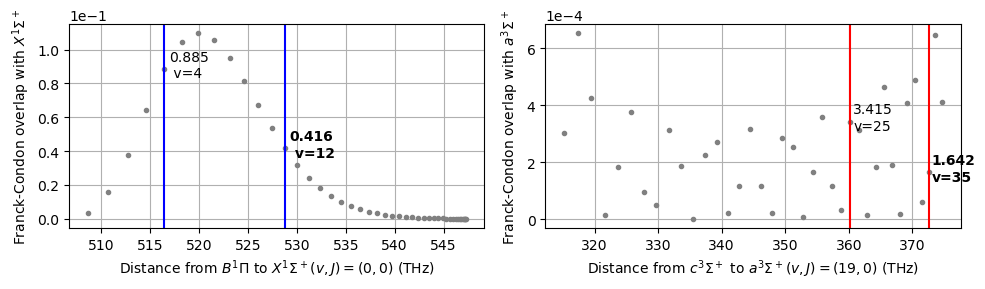

In [2814]:
# plot FC factors from (a3 v=19) to (c3) and (B1) to (X1 v=0) vs transition frequency (THz), all J=J'=0
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

# highlight B1Pi states with v = 4, 12
ax1.plot(B1Pi_J_0_df['En_THz']-X1SigmaPlus_J_0_df['En_THz'][0], FC_X1SigmaPlus_B1Pi_JJ_00[0], 'o', 
         markersize=3, color='gray', label='$v=0, \, X^1\Sigma^+ - B^1\Pi$')
ax1.axvline(B1Pi_J_0_df['En_THz'][4]  -X1SigmaPlus_J_0_df['En_THz'][0], color='blue')
ax1.axvline(B1Pi_J_0_df['En_THz'][12] -X1SigmaPlus_J_0_df['En_THz'][0], color='blue')
ax1.ticklabel_format(style='sci',scilimits=(-1,1),axis='y')
ax1.text(B1Pi_J_0_df['En_THz'][4]  -X1SigmaPlus_J_0_df['En_THz'][0]+0.5, FC_X1SigmaPlus_B1Pi_JJ_00[0][4]  +0.005, 
         s= "{:.3f}".format(1e1*FC_X1SigmaPlus_B1Pi_JJ_00[0][4] ))
ax1.text(B1Pi_J_0_df['En_THz'][4]  -X1SigmaPlus_J_0_df['En_THz'][0]+0.5, FC_X1SigmaPlus_B1Pi_JJ_00[0][4]  -0.005, 
         s= ' v=4' )
ax1.text(B1Pi_J_0_df['En_THz'][12] -X1SigmaPlus_J_0_df['En_THz'][0]+0.5, FC_X1SigmaPlus_B1Pi_JJ_00[0][12] +0.005, 
         s= "{:.3f}".format(1e1*FC_X1SigmaPlus_B1Pi_JJ_00[0][12]), fontweight='semibold')
ax1.text(B1Pi_J_0_df['En_THz'][12] -X1SigmaPlus_J_0_df['En_THz'][0]+0.5, FC_X1SigmaPlus_B1Pi_JJ_00[0][12] -0.005, 
         s= ' v=12', fontweight='semibold')
ax1.set_xlabel('Distance from $B^1\Pi$ to $X^1\Sigma^+ (v,J)=(0,0)$ (THz)')
ax1.set_ylabel('Franck-Condon overlap with $X^1\Sigma^+$')
ax1.grid()

# highlight c3SigmaPlus states with v = 25, 35
ax2.plot(c3SigmaPlus_J_0_df['En_THz']-a3SigmaPlus_J_0_df['En_THz'][19], FC_a3SigmaPlus_c3SigmaPlus_JJ_00[19], 'o', 
         markersize=3, color='gray', label='$v=0, \, a^3\Sigma^+ - c^3\Sigma^+$')
ax2.axvline(c3SigmaPlus_J_0_df['En_THz'][25] - a3SigmaPlus_J_0_df['En_THz'][19], color='red')
ax2.axvline(c3SigmaPlus_J_0_df['En_THz'][35] - a3SigmaPlus_J_0_df['En_THz'][19], color='red')
ax2.text(c3SigmaPlus_J_0_df['En_THz'][25]-a3SigmaPlus_J_0_df['En_THz'][19]+0.5, FC_a3SigmaPlus_c3SigmaPlus_JJ_00[19][25]+3e-5, 
         s= "{:.3f}".format(1e4*FC_a3SigmaPlus_c3SigmaPlus_JJ_00[19][25]))
ax2.text(c3SigmaPlus_J_0_df['En_THz'][25]-a3SigmaPlus_J_0_df['En_THz'][19]+0.5, FC_a3SigmaPlus_c3SigmaPlus_JJ_00[19][25]-3e-5, 
         s= 'v=25')
ax2.text(c3SigmaPlus_J_0_df['En_THz'][35]-a3SigmaPlus_J_0_df['En_THz'][19]+0.5, FC_a3SigmaPlus_c3SigmaPlus_JJ_00[19][35]+3e-5, 
         s= "{:.3f}".format(1e4*FC_a3SigmaPlus_c3SigmaPlus_JJ_00[19][35]), fontweight='semibold')
ax2.text(c3SigmaPlus_J_0_df['En_THz'][35]-a3SigmaPlus_J_0_df['En_THz'][19]+0.5, FC_a3SigmaPlus_c3SigmaPlus_JJ_00[19][35]-3e-5, 
         s= 'v=35', fontweight='semibold')
ax2.ticklabel_format(style='sci',scilimits=(-1,1),axis='y')
ax2.set_xlabel('Distance from $c^3\Sigma^+$ to $a^3\Sigma^+ (v,J) = (19,0)$ (THz)')
ax2.set_ylabel('Franck-Condon overlap with $a^3\Sigma^+$')
ax2.grid()

plt.tight_layout()
plt.show()

## <font size=4, color='blue'>Plot relevant wavefunctions (J = 0 suffices)</font>

The wavefunctions have negligible change with the inclusion of $J\neq 0$. As a result, we only plot the wavefunctions for $J=0$.

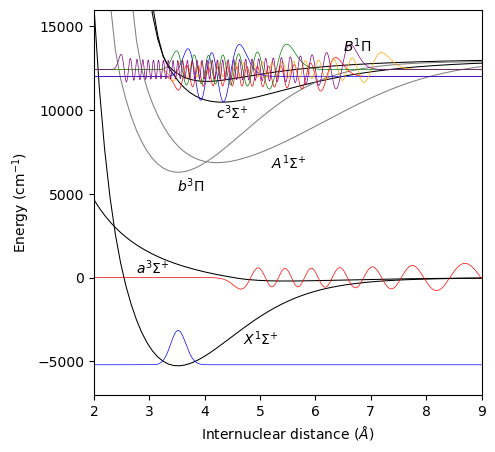

In [2815]:
# plot wfns and potentials from calculated dataframes
v_X1SP = 0        # absolute ground state, vibrational quantum number = 0
v_a3SP = 19       # FB molecule, vibration quantum number = 19
v_c3SP = 25       # should be 25 according to Martin's calc based on spec data
v_B1Pi = 4        # should be 4 according to Martin's calc based on spec data
v_c3SP_new = 35
v_B1Pi_new = 12
v_b3Pi_new = 66

# initialize figures
fig, ax = plt.subplots(figsize=(5,5))

# plot potentials
ax.plot(r[::100], X1SigmaPlus_J_0_df['potential'][0][::100],'k',linewidth=0.75)
ax.plot(r[::100], a3SigmaPlus_J_0_df['potential'][0][::100],'k',linewidth=0.75)
ax.plot(r[::100], B1Pi_J_0_df['potential'][0][::100],       'k',linewidth=0.75)
ax.plot(r[::100], c3SigmaPlus_J_0_df['potential'][0][::100],'k',linewidth=0.75)
ax.plot(r[::100], b3Pi_J_0_df['potential'][0][::100],       '0.5',linewidth=0.75)
ax.plot(r[::100], A1SigmaPlus_J_0_df['potential'][0][::100],'0.5',linewidth=0.75)

# label potentials
ax.annotate('$X^{1}\Sigma^{+}$', xy = (4.7,  -4000), xytext = (4.7,  -4000))
ax.annotate('$a^{3}\Sigma^{+}$', xy = (2.75  , 250), xytext = (2.75  , 250))
ax.annotate('$c^{3}\Sigma^{+}$', xy = (4.2,   9500), xytext = (4.2,   9500))
ax.annotate('$B^{1}\Pi$',        xy = (6.5,  13500), xytext = (6.5,  13500))
ax.annotate('$b^{3}\Pi$',        xy = (3.5,   5100), xytext = (3.5,   5100))
ax.annotate('$A^{1}\Sigma^{+}$', xy = (5.2,   6500), xytext = (5.2,   6500))

# scale and plot relevant wavefunctions:
scale_X1SP = max(X1SigmaPlus_J_0_df['wfn_NC'][v_X1SP])*500
ax.plot(r,scale_X1SP*X1SigmaPlus_J_0_df['wfn_NC'][v_X1SP]+X1SigmaPlus_J_0_df['En_NC'][v_X1SP], 'blue',linewidth=0.5)
scale_a3SP = max(a3SigmaPlus_J_0_df['wfn_NC'][v_a3SP])*20000
ax.plot(r,scale_a3SP*a3SigmaPlus_J_0_df['wfn_NC'][v_a3SP]+a3SigmaPlus_J_0_df['En_NC'][v_a3SP], 'red',linewidth=0.5)
scale_c3SP = max(c3SigmaPlus_J_0_df['wfn_NC'][v_c3SP])*800
ax.plot(r,scale_c3SP*c3SigmaPlus_J_0_df['wfn_NC'][v_c3SP]+c3SigmaPlus_J_0_df['En_NC'][v_c3SP], 'red',linewidth=0.5)
scale_B1Pi = max(B1Pi_J_0_df['wfn_NC'][v_B1Pi])*1000
ax.plot(r,scale_B1Pi*B1Pi_J_0_df['wfn_NC'][v_B1Pi]+B1Pi_J_0_df['En_NC'][v_B1Pi], 'blue',linewidth=0.5)
scale_c3SP_new = max(c3SigmaPlus_J_0_df['wfn_NC'][v_c3SP_new])*800
ax.plot(r,scale_c3SP_new*c3SigmaPlus_J_0_df['wfn_NC'][v_c3SP_new]+c3SigmaPlus_J_0_df['En_NC'][v_c3SP_new], 'orange',linewidth=0.5)
scale_B1Pi_new = max(B1Pi_J_0_df['wfn_NC'][v_B1Pi_new])*1000
ax.plot(r,scale_B1Pi_new*B1Pi_J_0_df['wfn_NC'][v_B1Pi_new]+B1Pi_J_0_df['En_NC'][v_B1Pi_new], 'green',linewidth=0.5)
scale_b3Pi_new = max(b3Pi_J_0_df['wfn_NC'][v_b3Pi_new])*1000
ax.plot(r,scale_b3Pi_new*b3Pi_J_0_df['wfn_NC'][v_b3Pi_new]+b3Pi_J_0_df['En_NC'][v_b3Pi_new], 'purple',linewidth=0.5)

plt.xlim([2.0, 9])
plt.ylim([-7000, 16000])
plt.xlabel('Internuclear distance ($\AA$)')
plt.ylabel('Energy (cm$^{-1}$)')
plt.show()

## <font size=4, color='blue'>Calculate bound state energies and PA lines (J = 0 suffices)</font>

In [2816]:
# get PA lines in cm-1 for j=0
PA_lines_Na40K_c3SigmaPlus_cm1 = bound_state_energy_cm1(potential = 'c3SigmaPlus', j=0,  mass_scaled=True)
PA_lines_Na40K_A1SigmaPlus_cm1 = bound_state_energy_cm1(potential = 'A1SigmaPlus', j=0, mass_scaled=True)
PA_lines_Na40K_B1Pi_cm1        = bound_state_energy_cm1(potential = 'B1Pi',        j=0, mass_scaled=True)
PA_lines_Na40K_b3Pi_cm1        = bound_state_energy_cm1(potential = 'b3Pi',        j=0, mass_scaled=True)

Consider the two potentials $B^1 \Pi$ and $c^3 \Sigma^+$. Here we will find some PA lines that are nearly degenerate. These pairs of PA lines result in complexes when we do STIRAP. The question is which pair of complexes do we actually use in the experiment? Is it the $(35,12)$ or is it the $(25, 4)$ complex? We use the complex $\ket{c^3 \Sigma^+, \nu = 35, J=1} \sim \ket{B^1\Pi, \nu = 12, J=1}$. The results below are actually for $J=0$, but there is negligible change with the inclusion of $J=1,2$.

In [2817]:
# what two PA lines in the c3SigmaPlus and B1Pi potential are most similar:
difference = np.Inf
pair = [-1,-1]

difference_array = np.array([abs(PA_lines_Na40K_c3SigmaPlus_cm1[0] - PA_lines_Na40K_B1Pi_cm1[0])])
pair_array       = np.array([[0,0]])

for i in range(1, PA_lines_Na40K_c3SigmaPlus_cm1.shape[0]):
    for j in range(1, PA_lines_Na40K_B1Pi_cm1.shape[0]):
        difference = abs(PA_lines_Na40K_c3SigmaPlus_cm1[i] - PA_lines_Na40K_B1Pi_cm1[j])
        pair = np.array([i, j])
        difference_array = np.append(difference_array, difference)
        pair_array = np.append(pair_array, [pair], axis=0)

sort_difference = np.argsort(difference_array)
print('First few nearest pairs:')
print(pair_array[sort_difference][0:3])
print(difference_array[sort_difference][0:3])

First few nearest pairs:
[[35 12]
 [25  4]
 [30  8]]
[0.06790354 0.88464648 3.91208   ]


## <font size=4, color='blue'>c3SigmaPlus (v = 35) and B1Pi (v = 12), all J's = 0</font>

In [2818]:
# Print all merits with all states in J = 0
print('----- FC factors: ---------------------------------')
print('FC a3SP (19) - c3SP (35): ' + str(FC_a3SigmaPlus_c3SigmaPlus_JJ_00[19][35]))
print('FC a3SP (19) - B1Pi (12): ' + str(FC_a3SigmaPlus_B1Pi_JJ_00[19][12]))
print('FC X1SP (19) - c3SP (35): ' + str(FC_X1SigmaPlus_c3SigmaPlus_JJ_00[0][35]))
print('FC X1SP (19) - B1Pi (12): ' + str(FC_X1SigmaPlus_B1Pi_JJ_00[0][12]))

print('')
print('- Spectral lines from FB state to absolute ground state (nm):')
print('a3SP (19) to c3SP (35): ' + str(cm1_to_nm(PA_lines_Na40K_c3SigmaPlus_cm1[35] - a3SigmaPlus_J_0_df['En_NC'][19])))
print('a3SP (19) to B1Pi (12): ' + str(cm1_to_nm(PA_lines_Na40K_B1Pi_cm1[12]        - a3SigmaPlus_J_0_df['En_NC'][19])))
print('X1SP (0)  to c3SP (35): ' + str(cm1_to_nm(PA_lines_Na40K_c3SigmaPlus_cm1[35] - X1SigmaPlus_J_0_df['En_NC'][0])))
print('X1SP (0)  to B1Pi (12): ' + str(cm1_to_nm(PA_lines_Na40K_B1Pi_cm1[12]        - X1SigmaPlus_J_0_df['En_NC'][0])))
print('')
print('- Spectral lines from FB state to absolute ground state (THz):')
print('a3SP (19) to c3SP (35): ' + str(cm1_to_THz(PA_lines_Na40K_c3SigmaPlus_cm1[35] - a3SigmaPlus_J_0_df['En_NC'][19])))
print('a3SP (19) to B1Pi (12): ' + str(cm1_to_THz(PA_lines_Na40K_B1Pi_cm1[12]        - a3SigmaPlus_J_0_df['En_NC'][19])))
print('X1SP (0)  to c3SP (35): ' + str(cm1_to_THz(PA_lines_Na40K_c3SigmaPlus_cm1[35] - X1SigmaPlus_J_0_df['En_NC'][0])))
print('X1SP (0)  to B1Pi (12): ' + str(cm1_to_THz(PA_lines_Na40K_B1Pi_cm1[12]        - X1SigmaPlus_J_0_df['En_NC'][0])))

print('')
print('----- Omega: ---------------------------------')


----- FC factors: ---------------------------------
FC a3SP (19) - c3SP (35): 0.00016418418563579992
FC a3SP (19) - B1Pi (12): 0.0003545667421916962
FC X1SP (19) - c3SP (35): 0.01002147779458962
FC X1SP (19) - B1Pi (12): 0.041622854641685816

- Spectral lines from FB state to absolute ground state (nm):
a3SP (19) to c3SP (35): 564.9251577204815
a3SP (19) to B1Pi (12): 564.9229906521523
X1SP (0)  to c3SP (35): 436.4223863342049
X1SP (0)  to B1Pi (12): 436.4210930165909

- Spectral lines from FB state to absolute ground state (THz):
a3SP (19) to c3SP (35): 530.6764159870074
a3SP (19) to B1Pi (12): 530.6784516840372
X1SP (0)  to c3SP (35): 686.9318976007431
X1SP (0)  to B1Pi (12): 686.933933297773

----- Omega: ---------------------------------


# <font size=5, color='black'>NaK fine structure calculator </font>

## <font size=4, color='blue'>Notes on molecular quantum numbers</font>

Before we even start, let us give a brief overview of molecular physics. The Hamiltonian of a rotating molecule is given by 
$$ H_0 = H_e + H_v + H_r + H_{SO}$$
where $H_e$ is the electronic part, $H_v$ is the vibrational part, $H_r$ is the rotational part, and $H_{SO}$ is the spin-orbit interaction. A molecular basis function may take the form $\ket{\Lambda}\ket{S\Sigma} \ket{v} \ket{J\Omega M}$. The first part, $\ket{\Lambda}\ket{S\Sigma}\ket{v}$ is a wavefunction for a nonrotating molecule: $v$ is the vibrational level, and $\Lambda, \Sigma$ represent the projection of the total electronic orbital angular momentum $\vec{L}$ and the total electronic spin angular momentum $\vec{S}$ along the internuclear axis, respectively. What we have worked on so far concerns almost exclusively this first part of the molecular wavefunction. We also played around a bit with calculations for $J \neq 0$. However, it is not clear how various lines will show up on, say, PA spectra of Feshbach molecules. 

The rotational part is $\ket{J\Omega M_J}$, which is expressed in the lab frame. $J$ represents the total angular momentum and $M_J$ represents its projection along the lab $z$-axis. To further understand the rotational part of the molecular wavefunction, we must first understand Hund's cases. There are two Hund's cases that are relevant for what we do: (a) and (b).

In Hund's case (a), the orbital and spin angular momenta are strongly coupled to the internuclear axis via the strong electrostatic interaction between the electrons and the nuclei (causing $\vec{L}$ to precess around the internuclear axis) and the strong spin-orbit coupling between $\vec{L}$ and $\vec{S}$ (causing $\vec{S}$ to also precess around the internuclear axis). This defines the quantum numbers $\Lambda$ and $\Sigma$ which are projections of $\vec{L}$ and $\vec{S}$, respectively. These two define $\Omega = \Lambda + \Sigma$, the total electronic angular momentum along the internuclear axis. $\vec{\Omega}$ is then coupled to the end-over-end rotational angular momentum of the molecule $\vec{R}$ to give $\vec{J}$, the total angular momentum. The good quantum nummbers for Hund's cases (a) are therefore $\Lambda, \Sigma, \Omega, S, J$. For practical purposes, the electronic states $B^1 \Pi$ and $b^3\Pi$ fall into Hund's case (a).
- One thing to note about the $^1\Pi$ state: since $\Lambda = 1, S = 1$, and $J = \Sigma + \Lambda + R$, the lowest possible value for $J$ is $J=1$. Thus, $J=1$ actually describes non-rotating molecule ($R=0$).

In Hund's case (b), the spin-orbit coupling between $\vec{L}$ and $\vec{S}$ is weaker. As a result, $\Sigma$ is undefined and neither is $\Omega$. Because of this, $\vec{R}$ is coupled with $\Lambda$ (rotation-orbit coupling) to produce $\vec{N} = \vec{R} + \Lambda \hat{\alpha}$: the sum of rotational and orbital angular momentum. This angular momentum then couples with $\vec{S}$ to give $\vec{J}$, the total angular momentum, $\vec{J} = \vec{N} + \vec{S}$. The good quantum numbers are thus $\Lambda, N, S, J$. For practical purposes, the electronic states $X^1\Sigma^+, a^3 \Sigma^+, c^3 \Sigma^+$ fall into this category. 

Following from this short discussion, we also see that the $J$ number in $E(v,J)$ is not sufficient to explain obsreved spectra. While the $J\neq 0$ data is good for accounting for rovibrational levels (a good example is the 5.64 GHz splitting between the $J=0$ and $J=1$ states in the $v=0$ vibrational manifold of the $X^1\Sigma^+$ potential), we will need to carefully study the fine and hyperfine structure of NaK.

## <font size=4, color='blue'>Fine-structure Hamiltonian near 372 THz/804 nm</font>

Feshbach molecules are highest-lying bound state of the $a^3\Sigma^+$ potential with belongs to Hund's case (b). Since $S=1$, we have that a rotationless Feshbach molecule has can be described by the quantum numbers $N=0$ and $J=1$. With this, let us write the Feshbach molecule wavefunction as $\ket{a^3 \Sigma^+, v=19, N = 0, J=1}$. 

What are the states in the excited state manifold that the Feshbach state can couple to? There are complicated reasons behind which states are available to be coupled, but the answer is that there are four states in the $c^3\Sigma^+$ manifold, two in the $B^1\Pi$ manifold, and two in the $b^3\Pi$ manifold. More specifically, these are $\ket{c^3\Sigma^+, v = 35, N = 1, J = 0,1,2}$, $\ket{c^3\Sigma^+, v = 35, N = 3, J=2}$, $\ket{B^1\Pi, v = 12, J=1, e}$, $\ket{B^1\Pi, v = 12, J=2, f}$, $\ket{b^3\Pi, v = 66, J=0, f}$, $\ket{b^3\Pi, v = 66, J=1, e}$, $\ket{b^3\Pi, v = 66, J = 2, f}$. These states are all mixed due to spin-orbit, spin-spin, and spin-rotation couplings, giving rise to what's called "perturbations" of spectral lines. Here, it is our job to determine what these mixtures are, based on the coupling strengths. To this end, we order the states above into a basis and let us attempt to construct a Hamiltonian. 

The fine-structure Hamiltoniain of the perturbed $B\sim c \sim b$ complex is given by 
$$ H_{fine} = H_0^B + H_0^c + H_0^b + H^c_{SS} + H^c_{SR} + H^{Bc}_{SO} + H^{bc}_{SO} $$
Let's decode this. 
- The first three terms in the Hamiltonian are simply the energies $E^{B,c,b}$ of the deperturbed vibrational levels and their rotational energies, with rotational constants $B_{B,c,b}$. Specifically, $E_B$ is the deperturbed energy for $\ket{B^1\Pi, J=1}$, $E_c$ is the deperturbed energy for $\ket{c^3\Sigma^+, N=1,J=1}$, and $E_b$ is the deperturbed energy for $\ket{b^3\Pi, J=0}$. These can already be calculated from the spectroscopic data and Dunham coefficients. 
- Within the $c^3\Sigma^+$ potential, there is spin-spin coupling with strength $\lambda$ between the states $\ket{c^3\Sigma^+, N=1,J=2}$ and $\ket{c^3\Sigma^+, N=3, J=2}$ as well as weak spin-rotation coupling with strength $\gamma$. 
- States $B^1\Pi$ and $c^3\Sigma^+$ are coupled via spin-orbit interaction with strength $\xi_{Bc}$. Similarly, states $c^3\Sigma^+$ and $b^3\Pi$ are coupled via spin-orbit interaction with strength $\xi_{bc}$.

Because of the perturbations above conserve $J$, i.e. there is no matrix element with $\Delta J \neq 0$, the Hamiltonian is block-diagonal if we arrange the basis into $J$-subspaces. 
- For $J=0$, the sub-basis is the set $\{ \ket{c^3\Sigma^+, v=35, N=1,J=0}, \ket{b^3\Pi, v=66, J=0}\}$. 
- For $J=1$, the sub-basis is the set $\{\ket{B^1\Pi, v=12, J=1}, \ket{c^3\Sigma^+, v=35, N=1, J=1} \}$.
- For $J=2$, the sub-basis is the set $\{\ket{B^1\Pi, v=12, J=2}, \ket{c^3\Sigma^+, v=35, N=1,J=2}, \ket{c^3\Sigma^+, v=35 , N=3,J=2}, \ket{b^3\Pi, v=66, J=2} \}$.

Here we construct the sub-Hamiltonians $H_{J=0}, H_{J=1}, H_{J=2}$ for which $H = H_{J=0} \oplus H_{J=1} \oplus H_{J=2}$: 
$$ H_{J=0} = \begin{pmatrix}  E_c - \gamma - 2\lambda & -\sqrt{2} \xi_{bc} \\ -\sqrt{2}\xi_{bc} & E_b  \end{pmatrix}$$
$$ H_{J=1} = \begin{pmatrix}  E_B & \xi_{Bc, J=1} \\ \xi_{Bc, J=1} & E_c   \end{pmatrix}$$
$$ H_{J=2} = \begin{pmatrix}  E_B + 4 B_B & \sqrt{3/5} \xi_{Bc, J=2} & \sqrt{2/5}\xi_{Bc, J=2} & 0 \\ 
\sqrt{3/5}\xi_{Bc, J=2} & E_c + 2\gamma -4\lambda/5 & 2\sqrt{6} \lambda /5 & \sqrt{4/5} \xi_{bc} \\
\sqrt{2/5}\xi_{Bc, J=2} & 2\sqrt{6} \lambda /5 & E_c + 10 B_c -3 \gamma -6\lambda/5 & -\sqrt{6/5} \xi_{bc} \\
0 & \sqrt{4/5} \xi_{bc} & -\sqrt{6/5} \xi_{bc} & E_b + 6 B_b
\end{pmatrix} $$

The construction above follows from JWP's 2015 paper and thesis, where the energy terms are re-defined and shifted (you will find the re-definitions in the code below). The code also includes extra (but small) interactions given by the $b^3\Pi_{0,1,2}$ levels and the weak $L$-uncoupling. It is possible to re-write the Hamiltonians above to include all terms in the calculation, but it would be a bit cumbersome for the notebook. Using JWP's constants (Table 4.2 of JWP's thesis), one can reproduce the found lines quite well.

## <font size=4, color='blue'>Calculate fine structure of NaK, explaining PA lines near 372 THz/804 nm</font>

PA lines near 372 THz/804 nm are due to the mixing of $\ket{c^3\Sigma^+, v = 35, N = 1, J = 0,1,2}$, $\ket{c^3\Sigma^+, v = 35, N = 3, J=2}$, $\ket{B^1\Pi, v = 12, J=1, e}$, $\ket{B^1\Pi, v = 12, J=2, f}$, $\ket{b^3\Pi, v = 66, J=0, f}$, $\ket{b^3\Pi, v = 66, J=1, e}$, $\ket{b^3\Pi, v = 66, J = 2, f}$. The principal splitting is due to the differences in the deperturbed energy levels $E_{B,c,b}$ and their corresponding rotational constants $B_{B,c,b}$. These can be calculated directly either from Dunham coefficients (which give better match to experimental data) or from bound-state energies calculated using Numerov-Cooley integration (results are within 0.5 $\text{cm}^{-1}$ but not as well-matched to experimental data). Note however that the deperturbed energy level $v=66$ of the $b^3\Pi$ potential lies outside the validity of Dunham coefficients and therefore can only be found via Numerov-Cooley. 

In practice, even though these energy levels can be found from calculations, ultimately they must be varied along with all coupling constants in order to provide a good match with experimental data of the fine-structure. As a result, the Hamiltonian that is to be generated below uses constants that have been empirically varied for this purpose. One will see that the deviation from the calculated values are small but not insignificant (average line shifts on the order of 1 GHz). 

In [2819]:
# obtain fine-structure perturbation of the (B1Pi, 12) + (c3SP, 35) + (b3Pi, 66) complex:
def fine_structure_B1Pi_12_c3SP_35_b3Pi_66():

    # THz center:
    THZ_center = 372

    E_B = 0*17701.478378254094 + 17701.427                                                                  
    E_c = 0*17701.35467879664  + 17701.074                                                                  
    E_b = 0*17710.71202147651  + 17699.680                                                                  
    B_B = rotational_constant(   potential = 'B1Pi',        v=12, mass_scaled=True)  
    B_c = rotational_constant(   potential = 'c3SigmaPlus', v=35, mass_scaled=True)  
    B_b = rotational_constant(   potential = 'b3Pi',        v=66, mass_scaled=True)  
    Xi_Bc_J_1 = 0*0.6 + 0.5899                                                             
    Xi_Bc_J_2 = 0*0.6 + 0.5833                                                               
    Xi_bc     = 0*2.0 + 0.68                                                               
    lambda_SS = 0*0.6 + -0.55                                                                 
    gamma_SR  = 0*0.0124 + 0.0215                                                         
    B_L       = 0.006
    A = 15.557 - 0.0112*(66 + 1/2)   # (http : // iopscience . iop . org/0022 - 3700/19/10/014)
    J0 = 0
    J1 = 1
    J2 = 2

    # redefine constants to match JWP's constants (2015 paper):
    E_c = E_c - B_c*1*(1+1) + gamma_SR - (2/3)*lambda_SS 
    E_b = E_b + A - B_b*(J0*(J0+1)+1) 
    E_B = E_B - B_B*(J1*(J1+1)-1) 

    # the generation of the matrices below follows Ishikawa 1992: "Hyperfine structure of the NaK..."

    # J = 0
    # basis states: (c3, N=1, J=0) and (b3, J=0)
    H_J_0 = np.array([[E_c + B_c*1*(1+1) - (J0+2)*gamma_SR-(2/3)*lambda_SS*(J0+2)/(2*J0+1) ,  -np.sqrt(2*(J0+1)/(2*J0+1))*Xi_bc - J0*np.sqrt((J0+1)/(2*J0+1))*B_L ],
                      [-np.sqrt(2*(J0+1)/(2*J0+1))*Xi_bc - J0*np.sqrt((J0+1)/(2*J0+1))*B_L , E_b - A + B_b*(J0*(J0+1)+1) ]])    
    
    # J = 1
    # basis states: (B1, J=1), (c3, N=1, J=1), (b3Pi0, J=1), (b3Pi1, J=1)
    H_J_1 = np.array([[E_B + B_B*(J1*(J1+1)-1), Xi_Bc_J_1                                   , 0                          , 0],
                      [Xi_Bc_J_1              , E_c + B_c*1*(1+1)-gamma_SR+(2/3)*lambda_SS  , np.sqrt(J1*(J1+1))*B_L     , Xi_bc],
                      [0                      , np.sqrt(J1*(J1+1))*B_L                      , E_b - A + B_b*(J1*(J1+1)+1), 0   ],
                      [0                      , Xi_bc                                       , 0                          , E_b + B_b*(J1*(J1+1)+1)]])
    
    # J = 2
    # basis states: (B1, J=2), (c3, N=1,J=2), (c3,N=3,J=2), (b3Pi0,J=2), (b3Pi1,J=2), (b3Pi2,J=2)
    H_J_2_00 = E_B + B_B*(J2*(J2+1)-1)
    H_J_2_01 = np.sqrt((J2+1)/(2*J2+1))*Xi_Bc_J_2
    H_J_2_02 = np.sqrt(J2/(2*J2+1))*Xi_Bc_J_2
    H_J_2_11 = E_c + B_c*1*(1+1) + (J2 - 1)*gamma_SR - ((J2 - 1)/(2*J2 + 1))*(2/3)*lambda_SS # N = 1
    H_J_2_12 = 3*np.sqrt(J2*(J2 + 1))/(2*J2 + 1) * (2/3) * lambda_SS
    H_J_2_13 = np.sqrt((2*J2)/(2*J2 + 1)) * Xi_bc - (J2 + 1)*np.sqrt(J2/(2*J2 + 1))*B_L
    H_J_2_14 = np.sqrt((J2 + 1)/(2*J2 + 1))*Xi_bc - J2*np.sqrt((2*(J2 + 1))/(2*J2 + 1))* B_L
    H_J_2_15 = -np.sqrt((((J2 + 1) * (J2 * (J2 + 1) - 2))/(2*J2 + 1)))* B_L
    H_J_2_22 = E_c + B_c*3*(3+1) - (J2 + 2)*gamma_SR - ((J2 + 2)/(2*J2 + 1))*(2/3)*lambda_SS # N = 3
    H_J_2_23 = -np.sqrt(((2*(J2 + 1))/(2*J2 + 1)))*Xi_bc - J2* np.sqrt((J2 + 1)/(2*J2 + 1))*B_L
    H_J_2_24 = np.sqrt(J2/(2*J2 + 1))*Xi_bc + (J2 + 1)*np.sqrt( (2*J2) / (2*J2 + 1)) * B_L
    H_J_2_25 = -np.sqrt(((J2* (J2* (J2 + 1) - 2))/(2*J2 + 1)))* B_L
    H_J_2_33 = E_b - A + B_b*(J2*(J2+1)+1)
    H_J_2_44 = E_b + B_b*(J2*(J2+1)+1)
    H_J_2_55 = E_b + A + B_b*(J2*(J2+1)+1)

    H_J_2 = np.array([[H_J_2_00, H_J_2_01, H_J_2_02, 0       , 0       , 0],
                      [H_J_2_01, H_J_2_11, H_J_2_12, H_J_2_13, H_J_2_14, H_J_2_15],
                      [H_J_2_02, H_J_2_12, H_J_2_22, H_J_2_23, H_J_2_24, H_J_2_25],
                      [0       , H_J_2_13, H_J_2_23, H_J_2_33, 0       , 0],
                      [0       , H_J_2_14, H_J_2_24, 0       , H_J_2_44, 0],
                      [0       , H_J_2_15, H_J_2_25, 0       , 0       , H_J_2_55]])
        
    # now solve: 
    energies_J_0, mixed_states_J_0 = np.linalg.eigh(H_J_0) 
    lines_near_372THz_804nm_J_0 = cm1_to_THz(energies_J_0 - DeX)
    energies_J_1, mixed_states_J_1 = np.linalg.eigh(H_J_1) 
    lines_near_372THz_804nm_J_1 = cm1_to_THz(energies_J_1 - DeX)
    energies_J_2, mixed_states_J_2 = np.linalg.eigh(H_J_2)
    lines_near_372THz_804nm_J_2 = cm1_to_THz(energies_J_2 - DeX)

    mixed_states_J_0 = np.transpose(mixed_states_J_0)    
    mixed_states_J_1 = np.transpose(mixed_states_J_1)
    mixed_states_J_2 = np.transpose(mixed_states_J_2)

    # obtain state decomposition:
    # J = 0
    J0_contributions = []
    for i in range(mixed_states_J_0.shape[0]):
        contributions = (mixed_states_J_0[i] / np.linalg.norm(mixed_states_J_0[i]))**2
        c3SP_contribution = 0
        b3Pi_contribution = 0
        B1Pi_contribution = 0
        for j in range(len(mixed_states_J_0[i])):
            if j==0:
                c3SP_contribution += contributions[j]
            elif j==1:
                b3Pi_contribution += contributions[j]
            else:
                B1Pi_contribution += contributions[j]
        J0_contributions.append((c3SP_contribution, B1Pi_contribution, b3Pi_contribution))

    # J = 1
    J1_contributions = []
    for i in range(mixed_states_J_1.shape[0]):
        contributions = (mixed_states_J_1[i] / np.linalg.norm(mixed_states_J_1[i]))**2
        c3SP_contribution = 0
        b3Pi_contribution = 0
        B1Pi_contribution = 0
        for j in range(len(mixed_states_J_1[i])):
            if j==1:
                c3SP_contribution += contributions[j]
            elif j==0:
                B1Pi_contribution += contributions[j]
            else:
                b3Pi_contribution += contributions[j]
        J1_contributions.append((c3SP_contribution, B1Pi_contribution, b3Pi_contribution))

    # J = 2
    J2_contributions = []
    for i in range(mixed_states_J_2.shape[0]):
        contributions = (mixed_states_J_2[i] / np.linalg.norm(mixed_states_J_2[i]))**2
        c3SP_contribution = 0
        b3Pi_contribution = 0
        B1Pi_contribution = 0
        for j in range(len(mixed_states_J_2[i])):
            if j==1 or j==2:
                c3SP_contribution += contributions[j]
            elif j==0:
                B1Pi_contribution += contributions[j]
            else:
                b3Pi_contribution += contributions[j]
        J2_contributions.append((c3SP_contribution, B1Pi_contribution, b3Pi_contribution))

    # label state decomposition next to PA lines:
    fig, ax = plt.subplots(figsize=(13,2.5))
    
    for i in range(H_J_0.shape[0]):
        ax.axvline( (lines_near_372THz_804nm_J_0[i] - THZ_center)*1e3, color='red', label='J=0' if i == 0 else "")
        ax.text((lines_near_372THz_804nm_J_0[i] - THZ_center)*1e3+1.0, 0.1, fontsize='small',
                s= 'c3S+: ' + "{:.0f}".format(J0_contributions[i][0]*100) + '%' +
                '\nB1Pi: ' +  "{:.0f}".format(J0_contributions[i][1]*100) + '%' +
                '\nb3Pi: ' +  "{:.0f}".format(J0_contributions[i][2]*100) + '%' if i == 0 
                else 
                "{:.0f}".format(J0_contributions[i][0]*100) + '%' +
                '\n' +  "{:.0f}".format(J0_contributions[i][1]*100) + '%' +
                '\n' +  "{:.0f}".format(J0_contributions[i][2]*100) + '%')
        ax.text((lines_near_372THz_804nm_J_0[i] - THZ_center)*1e3+1.0, 0.8, s='J=0', fontsize = 'small') 
    for i in range(H_J_1.shape[0]):
        if (lines_near_372THz_804nm_J_1[i] - THZ_center)*1e3 < 620:
            ax.axvline( (lines_near_372THz_804nm_J_1[i] - THZ_center)*1e3, color='green', label='J=1' if i == 0 else "")
            ax.text((lines_near_372THz_804nm_J_1[i] - THZ_center)*1e3+1.0, 0.1, fontsize = 'small',
                    s= "{:.0f}".format(J1_contributions[i][0]*100) + '%' +
                    '\n' +"{:.0f}".format(J1_contributions[i][1]*100) + '%' +
                    '\n' +"{:.0f}".format(J1_contributions[i][2]*100) + '%')
            ax.text((lines_near_372THz_804nm_J_1[i] - THZ_center)*1e3+1.0, 0.8, s='J=1', fontsize='small')  
    for i in range(H_J_2.shape[0]):
        if  (lines_near_372THz_804nm_J_2[i] - THZ_center)*1e3 < 620:
            ax.axvline( (lines_near_372THz_804nm_J_2[i] - THZ_center)*1e3, color='blue', label = 'J=2' if i == 0 else "")
            ax.text((lines_near_372THz_804nm_J_2[i] - THZ_center)*1e3+1.0, 0.1, fontsize='small',
                    s= "{:.0f}".format(J2_contributions[i][0]*100) + '%' +
                    '\n' +  "{:.0f}".format(J2_contributions[i][1]*100) + '%' +
                    '\n' +  "{:.0f}".format(J2_contributions[i][2]*100) + '%')
            ax.text((lines_near_372THz_804nm_J_2[i] - THZ_center)*1e3+1.0, 0.8, s= 'J=2', fontsize='small')
    # plot also found lines:
    found_lines = [17699.4, 17700.6,  17700.8, 17701.9, 17702.0, 17702.5, 17702.8]
    for i in range(len(found_lines)):
        ax.axvline( (cm1_to_THz(found_lines[i]) - cm1_to_THz(DeX) - THZ_center)*1e3, color='black', label='Found lines' if i == 0 else "")
    
    
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    plt.xlim([510, 620])
    plt.xticks([510,520,530,540,550,560,570,580,590,600,610,620])
    plt.show()

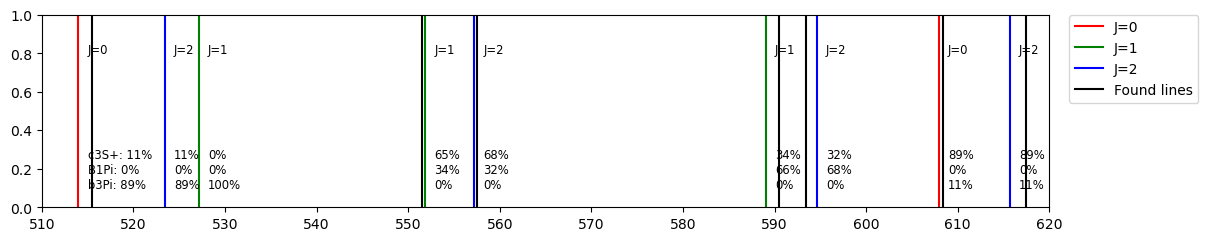

In [2821]:
fine_structure_B1Pi_12_c3SP_35_b3Pi_66()

# <font size=5, color='black'>NaK rotational and hyperfine structure calculator </font>

Study from Martin's Mathematica notebook on rotational and hyperfine structure... The diatomic-py code is also good, but I think it only works for the SigmaPlus potential. 

Some theory: The Hamiltonian which takes into account the rotational and hyperfine structure for a bi-alkali molecule (in our case NaK) is given by 
$$ H_\text{NaK} = H_\text{rot} + H_\text{hf} + H_\text{ext} $$
the basis that we will use for this Hamiltonian is the completely umcoupled basis $ \{ \ket{ (N, m_N), (i_Na, m_Na), (i_K, m_K)}    \}$ where $N$ is the ro


Here, the first term is just the Hamiltonian for the rigid rotor with an extra centrifugal distorsion term: 
$$ H_\text{rot} = B_\nu (\bf{N}\cdot \bf{N}) + \text{$D$}_\nu (\bf{N}\cdot \bf{N})^2 $$
where $B_\nu$ and $D_\nu$ are the rotational and distorsion constants associated with the vibrational level $\nu$, respectively.  

In [1076]:
# constants.py from diatomic-py:
###############################################################################
# Bialkali Molecular Constants
###############################################################################
#Here are some starting dictionaries for various bialkali molecules. 
#References given, but check up to date if precision needed!

# Most recent Rb87Cs133 Constants are given in the supplementary 
#of Gregory et al., Nat. Phys. 17, 1149-1153 (2021)
#https://www.nature.com/articles/s41567-021-01328-7
# Polarisabilities are for 1064 nm reported 
#in Blackmore et al., PRA 102, 053316 (2020)
#https://journals.aps.org/pra/abstract/10.1103/PhysRevA.102.053316
Rb87Cs133 = {"I1":1.5,
            "I2":3.5,
            "d0":1.225*DebyeSI,
            "binding":114268135.25e6*h_planck,
            "Brot":490.173994326310e6*h_planck,
            "Drot":207.3*h_planck,
            "Q1":-809.29e3*h_planck,
            "Q2":59.98e3*h_planck,
            "C1":98.4*h_planck,
            "C2":194.2*h_planck,
            "C3":192.4*h_planck,
            "C4":19.0189557e3*h_planck,
            "MuN":0.0062*muN,
            "Mu1":1.8295*muN,
            "Mu2":0.7331*muN,
            "a0":2020*4*np.pi*eps0*a0**3, #1064nm
            "a2":1997*4*np.pi*eps0*a0**3, #1064nm
            "Beta":0}

#K41Cs133 values are from theory:
#Vexiau et al., Int. Rev. Phys. Chem. 36, 709-750 (2017)
#https://www.tandfonline.com/doi/full/10.1080/0144235X.2017.1351821
#Aldegunde et al., PRA 96, 042506 (2017)
#https://journals.aps.org/pra/abstract/10.1103/PhysRevA.96.042506
K41Cs133 = {"I1":1.5,
            "I2":3.5,
            "d0":1.84*DebyeSI,
            "Brot":880.326e6*h_planck,
            "Drot":0*h_planck,
            "Q1":-0.221e6*h_planck,
            "Q2":0.075e6*h_planck,
            "C1":4.5*h_planck,
            "C2":370.8*h_planck,
            "C3":9.9*h_planck,
            "C4":628*h_planck,
            "MuN":0.0*muN,
            "Mu1":0.143*(1-1340.7e-6)*muN,
            "Mu2":0.738*(1-6337.1e-6)*muN,
            "a0":7.783e6*h_planck, #h*Hz/(W/cm^2)
            "a2":0, #Not reported
            "Beta":0}#


#For K40Rb87:
#Brot, Q1, Q2 are from Ospelkaus et al., PRL 104, 030402 (2010)
#https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.104.030402
#d0 is from Ni et al., Science 322, 231-235 (2008)
#https://www.science.org/doi/10.1126/science.1163861
#a0, a2 are from Neyenhuis et al., PRL 109, 230403 (2012)
#https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.109.230403
#All other parameters are from Aldegunde et al., PRA 96, 042506 (2017)
#https://journals.aps.org/pra/abstract/10.1103/PhysRevA.96.042506
K40Rb87 = { "I1":4,
            "I2":1.5,
            "d0":0.566*DebyeSI,
            "Brot":1113.950e6*h_planck,
            "Drot":0*h_planck,
            "Q1":0.45e6*h_planck,
            "Q2":-1.41e6*h_planck,
            "C1":-24.1*h_planck,
            "C2":419.5*h_planck,
            "C3":-48.2*h_planck,
            "C4":-2028.8*h_planck,
            "MuN":0.0140*muN,
            "Mu1":-0.324*(1-1321e-6)*muN,
            "Mu2":1.834*(1-3469e-6)*muN,
            "a0":5.53e-5*1e6*h_planck, #h*Hz/(W/cm^2) #1064nm
            "a2":4.47e-5*1e6*h_planck, #1064nm
            "Beta":0}


#For Na23K40
#Parameters from Will et al., PRL 116, 225306 (2016)
#https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.225306
#and from Aldegunde et al., PRA 96, 042506 (2017)
#https://journals.aps.org/pra/abstract/10.1103/PhysRevA.96.042506
Na23K40 = { "I1":1.5,
            "I2":4,
            "d0":2.72*DebyeSI,
            "Brot":2.8217297e9*h_planck,
            "Drot":0*h_planck,
            "Q1":-0.187e6*h_planck,
            "Q2":0.899e6*h_planck,
            "C1":117.4*h_planck,
            "C2":-97.0*h_planck,
            "C3":-48.4*h_planck,
            "C4":-409*h_planck,
            "MuN":0.0253*muN,
            "Mu1":1.477*(1-624.4e-6)*muN,
            "Mu2":-0.324*(1-1297.4e-6)*muN,
            "a0":0*h_planck, #Not reported
            "a2":0*h_planck, #Not reported
            "Beta":0}


#For Na23Rb87
#Parameters from Guo et al., PRA 97, 020501(R) (2018)
#https://journals.aps.org/pra/abstract/10.1103/PhysRevA.97.020501
#and from Aldegunde et al., PRA 96, 042506 (2017)
#https://journals.aps.org/pra/abstract/10.1103/PhysRevA.96.042506
Na23Rb87 = {"I1":1.5,
            "I2":1.5,
            "d0":3.2*DebyeSI,
            "Brot":2.0896628e9*h_planck,
            "Drot":0*h_planck,
            "Q1":-0.139e6*h_planck,
            "Q2":-3.048e6*h_planck,
            "C1":60.7*h_planck,
            "C2":983.8*h_planck,
            "C3":259.3*h_planck,
            "C4":6.56e3*h_planck,
            "MuN":0.001*muN,
            "Mu1":1.484*muN,
            "Mu2":1.832*muN,
            "a0":0*h_planck, #Not reported
            "a2":0*h_planck, #Not reported
            "Beta":0}

In [1079]:
# hamiltonian.py from diatomic-py:

'''
This module contains the main code to calculate the hyperfine structure of
singlet -sigma molecules. In usual circumstances most of the functions within
are not user-oriented.

Example:
    Basic usage of this module is for accessing the eigenstates and
    eigenvalues of the molecule in question. This is most easily done
    by combining this module with the uses favourite linear algebra module.
    For instance to find the zero-field hyperfine states of Molecule::

        $ from diatom import Hamiltonian
        $ from numpy import linalg as la
        $ H0,Hz,HDC,HAC = Hamiltonian.Build_Hamiltonians(5,Molecule)
        $ ev,es = la.eigh(H0)
'''


###############################################################################
# Start by definining a bunch of constants that are needed for the code       #
###############################################################################

'''
    Important note!

    All units in this code are SI i.e. elements in the Hamiltonian have units
    of Joules. Outputs will be on the order of 1e-30

'''


###############################################################################
# Functions for the calculations to use                                       #
###############################################################################

#first functions are mathematical and used to generate the structures that we
#will need to use

def raising_operator(j):
    ''' Creates the angular momentum raising operator for j

    In the j,mj basis running from max(mj) to min (mj) creates a matrix that represents the operator j+\|j,mj> = \|j,mj+1>

    Args:
        j (float) : value of the angular momentum

    Returns:
        J+ (numpy.ndarray) : Array representing the operator J+, has shape ((2j+1),(2j+1))

    '''
    dimension = np.rint(2.0*j+1).astype(int)
    J = np.zeros((dimension,dimension))
    for m_j in range(np.rint(2.0*j).astype(int)):
        J[m_j,m_j+1]=np.sqrt(j*(j+1)-(j-m_j)*(j-m_j-1))
    return J

#produce the three generalised projections of angular momentum:
# for S=1/2 these should return the Pauli matrices.
# for the source of these definitions see any good QM textbook e.g.
# Bransden & Joachain (or wikipedia)

def x_operator(J):
    ''' operator for X component of J

        Creates the Cartesian operator Jx for a given J

        Args:
            J (float): Magnitude of angular momentum
        Returns:
            Jx (numpy.ndarray) : 2J+1 square numpy array
    '''
    J_plus = raising_operator(J)
    J_minus = np.transpose(J_plus)
    return 0.5*(J_plus+J_minus)

def y_operator(J):
    ''' operator for Y component of J

        Creates the Cartesian operator Jy for a given J

        Args:
            J (float): Magnitude of angular momentum
        Returns:
            Jy (numpy.ndarray) : 2J+1 square numpy array
    '''
    J_plus = raising_operator(J)
    J_minus = np.transpose(J_plus)
    return 0.5j*(J_minus - J_plus)

def z_operator(J):
    ''' operator for Z component of J

        Creates the Cartesian operator Jz for a given J. This is diagonal in the j,mj basis such that jz|j,mj> = mj|j,mj>

        Args:
            J (float): Magnitude of angular momentum
        Returns:
            Jz (numpy.ndarray) : 2J+1 square numpy array
    '''
    J_plus = raising_operator(J)
    J_minus = np.transpose(J_plus)
    return 0.5*(np.dot(J_plus,J_minus)-np.dot(J_minus,J_plus))

def vector_dot(x,y):
    '''Cartesian dot product of two vectors of operators x,y

        A function that can do the dot product of a vector of matrices default
        behaviour of numpy.dot does the elementwise product of the matrices.

        Args:
            x,y (numpy.ndarray): length-3 Vectors of Angular momentum operators, each element is a JxJ arrays

        Returns:
            Z (numpy.ndarray): result of the dot product, JxJ array
    '''
    x_y = np.zeros(x[0].shape,dtype=complex)
    for i in range(x.shape[0]):
        x_y += np.dot(x[i],y[i])
    return x_y

def generate_vecs(Nmax,I1,I2):
    ''' Build N, I1, I2 angular momentum vectors

        Generate the vectors of the angular momentum operators which we need
        to be able to produce the Hamiltonian

        Args:
            Nmax (float): maximum rotational level to include in calculations
            I1,I2 (float): Nuclear spins of nuclei 1 and 2
        Returns:
            N_vec,I1_vec,I2_vec (list of numpy.ndarray): length-3 list of (2Nmax+1)*(2I1+1)*(2I2+1) square numpy arrays
    '''

    shapeN = int(np.sum([2*x+1 for x in range(0,Nmax+1)]))
    shape1 = int(2*I1+1)
    shape2 = int(2*I2+1)

    Nx = np.array([[]])
    Ny = np.array([[]])
    Nz = np.array([[]])

    for n in range(0,Nmax+1):
        Nx = block_diag(Nx,x_operator(n))
        Ny = block_diag(Ny,y_operator(n))
        Nz = block_diag(Nz,z_operator(n))

    #remove the first element of the N vectors, which are empty
    Nx = Nx[1:,:]
    Ny = Ny[1:,:]
    Nz = Nz[1:,:]

    #Each of the following corresponds to the product [N x 1Rb x 1Cs]
    #This gives the operators for N in the full hyperfine space.

    # numpy.kron is the function for the Kronecker product, often also called
    # the tensor product.

    N_vec = np.array([np.kron(Nx,np.kron(np.identity(shape1), np.identity(shape2))),
                      np.kron(Ny,np.kron(np.identity(shape1), np.identity(shape2))),
                      np.kron(Nz,np.kron(np.identity(shape1), np.identity(shape2)))])

    # we also have to repeat for the nuclear spins
    I1_vec = np.array([np.kron(np.identity(shapeN),
                        np.kron(x_operator(I1),np.identity(shape2))),
                        np.kron(np.identity(shapeN),
                        np.kron(y_operator(I1),np.identity(shape2))),
                        np.kron(np.identity(shapeN),
                        np.kron(z_operator(I1),np.identity(shape2)))])

    I2_vec = np.array([np.kron(np.identity(shapeN),
                        np.kron(np.identity(shape1),x_operator(I2))),
                        np.kron(np.identity(shapeN),
                        np.kron(np.identity(shape1),y_operator(I2))),
                        np.kron(np.identity(shapeN),
                        np.kron(np.identity(shape1),z_operator(I2)))])

    return N_vec,I1_vec,I2_vec

def wigner_D(l,m,alpha,beta,gamma):
    ''' The Wigner D matrix with labels l and m.

    Calculates the Wigner D Matrix for the given Alpha,beta,gamma in radians.
    The wigner-D matrices represent rotations of angular momentum operators.
    The indices l and m determine the value of the matrix.
    The second index (m') is always zero.

    The input angles are the x-z-x euler angles

    Args:
        l (int) : order of wigner Matrix
        m (float): first index of Wigner Matrix
        alpha,beta,gamma (float) : x,z,x Euler angles in radians
    Returns:
        D (float) : Value of the wigner-D matrix
    '''
    prefactor = np.sqrt((4*np.pi)/(2*l+1))
    function = np.conj(sph_harm(m,l,alpha,beta))
    return prefactor*function

def T2_C(Nmax,I1,I2):
    '''
    The irreducible spherical tensors for the spherical harmonics in the
    rotational basis.

    Args:
        Nmax (int) : Maximum rotational state to include
        I1,I2 (float) :  The nuclear spins of nucleus 1 and 2

    Returns:
        T (list of numpy.ndarray) : spherical tensor T^2(C). Each element is a spherical operator

    '''
    shape = sum([2*x+1 for x in range(0,Nmax+1)])
    shape = (shape,shape)
    Identity1 = np.identity(int(2*I1+1))
    Identity2 = np.identity(int(2*I2+1))

    Identity = np.kron(Identity1,Identity2)

    T = [np.zeros(shape),np.zeros(shape),
        np.zeros(shape),
        np.zeros(shape),np.zeros(shape)]

    x=-1
    for N in range(0,Nmax+1):
        for MN in range(N,-(N+1),-1):
            x+=1
            y=-1
            for Np in range(0,Nmax+1):
                for MNp in range(Np,-(Np+1),-1):
                    y+=1
                    for i,q in enumerate(range(-2,2+1)):
                        T[i][x,y]=((-1)**MN)*np.sqrt((2*N+1)*(2*Np+1))*\
                            wigner_3j(N,2,Np,0,0,0)*wigner_3j(N,2,Np,-MN,q,MNp)

    for i,q in enumerate(range(-2,2+1)):
        T[i] = np.kron(T[i],Identity)
    return T

def makeT2(I1,I2):
    ''' Construct the spherical tensor T2 from two cartesian vectors of operators.

    Args:
        I1,I2 (list of numpy.ndarray) - Length-3 list of cartesian angular momentum operators: the output of makevecs
    Returns:
        T (list of numpy.ndarray) - T^2(I1,I2) length-5 list of spherical angular momentum operators
    '''
    T2m2 = 0.5*(np.dot(I1[0],I2[0])-1.0j*np.dot(I1[0],I2[1])-1.0j*np.dot(I1[1],I2[0])-np.dot(I1[1],I2[1]))
    T2p2 = 0.5*(np.dot(I1[0],I2[0])+1.0j*np.dot(I1[0],I2[1])+1.0j*np.dot(I1[1],I2[0])-np.dot(I1[1],I2[1]))

    T2m1 = 0.5*(np.dot(I1[0],I2[2])-1.0j*np.dot(I1[1],I2[2])+np.dot(I1[2],I2[0])-1.0j*np.dot(I1[2],I2[1]))
    T2p1 = -0.5*(np.dot(I1[0],I2[2])+1.0j*np.dot(I1[1],I2[2])+np.dot(I1[2],I2[0])+1.0j*np.dot(I1[2],I2[1]))

    T20 = -np.sqrt(1/6)*(np.dot(I1[0],I2[0])+np.dot(I1[1],I2[1]))+np.sqrt(2/3)*np.dot(I1[2],I2[2])

    T = [T2m2,T2m1,T20,T2p1,T2p2]

    return T

def tensor_dot(T1,T2):
    ''' Product of two rank-2 spherical tensors T1, T2

    A function to calculate the scalar product of two spherical tensors
    T1 and T2 are lists or numpy arrays that represent the spherical tensors
    lists are indexed from lowest m to highests

    Args:
        T1,T2 (list of numpy.ndarray) - length-5 list of numpy.ndarray

    Returns:
        X (numpy.ndarray) - scalar product of spherical tensors
    '''
    x = np.zeros(T1[0].shape,dtype=complex)
    for i,q in enumerate(range(-2,2+1)):
        x += ((-1)**q)*np.dot(T1[i],T2[-(i+1)])
    return x


# From here the functions will calculate individual terms in the Hamiltonian,
# I have split them up for two reasons 1) readability and 2) so that its obvious
# what is doing what.


def electric_gradient(Nmax,I1,I2):
    '''Calculate electric field gradient at the nucleus.

    spherical tensor for the electric field gradient at nucleus i. Depends
    on the rotational states not the nuclear spin states. Returns a spherical
    tensor.

    Args:
        Nmax (int) - Maximum rotational state to include
        I1,I2 (float)- The nuclear spins of nucleus 1 and 2
    Returns:
        T (list of numpy.ndarray) - length-5 list of numpy.ndarrays
    '''
    shape = sum([2*x+1 for x in range(0,Nmax+1)])
    shape = (shape,shape)
    Identity1 = np.identity(int(2*I1+1))

    Identity2 = np.identity(int(2*I2+1))

    Identity = np.kron(Identity1,Identity2)

    T = [np.zeros(shape),np.zeros(shape),
        np.zeros(shape),
        np.zeros(shape),np.zeros(shape)]

    x=-1
    for N in range(0,Nmax+1):
        for MN in range(N,-(N+1),-1):
            x+=1
            y=-1
            for Np in range(0,Nmax+1):
                for MNp in range(Np,-(Np+1),-1):
                    y+=1
                    for i,q in enumerate(range(-2,2+1)):
                        T[i][x,y]=(-1)**(N-MN)*wigner_3j(N,2,Np,-MN,q,MNp)*\
                        (-1)**N*np.sqrt((2*N+1)*(2*Np+1))*\
                        wigner_3j(N,2,Np,0,0,0)

    for i,q in enumerate(range(-2,2+1)):
        T[i] = np.kron(T[i],Identity)
    return T

def quad_moment(Nmax,I1,I2):
    ''' Calculate the nuclear electric quadrupole moments of nuclei 1 and 2.

    spherical tensor for the nuclear quadrupole moment of both nuclei. Depends
    on the nuclear spin states not the rotational states.
    Args:
        Nmax (int) - Maximum rotational state to include
        I1,I2 (float) - The nuclear spins of nucleus 1 and 2
    Returns:
        T (list of numpy.ndarray) - length-5 list of numpy.ndarrays

    '''
    shape1 = int(2*I1+1)
    shape1 = (shape1,shape1)

    T1 = [np.zeros(shape1),np.zeros(shape1),
        np.zeros(shape1),
        np.zeros(shape1),np.zeros(shape1)]

    shape2 = int(2*I2+1)
    shape2 = (shape2,shape2)

    T2 = [np.zeros(shape2),np.zeros(shape2),
        np.zeros(shape2),
        np.zeros(shape2),np.zeros(shape2)]

    ShapeN = int(sum([2*x+1 for x in range(0,Nmax+1)]))

    IdentityN = np.identity(ShapeN)
    Identity1 = np.identity(int(2*I1+1))
    Identity2 = np.identity(int(2*I2+1))

    x=-1
    for M1 in np.arange(I1,-(I1+1),-1):
        x+=1
        y=-1
        for M1p in np.arange(I1,-(I1+1),-1):
            y+=1
            for i,q in enumerate(range(-2,2+1)):
                T1[i][x,y]=(-1)**(I1-M1)*wigner_3j(I1,2,I1,-M1,q,M1p)/\
                wigner_3j(I1,2,I1,-I1,0,I1)
    x=-1
    for M2 in np.arange(I2,-(I2+1),-1):
        x+=1
        y=-1
        for M2p in np.arange(I2,-(I2+1),-1):
            y+=1
            for i,q in enumerate(range(-2,2+1)):
                T2[i][x,y]=(-1)**(I2-M2)*wigner_3j(I2,2,I2,-M2,q,M2p)/\
                wigner_3j(I2,2,I2,-I2,0,I2)

    for i,q in enumerate(range(-2,2+1)):
        T1[i] = np.kron(IdentityN,np.kron(T1[i],Identity2))
        T2[i] = np.kron(IdentityN,np.kron(Identity1,T2[i]))
    return T1,T2

def quadrupole(Q,I1,I2,Nmax):
    ''' Calculate Hquad, the nuclear electric quadrupole interaction energy

    Calculates the Quadrupole terms for the hyperfine Hamiltonian using
    spherical tensor algebra. Requires the nuclear quadrupole moments and
    electric field gradients.

    Args:
        Q (tuple of floats) - two-tuple of nuclear electric quadrupole moments in Joules
        Nmax (int) - Maximum rotational state to include
        I1,I2  (float) - The nuclear spins of nucleus 1 and 2

    Returns:
        Hquad (numpy.ndarray) - numpy array with shape (2I1+1)*(2I2+1)*sum([(2*x+1) for x in range(Nmax+1)])
    '''
    Q1,Q2 = Q

    TdE = electric_gradient(Nmax,I1,I2)
    Tq1,Tq2 = quad_moment(Nmax,I1,I2)

    Hq = Q1*tensor_dot(Tq1,TdE)+Q2*tensor_dot(Tq2,TdE) 

    return Hq/4


def rotational(N,Brot,Drot):
    ''' Rigid rotor rotational structure

        Generates the hyperfine-free hamiltonian for the rotational levels of
        a rigid-rotor like molecule. Includes the centrifugal distortion term.

        Matrix is returned in the N,MN basis with MN going from maximum to minimum.

        Args:
            N (list of numpy.ndarray) - length 3 list representing the Angular momentum vector for rotation
            Brot(float) - Rotational constant coefficient in joules
            Drot (float) - Centrifugal distortion coefficient in joules

        Returns:
            Hrot (numpy.ndarray) - hamiltonian for rotation in the N,MN basis
    '''
    N_squared = vector_dot(N,N)
    return Brot*N_squared-Drot*N_squared*N_squared

def zeeman(Cz,J):
    '''Calculate the Zeeman effect for a magnetic field along z

        Linear Zeeman shift, fixed magnetic field along z so only need the
        last component of the angular momentum vector.

        Args:
            Cz (float) - Zeeman Coefficient/magnetic moment
            J (list of numpy.ndarray) - Angular momentum vector
        Returns:
            Hz (numpy.ndarray) - Zeeman Hamiltonian
    '''
    Hzeeman = -Cz*J[2]
    return Hzeeman

def scalar_nuclear(Ci,J1,J2):
    ''' Calculate the scalar spin-spin interaction term

        Returns the scalar spin-spin term of the HF Hamiltonian

        Args:
            Ci(float) - Scalar spin coupling coefficient
            J1,J2 (list of numpy.ndarray) - Angular momentum vectors

        Returns:
            H (numpy.ndarray) - Hamiltonian for spin-spin interaction
    '''
    return Ci*vector_dot(J1,J2)

def tensor_nuclear(C3,I1,I2,Nmax):
    ''' Calculate the tensor spin-spin interaction.

        This function is to calculate the tensor spin-spin interaction.
        This version uses spherical tensors to calculate the correct off-diagonal
        behaviour.

        Args:
            C3 (float) - spin-spin coupling constant
            I1,I2 (float) - Cartesian Angular momentum operator Vectors
            Nmax (int) - maximum rotational state to include

        Returns:
            Hss (numpy.ndarray) - Hamiltonian for tensor spin-spin interaction
    '''
    #find the value of I1 and I2 with less input arguments
    I1_val = np.round(np.amax(I1[2]),1).real
    I2_val = np.round(np.amax(I2[2]),1).real

    #steps for maths, creates the spherical tensors
    T1 = T2_C(Nmax,I1_val,I2_val)
    T2 = makeT2(I1,I2)
    #return final Hamiltonian
    tensorss = np.sqrt(6)*C3*tensor_dot(T1,T2)

    return tensorss

def dc(Nmax,d0,I1,I2):
    ''' calculate HDC for a diatomic molecule

        Generates the effect of the dc Stark shift for a rigid-rotor like
        molecule.

        This term is calculated differently to all of the others in this work
        and is based off Jesus Aldegunde's FORTRAN 77 code. It iterates over
        N,MN,N',MN' to build a matrix without hyperfine structure then uses
        kronecker products to expand it into all of the hyperfine states.


        Args:
            Nmax(int) -  maximum rotational quantum number to calculate
            d0 (float) - Permanent electric dipole momentum
            I1,I2 (float) - Nuclear spin of nucleus 1,2


        Returns:
            H (numpy.ndarray) - DC Stark Hamiltonian in joules
     '''

    shape = np.sum(np.array([2*x+1 for x in range(0,Nmax+1)]))
    HDC = np.zeros((shape,shape),dtype= complex)

    I1shape = int(2*I1+1)
    I2shape = int(2*I2+1)

    i =0
    j =0
    for N1 in range(0,Nmax+1):
        for M1 in range(N1,-(N1+1),-1):
            for N2 in range(0,Nmax+1):
                for M2 in range(N2,-(N2+1),-1):
                    HDC[i,j]=-d0*np.sqrt((2*N1+1)*(2*N2+1))*(-1)**(M1)*\
                    wigner_3j(N1,1,N2,-M1,0,M2)*wigner_3j(N1,1,N2,0,0,0)
                    j+=1
            j=0
            i+=1
    return (np.kron(HDC,np.kron(np.identity(I1shape),
            np.identity(I2shape))))

def ac_iso(Nmax,a0,I1,I2):
    ''' Calculate isotropic Stark shifts

        Generates the effect of the isotropic AC Stark shift for a rigid-rotor
        like molecule.

        This term is calculated differently to all of the others in this work
        and is based off Jesus Aldegunde's FORTRAN 77 code. It iterates over
        N,MN,N',MN' to build a matrix without hyperfine structure then uses
        kronecker products to expand it into all of the hyperfine states.

        Args:
            Nmax (int) - maximum rotational quantum number to calculate (int)
            a0 (float) - isotropic polarisability in joules/ W/m^2
            I1,I2 (float) - Nuclear spin of nucleus 1,2


        Returns:
            H (numpy.ndarray) - isotropic AC Stark Hamiltonian

     '''
    shape = np.sum(np.array([2*x+1 for x in range(0,Nmax+1)]))
    I1shape = int(2*I1+1)
    I2shape = int(2*I2+1)
    HAC = np.zeros((shape,shape),dtype= complex)
    i=0
    j=0
    for N1 in range(0,Nmax+1):
        for M1 in range(N1,-(N1+1),-1):
            for N2 in range(0,Nmax+1):
                for M2 in range(N2,-(N2+1),-1):
                    if N1==N2 and M1 ==M2:
                        HAC[i,j]=-a0
                    j+=1
            j=0
            i+=1
    #final check for NaN errors, mostly this is due to division by zero or
    # multiplication by a small prefactor. it is safe to set these terms to 0
    HAC[np.isnan(HAC)] =0

    #return the matrix, in the full uncoupled basis.
    return (np.kron(HAC,np.kron(np.identity(I1shape), np.identity(I2shape))))

def ac_aniso(Nmax,a2,Beta,I1,I2):
    ''' Calculate anisotropic ac stark shift.

        Generates the effect of the anisotropic AC Stark shift for a rigid-rotor
        like molecule.

        This term is calculated differently to all of the others in this work
        and is based off Jesus Aldegunde's FORTRAN 77 code. It iterates over
        N,MN,N',MN' to build a matrix without hyperfine structure then uses
        kronecker products to expand it into all of the hyperfine states.

        Args:

            Nmax (int) - maximum rotational quantum number to calculate
            a2 (float) - anisotropic polarisability
            Beta (float) - polarisation angle of the laser in Radians
            I1,I2 (float) - Nuclear spin of nucleus 1,2

        Returns:
            H (numpy.ndarray): Hamiltonian in joules
     '''
    I1shape = int(2*I1+1)
    I2shape = int(2*I2+1)
    shape = np.sum(np.array([2*x+1 for x in range(0,Nmax+1)]))
    HAC = np.zeros((shape,shape),dtype= complex)
    i=0
    j=0
    for N1 in range(0,Nmax+1):
        for M1 in range(N1,-(N1+1),-1):
            for N2 in range(0,Nmax+1):
                for M2 in range(N2,-(N2+1),-1):
                    M = M2-M1
                    HAC[i,j]= -a2*(wigner_D(2,M,0,Beta,0)*(-1)**M2*\
                                np.sqrt((2*N1+1)*(2*N2+1))*\
                                wigner_3j(N2,2,N1,0,0,0)*\
                                wigner_3j(N2,2,N1,-M2,M,M1))
                    j+=1
            j=0
            i+=1
    #final check for NaN errors, mostly this is due to division by zero or
    # multiplication by a small prefactor. it is safe to set these terms to 0
    HAC[np.isnan(HAC)] =0

    #return the matrix, in the full uncoupled basis.
    return (np.kron(HAC,np.kron(np.identity(I1shape), np.identity(I2shape))))

#Now some functions to take these functions and assemble them into the physical
#Hamiltonians where necessary.


def hyperfine_ham(Nmax,I1_mag,I2_mag,consts):
    '''Calculate the field-free Hyperfine hamiltonian

        Wrapper to call all of the functions that are appropriate for the singlet-sigma hyperfine hamiltonian.

        Args:
            Nmax (int) - Maximum rotational level to include
            I1_mag,I2_mag (float) - magnitude of the nuclear spins
            Consts (Dictionary): Dict of molecular constants
        Returns:
            H0 : Hamiltonian for the hyperfine structure in joules
    '''
    N,I1,I2 = generate_vecs(Nmax,I1_mag,I2_mag)
    H = rotational(N,consts['Brot'],consts['Drot'])+\
    scalar_nuclear(consts['C1'],N,I1)+scalar_nuclear(consts['C2'],N,I2)+\
    scalar_nuclear(consts['C4'],I1,I2)+tensor_nuclear(consts['C3'],I1,I2,Nmax)+\
    quadrupole((consts['Q1'],consts['Q2']),I1_mag,I2_mag,Nmax)
    return H

def zeeman_ham(Nmax,I1_mag,I2_mag,consts):
    '''Assembles the Zeeman term and generates operator vectors

        Calculates the Zeeman effect for a magnetic field on a singlet-sigma molecule.
        There is no electronic term and the magnetic field is fixed to be along the z axis.

        Args:
            Nmax (int) - Maximum rotational level to include
            I1_mag,I2_mag (float) - magnitude of the nuclear spins
            Consts (Dictionary): Dict of molecular constants

        Returns:
            Hz (numpy.ndarray): Hamiltonian for the zeeman effect
    '''
    N,I1,I2 = generate_vecs(Nmax,I1_mag,I2_mag)
    H = zeeman(consts['Mu1'],I1)+zeeman(consts['Mu2'],I2)+\
                zeeman(consts['MuN'],N)
    return H



# This is the main build function and one that the user will actually have to
# use.
def build_hamiltonians(Nmax,constants,zeeman=False,Edc=False,ac=False):
    ''' Return the hyperfine hamiltonian.

        This function builds the hamiltonian matrices for evaluation so that
        the user doesn't have to rebuild them every time and we can benefit from
        numpy's ability to do distributed multiplication.

        Args:
            Nmax (int) - Maximum rotational level to include
            I1_mag,I2_mag (float) - magnitude of the nuclear spins
            Constants (Dictionary) - Dict of molecular constants
            zeeman,EDC,AC (Boolean) - Switches for turning off parts of the total Hamiltonian 
            can save significant time on calculations where DC and AC fields are not required 
            due to nested for loops

        Returns:
            H0,Hz,HDC,HAC (numpy.ndarray): Each of the terms in the Hamiltonian.
    '''
    I1 = constants['I1']
    I2 = constants['I2']

    H0 = hyperfine_ham(Nmax,I1,I2,constants)
    if zeeman:
        Hz = zeeman_ham(Nmax,I1,I2,constants)
    else:
        Hz =0.
    if Edc:
        Hdc = dc(Nmax,constants['d0'],I1,I2)
    else:
        Hdc =0.
    if ac:
        Hac = (1./(2*eps0*c))*(ac_iso(Nmax,constants['a0'],I1,I2)+\
        ac_aniso(Nmax,constants['a2'],constants['Beta'],I1,I2))
    else:
        Hac =0.
    return H0,Hz,Hdc,Hac


In [1092]:
# calculate.py from diatomic-py:
###############################################################################
# Start by definining a bunch of constants that are needed for the code       #
###############################################################################

'''
    Important note!

    All units in this code are SI i.e. elements in the Hamiltonian have units
    of Joules. Outputs will be on the order of 1e-30

'''

def solve_quadratic(a,b,c):
    ''' Solve a quadratic equation

    for a*x^2+b*x+c=0 this is a simple function to solve the quadratic formula for x. returns the most
    positive value of x supported.

    Args:
        a,b,c (floats) - coefficients in quadratic

    Returns:
        x (float) - maximum value of x supported by equation

    '''
    x1 = (-b+np.sqrt((b**2)-(4*(a*c))))/(2*a)
    x2 = (-b-np.sqrt((b**2)-(4*(a*c))))/(2*a)
    return max([x1,x2])

def label_states_N_MN(states,Nmax,I1,I2,locs=None):
    ''' Label states by N,MN

    This function returns two lists: the input states labelled by N and MN
    in the order that they are provided. The returned numbers will only be good
    if the state is well -represented in the decoupled basis.

    Optionally can return the quantum  numbers for a subset if the locs kwarg
    is provided. Each element in the list locs corresponds to the index for the
    states to label.

    Args:

        States (Numpy.ndarray) - array of eigenstates, from linalg.eig
        Nmax (int) - maximum rotational state in calculation
        I1 , I2 (float) - nuclear spin quantum numbers

    kwargs:
        locs (list of ints) - list of indices of states to label

    Returns:
        Nlabels,MNlabels (list of ints) - list of values of N,MN

    '''
    if locs != None:
        states = states[:,locs]
    N, I1,I2 = generate_vecs(Nmax,I1,I2)#change

    N2 = vector_dot(N,N)#change
    Nz = N[2]

    Nlabels = np.einsum('ik,ij,jk->k',np.conj(states),N2,states)
    Nlabels = np.round([solve_quadratic(1,1,-1*x)  for x in Nlabels],0).real

    MNlabels = np.round(np.einsum('ik,ij,jk->k', np.conj(states),Nz,states),0).real

    return Nlabels,MNlabels

def label_states_I_MI(states,Nmax,I1,I2,locs = None):
    ''' Label states by I,MI

    This function returns two lists: the input states labelled by I and MI
    in the order that they are provided. The returned numbers will only be good
    if the state is well -represented in the decoupled basis.

    Optionally can return the quantum  numbers for a subset if the locs kwarg
    is provided. Each element in the list locs corresponds to the index for the
    states to label.

    Args:
        States (Numpy.ndarray) - array of eigenstates, from linalg.eig
        Nmax (int) - maximum rotational state in calculation
        I1 , I2 (float) - nuclear spin quantum numbers

    kwargs:
        locs (list of ints) - list of indices of states to label

    Returns:
        Ilabels,MIlabels (list of ints) - list of values of I,MI

    '''
    if locs != None:
        states = states[:,locs]

    #I = I1 + I2 change

    N, I1,I2 = generate_vecs(Nmax,I1,I2)#change
    
    I = I1 + I2#change

    I2 = vector_dot(I,I)#change

    Iz = I[2]

    Ilabels = np.einsum('ik,ij,jk->k',np.conj(states),I2,states)
    Ilabels = np.round([solve_quadratic(1,1,-1*x)  for x in Ilabels],1).real

    MIlabels = np.round(np.einsum('ik,ij,jk->k', np.conj(states),Iz,states),1).real

    return Ilabels,MIlabels

def label_states_F_MF(states,Nmax,I1,I2,locs=None):
    ''' Label states by F,MF

    This function returns two lists: the input states labelled by F and MF
    in the order that they are provided. The returned numbers will only be good
    if the state is well -represented in the decoupled basis.

    Optionally can return the quantum  numbers for a subset if the locs kwarg
    is provided. Each element in the list locs corresponds to the index for the
    states to label.

    Args:
        States (Numpy.ndarray) - array of eigenstates, from linalg.eig
        Nmax (int) - maximum rotational state in calculation
        I1 , I2 (float) - nuclear spin quantum numbers

    kwargs:
        locs (list of ints) - list of indices of states to label

    Returns:
        Flabels,MFlabels (list of ints) - list of values of F,MF

    '''

    if locs != None:
        states = states[:,locs]

    N, I1,I2 = generate_vecs(Nmax,I1,I2)

    F = N + I1 + I2

    F2 = vector_dot(F,F)

    Fz = F[2]

    Flabels = np.einsum('ik,ij,jk->k',np.conj(states),F2,states)
    Flabels = np.round([solve_quadratic(1,1,-1*x)  for x in Flabels],1).real

    MFlabels = np.round(np.einsum('ik,ij,jk->k', np.conj(states),Fz,states),1).real

    return Flabels,MFlabels

def dipole(Nmax,I1,I2,d,M):
    ''' Generates the induced dipole moment operator for a Rigid rotor.
    Expanded to cover state  vectors in the uncoupled hyperfine basis.

    Args:
        Nmax (int) - maximum rotational states
        I1,I2 (float) - nuclear spin quantum numbers
        d (float) - permanent dipole moment
        M (float) - index indicating the helicity of the dipole field

    Returns:
        Dmat (numpy.ndarray) - dipole matrix
    '''
    shape = np.sum(np.array([2*x+1 for x in range(0,int(Nmax+1))]))
    dmat = np.zeros((shape,shape),dtype= complex)
    i =0
    j =0
    for N1 in range(0,int(Nmax+1)):
        for M1 in range(N1,-(N1+1),-1):
            for N2 in range(0,int(Nmax+1)):
                for M2 in range(N2,-(N2+1),-1):
                    dmat[i,j]=d*np.sqrt((2*N1+1)*(2*N2+1))*(-1)**(M1)*\
                    wigner_3j(N1,1,N2,-M1,M,M2)*wigner_3j(N1,1,N2,0,0,0)
                    j+=1
            j=0
            i+=1

    shape1 = int(2*I1+1)

    shape2 = int(2*I2+1)

    dmat = np.kron(dmat,np.kron(np.identity(shape1), np.identity(shape2)))

    return dmat

def transition_dipole_moment(Nmax,I1,I2,M,states,gs,locs=None):
    ''' calculate TDM between gs and States

    Function to calculate the Transition Dipole Moment between a state  gs
    and a range of states. Returns the TDM in units of the permanent dipole
    moment (d0).

    Args:
        Nmax (int): Maximum rotational quantum number in original calculations
        I1,I2 (float): nuclear spin quantum numbers
        M (float): Helicity of Transition, -1 = S+, 0 = Pi, +1 = S-
        States (numpy.ndarray): matrix for eigenstates of problem output from numpy.linalg.eig
        gs (int): index of ground state.

    kwargs:
        locs (list of ints): optional argument to calculate for subset of States, should be an
                array-like.

    Outputs:
        TDM(list of floats) - transition dipole moment between gs and States
    
    '''

    dipole_op = dipole(Nmax,I1,I2,1,M)
    if type(gs) == tuple:#change
        '''
        gs is usually produced by np.where() or np.nonzero(). And the outputs of those functions are
        tuples. This if condition ensures gs is an int.
        If there are more than one index in gs, only take the first one
        '''
        gs=gs[0][0]#change

    gs = np.conj(states[:,gs])
    if locs != None :
        states =  states[:,locs]

    tdm = np.einsum('i,ij,jk->k',gs,dipole_op,states).real

    return tdm


def magnetic_moment(States, Nmax, Consts):
    '''Returns the magnetic moments of each eigenstate
    
    Args:
        States (numpy.ndarray): matrix for eigenstates of problem output from numpy.linalg.eig
        Nmax (int): Maximum rotational quantum number in original calculations
        Consts: Dictionary of constants for the molecular to be calculated
        
    '''
    
    muz = -1*zeeman_ham(Nmax,Consts['I1'],Consts['I2'],Consts)
    mu = np.einsum('ijk,jl,ilk->ik', np.conjugate(States),muz, States)
    return mu


def electric_moment(States, Nmax, Consts):
    '''Returns the electric dipole moments of each eigenstate
    
    Args:
        States (numpy.ndarray): matrix for eigenstates of problem output from numpy.linalg.eig
        Nmax (int): Maximum rotational quantum number in original calculations
        Consts: Dictionary of constants for the molecular to be calculated
        
    '''
    
    dz = -1*dc(Nmax,Consts['d0'],Consts['I1'],Consts['I2'])
    d = np.einsum('ijk,jl,ilk->ik', np.conjugate(States),dz, States)
    return d



def sort_by_state(energies, states, Nmax, Consts):
    '''Sort states by (N, M_F)_k where k is an index labelling states of
    a given N, MF in ascending energy. k is determined for the last element in 
    the array, this is usually the highest value of the varied parameter. 
    
    Args:
        energies (numpy.ndarray): eigenvalues output from numpy.linalg.eigh
        states (numpy.ndarray): eigenstates output from numpy.linalg.eigh
        Nmax: Maximum rotational quantum number in original calculations
        Consts: Molecular constants used in original calculations
        
    Output:
        energies_sorted, states_sorted: eigenenergies and eigenvalues sorted 
        by the ordering of states given in labels.
        labels: labels of the states in order
    '''
    #Find state labels
    N, I1,I2 = generate_vecs(Nmax,Consts['I1'],Consts['I2'])
    
    N2 = vector_dot(N,N)
    Nlabels = np.einsum('lik,ij,ljk->lk',np.conj(states),N2,states)
    Nlabels = np.round((-1+np.sqrt(1+4*1*Nlabels))/2).real
    
    F = N + I1 + I2
    Fz = F[2]
    MFlabels = np.round(np.einsum('lik,ij,ljk->lk', np.conj(states),Fz,states),1).real                            
                
    #Loop required to figure out k for each state                        
    labels = np.empty((np.shape(energies)[1],3))
    labels[:] = np.NaN
    for i in range(np.shape(energies)[1]):
        k = 0
        for j in range(np.shape(energies)[1]):
            if labels[j,0] == Nlabels[-1,i] and labels[j,1] == MFlabels[-1,i]:
                k+=1
        labels[i,:] = np.array([Nlabels[-1,i], MFlabels[-1,i], k])          
    
    #Now loop over energies and sort into order given by labels
    energies_sorted = np.zeros(np.shape(energies), dtype='complex')
    states_sorted = np.zeros(np.shape(states), dtype='complex')
    for i in range(np.shape(energies)[0]): #B field loop
        for j in  range(np.shape(energies)[1]): #State loop
            x = 0
            for k in range(np.shape(energies)[1]):
                N, MF = Nlabels[i,j], MFlabels[i,j] #N, MF for given index
                if N == labels[k,0] and MF == labels[k,1] and energies_sorted[i,k]==0 and x==0:
                    energies_sorted[i,k] = energies[i,j]
                    states_sorted[i,:,k] = states[i,:,j]
                    x += 1
                    
    return energies_sorted, states_sorted, labels


def sort_smooth(energy, states):
    ''' Sort states to remove false avoided crossings.

    This is a function to ensure that all eigenstates plotted change
    adiabatically, it does this by assuming that step to step the eigenstates
    should vary by only a small amount (i.e. that the  step size is fine) and
    arranging states to maximise the overlap one step to the next.

    Args:
        Energy (numpy.ndarray) : numpy.ndarray containing the eigenergies, as from numpy.linalg.eig
        States (numpy.ndarray): numpy.ndarray containing the states, in the same order as Energy
    Returns:
        Energy (numpy.ndarray) : numpy.ndarray containing the eigenergies, as from numpy.linalg.eig
        States (numpy.ndarray): numpy.ndarray containing the states, in the same order as Energy E[x,i] -> States[x,:,i]
    '''
    ls = np.arange(states.shape[2],dtype="int")
    number_iterations = len(energy[:,0])
    for i in range(1,number_iterations):
        '''
        This loop sorts the eigenstates such that they maintain some
        continuity. Each eigenstate should be chosen to maximise the overlap
        with the previous.
        '''
        #calculate the overlap of the ith and jth eigenstates
        overlaps = np.einsum('ij,ik->jk',
                                np.conjugate(states[i-1,:,:]),states[i,:,:])
        orig2 = states[i,:,:].copy()
        orig1 = energy[i,:].copy()
        #insert location of maximums into array ls
        np.argmax(np.abs(overlaps),axis=1,out=ls)
        for k in range(states.shape[2]):
            l = ls[k]
            if l!=k:
                energy[i,k] = orig1[l].copy()
                states[i,:,k] = orig2[:,l].copy()
    return energy, states

In [1094]:
# plotting.py from diatomic-py:
def make_segments(x, y):
    ''' segment x and y points

    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array

    Args:
        x,y (numpy.ndarray -like ) - points on lines

    Returns:
        segments (numpy.ndarray) - array of numlines by points per line by 2

    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    return segments

def colorline(x, y, z=None, cmap=pyplot.get_cmap('copper'),
                norm=pyplot.Normalize(0.0, 1.0), linewidth=3, alpha=1.0,
                legend=False,ax=None):
    '''Plot a line shaded by an extra value.


    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width

    Args:
        x,y (list-like): x and y coordinates to plot

    kwargs:
        z (list): Optional third parameter to colour lines by
        cmap (matplotlib.cmap): colour mapping for z
        norm (): Normalisation function for mapping z values to colours
        linewidth (float): width of plotted lines (default =3)
        alpha (float): value of alpha channel (default = 1)
        legend (Bool): display a legend (default = False)
        ax (matplotlib.pyplot.axes): axis object to plot on

    Returns:
        lc (Collection) - collection of lines
        
    '''
    if ax == None:
        ax = pyplot.gca()

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = collections.LineCollection(segments, array=z, cmap=cmap, norm=norm,#change
                                    linewidth=linewidth,zorder=1.25)

    ax.add_collection(lc)

    return lc

def export_energy(fname,energy,fields=None,labels=None,
                                headers=None,dp=6,format=None):
    ''' Export Energies in spreadsheet format.

    This exports the energy of the states for a calculation in a human-readable spreadsheet format.

    Currently only saves .csv files.

    Args:
        fname (string) - file name to save, appends .csv if not present.
        Energy (numpy.ndarray) - Energies to save

    Kwargs:
        Fields (numpy.ndarray) - Field variables used in calculation
        labels (numpy.ndarray) - labels for states
        headers (list of strings) - header for each of the labels in labels
        dp (float) - number of decimal places to use for output (default =6)
        format (list of strings) - list of formats passed to numpy.savetxt for labels
    '''
    # some input sanitisation, ensures that the fname includes an extension
    if fname[-4:]!=".csv":
        fname = fname+".csv"
    dp = int(np.round(dp))

    # check whether the user has given labels and headers or  just one
    lflag = False
    hflag = False

    if labels != None:
        labels = np.array(labels)
        lflag = True
    else:
        labels=[]

    if headers != None:
        hflag = True
    else:
        headers = []

    # all this is just checking whether there are headers and labels, just
    #labels, just headers or neither.

    if not hflag and lflag:
        warnings.warn("using default headers for labels",UserWarning)
        headers = ["Label {:.0f}".format(x) for x in range(len(labels[0,:]))]

    elif hflag and not lflag:
        warnings.warn("headers given without labels",UserWarning)
        headers =[]

    if len(headers) != labels.shape[0]:
        warnings.warn("Not enough headers given for chosen labels",UserWarning)
        headers = ["Label {:.0f}".format(x) for x in range(len(labels[:,0]))]

    # Now to write a string to make the output look nice. For simplicity we say
    # that all the  labels must be given to 1 dp
    if format==None:
        format = ["%.1f" for x in range(len(labels[:,0]))]

    # now just make the one for the main body of the output file. Specified by
    # the dp argument.
    if len(energy.shape)>1:
        format2 = ["%."+str(dp)+"f" for x in range(len(energy[:,0]))]
    else:
        format2 = ["%."+str(dp)+"f"]
    #numpy needs only one format argument
    format.extend(format2)

    headers =','.join(headers)


    headers = ','.join(["Labels" for l in range(labels.shape[0])])+",Energy (Hz)\n"+headers

    if type(fields) != type(None):
        energy = np.insert(energy,0,fields.real,axis=1)
        labels = np.insert(labels,0,[-1 for x in range(labels.shape[0])],axis=1)

    output = np.row_stack((labels,energy))
    np.savetxt(fname,output.T,delimiter=',',header = headers,fmt=format)

def export_state_comp(fname,Nmax,I1,I2,states,labels=None,
                                headers=None,dp=6,format=None):
    ''' function to export state composition in a human-readable format
    along the first row are optional headers and the labels for the basis States
    in the uncoupled basis.

    the user can supply optional labels for the states in a (x,y) list or array
    where y is the number of states and x is the number of unique labels, for
    instance a list of the N quantum  number for each state.

    they can also (optionally) supply a (x,1) list to include custom headers
    in the first row. If the labels kwarg is included and headers is not,
    then non-descriptive labels are used to ensure correct output.

    by default the output is given to 6 decimal places (truncated) this can be
    adjusted using the kwarg dp

    Args:
        fname (string) : the filename and path to save the output file
        Nmax (int/float) : the maximum value of N used in the calculation
        I1,I2 (float) : the nuclear spin quantum numbers of nucleus 1 and 2
        States (N,M) ndarray : eigenstates stored in an (N,M) ndarray, N is the
                                number of eigenstates. M is the number of basis
                                states.
    kwargs:
        labels (N,X) ndarray : ndarray containing X labels for each of the N states
        headers (X) ndarray-like : Ndarray-like containing descriptions of the labels
        dp (int) : number of decimal places to output the file to [default = 6]
        format (list) :  list of strings for formatting the headers. Defaults to 1 dp.

    '''

    # some input sanitisation, ensures that the fname includes an extension
    if fname[-4:]!=".csv":
        fname = fname+".csv"
    dp = int(np.round(dp))

    # check whether the user has given labels and headers or  just one
    lflag = False
    hflag = False

    if labels != None:
        labels = np.array(labels)
        lflag = True

    if headers != None:
        hflag = True
    else:
        headers = []


    # create labels for basis states from Generate_vecs
    # first step is to recreate the angular momentum operators
    N, I1,I2 = generate_vecs(Nmax,I1,I2)

    # each basis state is an eigenstate of N^2, so N^2 is diagonal in our basis
    # with eigenvalues N(N+1)

    N2 = np.round([solve_quadratic(1,1,-1*x) for x in np.diag(vector_dot(N,N))],0).real

    # they are also eigenstates of Nz, I1z and I2z which are diagonal
    # in the basis that we constructed.

    MN = np.round(np.diag(N[2]),0).real
    M1 = np.round(np.diag(I1[2]),1).real
    M2 = np.round(np.diag(I2[2]),1).real

    # Now we create a list of each of the values in the right place
    state_list = ["({:.0f} : {:.0f} : {:.1f} : {:.1f})".format(N2[i],
                                    MN[i],M1[i],M2[i]) for i in range(len(MN))]
    # all this is just checking whether there are headers and labels, just
    #labels, just headers or neither.

    if not hflag and lflag:
        warnings.warn("using default headers for labels",UserWarning)
        headers = ["Label {:.0f}".format(x) for x in range(len(labels[0,:]))]

    elif hflag and not lflag:
        warnings.warn("headers given without labels",UserWarning)
        headers =[]

    if len(headers) != labels.shape[0]:
        warnings.warn("Not enough headers given for chosen labels",UserWarning)
        headers = ["Label {:.0f}".format(x) for x in range(len(labels[:,0]))]

    # Now to write a string to make the output look nice. For simplicity we say
    # that all the  labels must be given to 1 dp
    if format==None:
        format = ["%.1f" for x in range(len(headers))]

    # now just make the one for the main body of the output file. Specified by
    # the dp argument.
    format2 = ["%."+str(dp)+"f" for x in range(len(state_list))]

    #numpy needs only one format argument
    format.extend(format2)

    headers.extend(state_list)
    headers =','.join(headers)
    headers = ','.join(["Labels" for l in range(labels.shape[0])])+",States in (N:MN:M1:M2) basis\n"+headers
    states=np.transpose(states)#changde	
    output = np.insert(states.real,0,labels.real,axis=0)
    np.savetxt(fname,output.T,delimiter=',',header = headers,fmt=format)


def transition_plot(energies,states,gs,Nmax,I1,I2,TDMs=None,
            pm = +1, Offset=0,fig=pyplot.gcf(),
            log=False,minf=None,maxf=None,prefactor=1e-3,col=None):

    ''' Create a TDM plot

    this function plots a series of energy levels and their transition dipole
    moments from a given ground state. In this version a lot of the plotting style
    is fixed.

    Args:
        energies (numpy.ndarray) - array of energy levels
        states (numpy.ndarray) - array of states corresponding to energies such that E[i] -> States[:,i]
        gs (int) - index for ground state of interest
        Nmax (int) - maximum rotational quantum number to include
        I1, I2 (float) - nuclear spins of nuclei 1 and 2
    Kwargs:
        TDMs (list of numpy.ndarray) - optional precomputed transition dipole moments in [sigma-,pi,sigma+] order
        pm (float) - flag for if the transition increases or decreases N (default = 1)
        Offset (float) - yaxis offset (default = 0)
        fig (matplotlib.pyplot.figure) - figure object to draw on
        log (bool) - use logarithmic scaling for TDM plots
        minf (float) - minimum frequency to show
        maxf (float) - maximum frequency to show
        prefactor (float) - scaling factor for all energies
        col (list) - list of colours for lines (must be at least length 3 )

    '''

    gray ='xkcd:lightgold'
    gray='#fddc5c'
    if col == None:
        cc=['#61e160','#fe2f4a','#155084']
        green=cc[0]
        red=cc[1]
        blue=cc[2]
        #green ='xkcd:darkgreen'
        #red ='xkcd:maroon'
        #blue ='xkcd:azure'

        col=[red,blue,green]

    if TDMs == None and (Nmax == None or I1 == None or  I2 == None):
        raise RuntimeError("TDMs  or Quantum numbers must be supplied")

    elif (Nmax == None or I1 == None or  I2 == None):
        TDMs = np.array(TDMs)
        dm = TDMs[0,:]
        dz = TDMs[1,:]
        dp = TDMs[2,:]
    elif TDMs == None:
        dm = np.round(transition_dipole_moment(Nmax,I1,I2,+1,states,gs),6)
        dz = np.round(transition_dipole_moment(Nmax,I1,I2,0,states,gs),6)
        dp = np.round(transition_dipole_moment(Nmax,I1,I2,-1,states,gs),6)

    if abs(pm)>1:
        pm = int(pm/abs(pm))

    widths = np.zeros(4)+1
    widths[-1] = 1.4

    fig.set_figheight(8)
    fig.set_figwidth(6)

    grid= gridspec.GridSpec(2,4,width_ratios=widths)

    N,MN = label_states_N_MN(states,Nmax,I1,I2)
    #find the ground state that the user has put in

    N0 = N[gs]

    energies = energies-energies[gs]
    lim =10

    l1 = np.where(N==N0)[0]
    l2 = np.where(N==N0+pm)[0]


    if minf == None:

        emin = np.amin(energies[l2])
        minf = prefactor*(emin)/h - Offset

    if maxf == None:

        emax = np.amax(energies[l2])
        maxf = prefactor*(emax)/h - Offset

    if pm == 1:
        ax0 = fig.add_subplot(grid[1,:-1])
        ax = []
        for j in range(3):
            if j ==0:
                ax.append(fig.add_subplot(grid[0,j],zorder=1))
            else:
                ax.append(fig.add_subplot(grid[0,j],sharey=ax[0],zorder=1))

    elif pm == -1:
        ax0 = fig.add_subplot(grid[0,:-1])
        ax = []
        for j in range(3):
            if j ==0:
                ax.append(fig.add_subplot(grid[1,j],zorder=1))
            else:
                ax.append(fig.add_subplot(grid[1,j],sharey=ax[0],zorder=1))


    #plotting the energy levels for ground state
    for l in l1:
        f =prefactor*(energies[l])/h 
        if l ==gs:
            ax0.plot([-lim,lim],[f,f],color='k',zorder=1.2)
        else:
            ax0.plot([-lim,lim],[f,f],color=gray,zorder=0.8)
    lbl = ['$\sigma_-$',"$\pi$","$\sigma_+$"]

    for j,axis in enumerate(ax):        
    #plotting for excited state
        for l in l2:
            f = prefactor*(energies[l])/h - Offset
            if dz[l]!=0 and j==1:
                axis.plot([-lim,lim],[f,f],color=blue,zorder=1.2)
            elif dp[l] !=0 and j ==2:
                axis.plot([-lim,lim],[f,f],color=green,zorder=1.2)
            elif dm[l] !=0 and j ==0:
                axis.plot([-lim,lim],[f,f],color=red,zorder=1.2)
            else:
                axis.plot([-lim,lim],[f,f],color=gray,zorder=0.8)
        if j ==0 :
            axis.tick_params(labelbottom=False,bottom=False,which='both')
        else:
            axis.tick_params(labelleft=False,left=False,labelbottom=False,
                        bottom=False,which='both')
        axis.set_xlim(-lim,lim)
        axis.set_title(lbl[j],color=col[j])

    # set the ticks so that only the left most has a frequency/energy axis
    # and none have an x axis

    ax0.tick_params(labelbottom=False,bottom=False,which='both')
    ax0.set_xlim(-lim,lim)

    #add the bar plot axis
    ax_bar = fig.add_subplot(grid[0,-1],sharey = ax[0])
    ax_bar.tick_params(labelleft=False,left=False, which='both')

    #fix the ROI to be 200 kHz around the state the user has chosen
    if gs == 0:
        ax0.set_ylim(-20e3*prefactor, 180e3*prefactor)
    else:
        ax0.set_ylim(-20e3*prefactor, 180e3*prefactor)

    #normalise function, returns a number between 0 and 1
    Norm = colors.LogNorm(vmin=1e-3,vmax=1,clip=True)
    #how thick should a line be?
    max_width = 2

    #setting where and how far apart the lines should all be in data coords

    ax1 = ax[0]
    ax2 = ax[1]
    ax3 = ax[2]

    disp = ax2.transData.transform((-lim,0))
    x1a = ax0.transData.inverted().transform(disp)[0]

    disp = ax2.transData.transform((lim,0))
    x1b = ax0.transData.inverted().transform(disp)[0]

    Nz = len(np.where(dz[l2]!=0)[0])
    iz = 0

    deltax = (x1b-x1a)/(Nz+1)
    x0 = x1a+deltax

    disp = ax3.transData.transform((-lim,0))
    y1a = ax0.transData.inverted().transform(disp)[0]

    disp = ax3.transData.transform((lim,0))
    y1b = ax0.transData.inverted().transform(disp)[0]

    Np = len(np.where(dp[l2]!=0)[0])
    ip =0

    deltay = (y1b-y1a)/(Np+1)
    y0 = y1a+deltay

    disp = ax1.transData.transform((-lim,0))
    z1a = ax0.transData.inverted().transform(disp)[0]

    disp = ax1.transData.transform((lim,0))
    z1b = ax0.transData.inverted().transform(disp)[0]

    Nm = len(np.where(dm[l2]!=0)[0])
    im = 0

    deltaz = (z1b-z1a)/(Nm+1)
    z0 = z1a+deltaz
    f = prefactor*(energies)/h-Offset
    
    for j,d in enumerate(dz):
        #this block of code plots the dipole moments (or transition strengths
        if j<max(l2) and f[j]<maxf:
            if abs(d)>0 and j<max(l2):
                width = max_width*Norm(3*np.abs(d)**2)
                x = x0 +iz*deltax
                # makes sure that the line is perfectly vertical in display coords
                disp = ax0.transData.transform((x,0))
                x2 = ax2.transData.inverted().transform(disp)[0]
    
                p = patches.ConnectionPatch((x,0),(x2,f[j]),coordsA='data',coordsB='data',
                                                axesA=ax0,axesB=ax2,zorder=5,color='k',
                                                lw=width) #line object
                ax2.add_artist(p) # add line to axes
                iz+=1
                #bar plot for transition strengths. Relative to spin-stretched TDM
                ax_bar.barh(f[j],np.abs(d),color=blue,height=1e4*prefactor)
    
            d=dp[j]
            if abs(d)>0 and j<max(l2):
                width = max_width*Norm(3*np.abs(d)**2)
                y= y0 +ip*deltay
                # makes sure that the line is perfectly vertical in display coords
    
                disp = ax0.transData.transform((y,0))
                y2 = ax3.transData.inverted().transform(disp)[0]
    
                p = patches.ConnectionPatch((y,0),(y2,f[j]),coordsA='data',coordsB='data',
                                                axesA=ax0,axesB=ax3,zorder=5,color='k',
                                                lw=width) #line object
                ax3.add_artist(p)
                ip+=1
                #bar plot for transition strengths. Relative to spin-stretched TDM
                ax_bar.barh(f[j],np.abs(d),color=green,height=1e4*prefactor)
    
            d=dm[j]
            if abs(d)>0 and j<max(l2):
                width = max_width*Norm(3*np.abs(d)**2)
                z = z0 +im*deltaz
                # makes sure that the line is perfectly vertical in display coords
    
                disp = ax0.transData.transform((z,0))
                z2 = ax1.transData.inverted().transform(disp)[0]
    
                p = patches.ConnectionPatch((z,0),(z2,f[j]),coordsA='data',coordsB='data',
                                                axesA=ax0,axesB=ax1,zorder=5,color='k',
                                                lw=width)#line object
                ax1.add_artist(p)
                im +=1
                #bar plot for transition strengths. Relative to spin-stretched TDM
                ax_bar.barh(f[j],np.abs(d),color=red,height = 1e4*prefactor)

    #setup log axes for axis 4 (bar plots)
    if log:
        ax_bar.set_xscale('log')

        ax_bar.set_xticks([1e-6,1e-3,1])
        ax_bar.set_xticks([1e-5,1e-4,1e-2,1e-1],minor=True)

        ax_bar.set_xticklabels(["10$^{-6}$","10$^{-3}$","1"])
        ax_bar.set_xticklabels(["","","",""],minor=True)

    # now to rescale the other axes so that they have the same y scale
    ax1.set_ylim(minf-20e3*prefactor,maxf+20e3*prefactor)
    grid.set_height_ratios([(maxf-minf)+40e3*prefactor,200e3*prefactor])
    pyplot.subplots_adjust(hspace=0.1)
    grid.update()

    #add some axis labels
    ax0.set_ylabel("Energy/$h$ (kHz)")

    if Offset != 0:
        ax[0].set_ylabel("Energy/$h$ (kHz) - {:.3f} MHz".format(Offset+minf-20*1e3*prefactor))
    else:
        ax[0].set_ylabel("Energy/$h$ (Hz)")

    ax_bar.set_xlabel("TDM ($d_0$)")

<Figure size 640x480 with 0 Axes>

In [1095]:
# try an example from the tutorial using Rb87Cs133
Nmax=6
H0,Hz,Hdc,Hac = build_hamiltonians(Nmax,Rb87Cs133,zeeman=True,Edc=True,ac=True)
I = 2.5e7 #W / m^2
E = 5e5 #V / m
B = np.linspace(1, 500, int(50))*1e-4 #T
H = H0[..., None]+ Hz[..., None]*B+ Hdc[..., None]*E+ Hac[..., None]*I
H = H.transpose(2,0,1)
energies, states = np.linalg.eigh(H)

# <font size=5, color='black'>NaK Feshbach molecules </font>

Here we compute a rough curve for the binding energy of weakly-bound Feshbach molecules in the vicinity of a Feshbach resonance.

In [1169]:
# plot binding energy vs magnetic field (naive model)
# a more precise 1-parameter model is given by Eqn (2) of CHW's paper
def Eb(B, width_FB = [5.8, 9.55],B_FB = [78.35, 89.8]):
    a_mean = 51*a0
    a_bg = -690 * a0
    fb_factor = 1
    for i in range(len(B_FB)):
        fb_factor *= (1+width_FB[i]/(B-B_FB[i]))
    a = a_bg*fb_factor
    Eb = hbar**2 / (2*muNa40K*u*(a - a_mean)**2)
    return Eb/(hbar*2*np.pi)

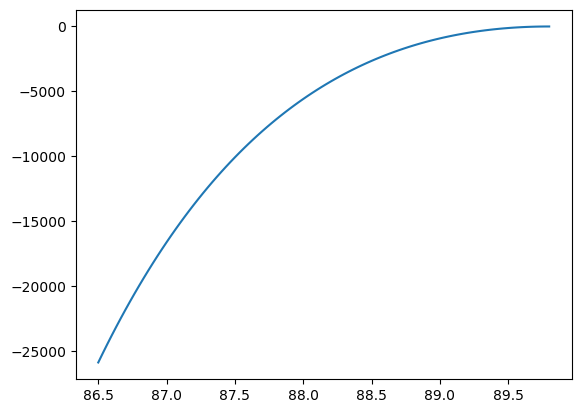

In [1804]:
B = np.linspace(86.5,89.8,100)
Eb_array = Eb(B)
plt.plot(B,-Eb_array)
plt.show()

# <font size=5, color='black'> Zeeman Effect Calculator </font>

In [522]:
# helper functions
def A_hfs(J, I, mj, mi, mjj, mii):
    Ahfs = 0
    if (mj == mjj) and (mi == mii):
        Ahfs = mj*mi
    elif (mj == mjj + 1.0) and (mi == mii - 1.0):
        Ahfs = (1/2)*np.sqrt((J+mj)*(J-mj+1)*(I-mi)*(I+mi+1))
    elif (mj == mjj - 1.0) and (mi == mii + 1.0): 
        Ahfs = (1/2)*np.sqrt((J-mj)*(J+mj+1)*(I+mi)*(I-mi+1))
    else:
        Ahfs = 0
    return Ahfs

def B_hfs(J, I, mj, mi, mjj, mii):
    # reference: N. Ramsey's Molecular Beams... some Appendix, I believe
    Bhfs = 0
    if (mj == mjj) and (mi == mii):
        Bhfs = (1/2)*(3*mi**2-I*(I+1))*(3*mj**2-J*(J+1))
    elif (mjj == mj - 1) and (mii == mi + 1):   
        Bhfs = (3/4)*(2*mjj-1)*(2*mii+1)*np.sqrt((J+mjj)*(J-mjj+1)*(I-mii)*(I+mii+1))
    elif mjj == mj + 1 and mii == mi - 1:
        Bhfs = (3/4)*(2*mjj+1)*(2*mii-1)*np.sqrt((J-mjj)*(J+mjj+1)*(I+mii)*(I-mii+1))
    elif mjj == mj - 2 and mii == mi + 2 :  
        Bhfs = (3/4)*np.sqrt((J+mjj)*(J+mjj-1)*(J-mjj+1)*(J-mjj+2)*(I-mii)*(I-mii-1)*(I+mii+1)*(I+mii+2))
    elif mjj == mj + 2 and mii == mi - 2:
        Bhfs = (3/4)*np.sqrt((J-mjj)*(J-mjj-1)*(J+mjj+1)*(J+mjj+2)*(I+mii)*(I+mii-1)*(I-mii+1)*(I-mii+2))
    else:
        Bhfs = 0

    if (2*I*(2*I-1)*J*(2*J-1)) != 0:
        Bhfs = Bhfs/(2*I*(2*I-1)*J*(2*J-1))
    return Bhfs

def mag(B, J, L, S, mj, mi, mjj, mii, gI):
    gL = 1 - me/mn           # gyro magnetic factor of the orbital
    gS = 2.0023193043622     # electron spin g-factor
    gJ = gL*(J*(J+1)-S*(S+1)+L*(L+1))/(2*J*(J+1)) + gS*(J*(J+1)+S*(S+1)-L*(L+1))/(2*J*(J+1)) # verified, correct :)
    
    mag = 0
    if mj == mjj and mi == mii:
        mag = (muB/hbar)*(gJ*mj + gI*mi)*B*1e-4 # B is in Gauss, need to convert to Tesla
    else:
        mag = 0

    return mag/(2*np.pi) # return answer in Hz

In [718]:
# zeeman splitting calculator
def zeeman_splitting_calculator(J, I, gI, L, S, B_main, B_start, B_end, num_B, Ahf, Bhf = 0, 
                                plotting = True, highlight_HF_states = [0,0], plot_range = None, 
                                single_B_field_calc_mode = False, print_field_sensitivity_between = None,
                                search_mode = False, splitting = 0, splitting_between_states = None, labeling_mode='lf'):

    B_start = min(B_start, B_end)
    B_end = max(B_start, B_end)
    if num_B >= 20:
        B_fields = np.linspace(B_start, B_end, num_B)
        if B_main < max(B_fields) and B_main > min(B_fields):
            B_fields = np.append(B_fields, B_main)
            B_fields = np.sort(B_fields)
        else:
            print('The variable "B_main" is not in B fields!')
            return 0        
    else:
        print('Number of points must exceed 20!')
        return 0
    
    # possible Js
    possible_Js = np.arange(abs(L-S), abs(L+S)+1, 1)
    if J > max(possible_Js) or J < min(possible_Js):
        print('Invalid J!')
        return 0
    mJ = np.linspace(-J, J, int(2*J+1))
    mI = np.linspace(-I, I, int(2*I+1))
   
    # now make a basis:
    basis = [] # which is the set {[mj, mi]}
    for mj in mJ:
        for mi in mI:
            basis.append([mj, mi])
            mF = mj + mi
    size = len(basis)
    H = np.empty((size,size))
    list_of_freqs = [ ]

    # generate the zeeman Hamiltonian and diagonalize it 
    for b in B_fields:
        for r in range(size):
            mj = basis[r][0]
            mi = basis[r][1]
            for c in range(size):
                mjj = basis[c][0]
                mii = basis[c][1]
                H[r,c] = Ahf * A_hfs(J, I, mj, mi, mjj, mii) + Bhf * B_hfs(J, I, mj, mi, mjj, mii) + mag(b, J, L, S, mj, mi, mjj, mii, gI)
        freqs, eigenvectors = np.linalg.eigh(H) 
        freqs = freqs * 1e-6
        list_of_freqs.append(freqs)

    # Plotting, labeling states, and returning statistics:
    list_of_freqs = np.array(list_of_freqs)
    list_of_freqs = np.sort(list_of_freqs, axis=1)    
    highlight_HF_states = np.array(highlight_HF_states)
    if plotting:
        for s in range(size):
            plt.plot(B_fields, list_of_freqs[:,s], linewidth = 0.5, color='red')
        if highlight_HF_states.all() in np.arange(1, size+1,1):
            for state in highlight_HF_states:
                plt.plot(B_fields[np.where((B_fields == B_main))[0][0]:], 
                         list_of_freqs[np.where((B_fields == B_main))[0][0] : , state-1], linewidth = 1.5 , color = 'black')
        if plot_range is not None:
            plt.ylim(plot_range)
        plt.xlabel('Magnetic field (G)')
        plt.ylabel('Energy shift (MHz)')
        # labeling states depending on high or low field:
        gL = 1 - me/mn           # gyro magnetic factor of the orbital
        gS = 2.0023193043622     # electron spin g-factor
        gJ = gL*(J*(J+1)-S*(S+1)+L*(L+1))/(2*J*(J+1)) + gS*(J*(J+1)+S*(S+1)-L*(L+1))/(2*J*(J+1)) # verified, correct :)
        if labeling_mode=='lf':
            # print out (F,mF) basis
            basisF = []
            possible_Fs = np.arange(abs(I-J), abs(I+J)+1, 1)
            if gI > 0:
                possible_Fs = np.flip(possible_Fs)
            for F in possible_Fs:
                gF = gJ*(F*(F+1) - I*(I+1) + J*(J+1))/(2*F*(F+1)) # without dividing a positive
                if gF > 0:
                    # if positive, then mF negative to positive:
                    mF = np.linspace(-F, F, int(2*F+1))
                    for mf in mF:
                        basisF.append([F,mf])
                else:
                    # if negative, then mF positive to negative:
                    mF = np.flip(np.linspace(-F, F, int(2*F+1)))
                    for mf in mF:
                        basisF.append([F,mf])
            basisF = np.array(basisF)
            print('(F, mF) basis, low to high in energy: ')
            print(basisF)
        elif labeling_mode=='hf':
            # rank the mj mi basis based on the value of gJ * mJ + gI*mI:
            vals = []
            for b in basis:
                B_hf = 10*Ahf*hbar*2*np.pi/(muB *1e-4)
                vals.append(  Ahf*b[0]*b[1] + (gJ*b[0] + gI*b[1])*B_hf*1e-4*muB/(hbar*2*np.pi)    )
            sort_vals = np.argsort(np.array(vals))
            sorted_mJmI_basis = np.array(basis)
            sorted_mJmI_basis = sorted_mJmI_basis[sort_vals]
            print('(mJ, mI) basis, low to high in energy: ')
            print(sorted_mJmI_basis)
        elif labeling_mode == 'none':
            print('No state labeling')
        plt.grid()
        plt.show()   

    # Compute relevant statistics:
    if single_B_field_calc_mode:
        print('Frequency spacings (MHz), from low to high in state energy, at ' + str(B_main) +  ' G:')
        freqs = list_of_freqs[np.where(B_fields == B_main)[0][0]]
        for i in range(len(freqs)-1):
            print("{:.4f}".format(freqs[i+1] - freqs[i]))    
        print(' ')    
        # Field sensitivities:
        print('Field sensitivity of shift (MHz per G), from low to high in state energy, at ' + str(B_main) + ' G:')
        freqs_next = list_of_freqs[np.where(B_fields == B_main)[0][0] + 1]
        freqs_diff = freqs_next - freqs
        Bs_diff = B_fields[np.where(B_fields == B_main)[0][0] + 1] - B_fields[np.where(B_fields == B_main)[0][0]]
        for i in range(len(freqs)):
            print("{:.3f}".format(freqs_diff[i] / Bs_diff))  
        print(' ')

        # Next, calculate the difference between in energy between the two states:
        if print_field_sensitivity_between is not None:
            lower_state  = list_of_freqs[ : , print_field_sensitivity_between[0]-1]
            higher_state = list_of_freqs[ : , print_field_sensitivity_between[1]-1]
            differential_shift =  higher_state - lower_state
            # take derivative:
            dfdB = np.diff(differential_shift)/np.diff(B_fields)
            print( 'Field sensitivity of splitting, df'+str(print_field_sensitivity_between[1])+str(print_field_sensitivity_between[0])+' by dB:')   
            print("{:.4f}".format(dfdB[np.where((B_fields == B_main))[0][0]]) + ' MHz per G')

    # Search for B_field that matches splitting:
    if search_mode:
        if splitting_between_states is not None:
            state_A_freqs = list_of_freqs[ : , splitting_between_states[0]-1]
            state_B_freqs = list_of_freqs[ : , splitting_between_states[1]-1]
            AB_freq_differences = np.abs(state_B_freqs - state_A_freqs - splitting) # assuming no weird crossings...
            AB_freq_diff_min_index = np.argmin(AB_freq_differences)

            print(' ')
            print('Closest B field (G): ' + "{:.2f}".format(B_fields[AB_freq_diff_min_index]))
            splitting_error = state_B_freqs[AB_freq_diff_min_index] - state_A_freqs[AB_freq_diff_min_index] - splitting
            print('Splitting Error (MHz): ' + "{:.5f}".format(splitting_error ))
            if np.abs(splitting_error/splitting) >= 0.1: # if error is too big
                print('Note: large error might be due to bad guesses!')
    return 

No state labeling


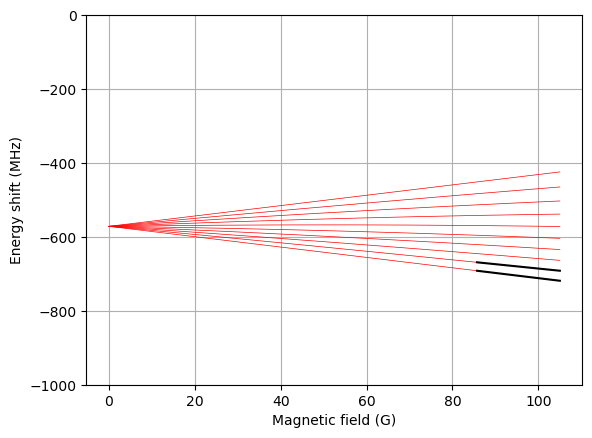

Frequency spacings (MHz), from low to high in state energy, at 85.7 G:
22.8468
23.5735
24.3744
25.2630
26.2565
27.3776
28.6560
30.1323
31.8637
1077.4569
30.0900
28.6136
27.3353
26.2142
25.2206
24.3320
23.5312
 
Field sensitivity of shift (MHz per G), from low to high in state energy, at 85.7 G:
-1.402
-1.175
-0.934
-0.677
-0.402
-0.106
0.216
0.569
0.961
1.402
-0.959
-0.567
-0.215
0.107
0.402
0.676
0.933
1.173
 
Field sensitivity of splitting, df21 by dB:
0.2275 MHz per G
 
Closest B field (G): 85.63
Splitting Error (MHz): -0.00013


In [1799]:
# Zeeman calculator cell
B_start = 0
B_end = 105
B_main = 85.7 # G
num_B = 10000

# Careful what you type in here!
Ahf = K40Ahf_s12
Bhf = K40Bhf_s12
L = 0
S = 1/2
J = 1/2
I = K40I
gI = K40gI

zeeman_splitting_calculator(J, I, gI, L, S, B_main, B_start, B_end, num_B, Ahf, Bhf, 
                            plotting = True, highlight_HF_states = [1,2], plot_range = [-1000,0], 
                            single_B_field_calc_mode = True, print_field_sensitivity_between = [1,2],
                            search_mode = True, splitting = 22.830, splitting_between_states = [1,2],
                            labeling_mode='none')

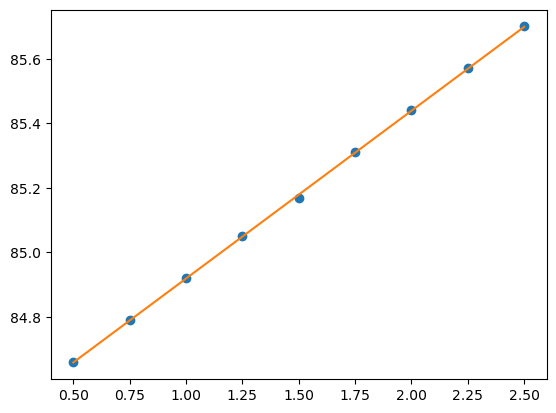

0.519999999999996 84.39888888888888


In [1770]:
SG_set = np.array([2.5,2.25,2.00,1.75,1.50,1.25,1.00,0.75,0.50])
B_true = np.array([85.70,85.57,85.44,85.31,85.17,85.05,84.92,84.79,84.66])
plt.plot(SG_set, B_true, 'o')
a, b = np.polyfit(SG_set, B_true, 1)
plt.plot(SG_set, a*SG_set + b)
plt.show()
print(a,b)

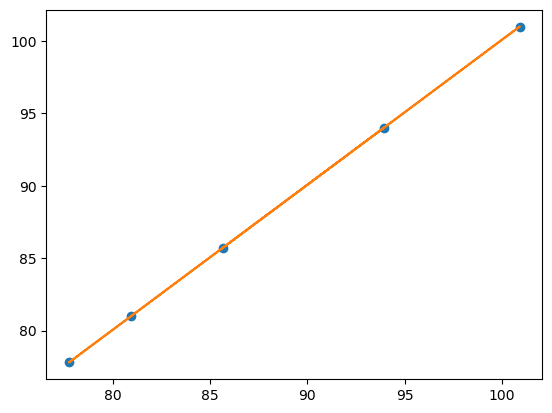

0.9996998058751988 0.10236424881652037


In [1801]:
B_set  = np.array([85.70, 101.00, 81.00, 77.80, 94.00])
B_true = np.array([85.63, 100.93, 80.92, 77.72, 93.92])
plt.plot(B_true, B_set, 'o')
a, b = np.polyfit(B_true, B_set, 1)
plt.plot(B_true, a*B_true + b)
plt.show()
print(a,b)

# <font size=5, color='black'> Landau-Zener transition (linear sweep) </font>

In [229]:
# LZ solver
def LZ_solve(delta0, omegaR, ddelta_dt, psi0, tlist):

    # Hamiltonian
    sx = sigmax()
    sz = sigmaz()
    a = destroy(2)

    H0 = - (delta0/2.0) * sz - (omegaR/2.0) * sx
    H1 = - ddelta_dt/2.0 * sz        

    # collapse operators
    c_op_list = []

    # evolve and calculate expectation values. Method: Cython string-based
    # want to return expectation value of aTa = [[0,0],[0,1]] = P_excited
    H = [H0, [H1, 't']]
    output = mesolve(H, psi0, tlist, c_op_list, [a.dag() * a], {})  

    return output.expect[0]

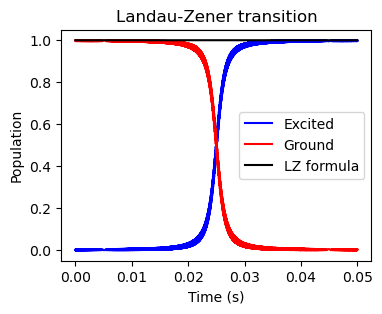

In [1110]:
# calculate
sweep_time   = 50e-3              # sweep time in secs
sweep_span   = 500e3 * 2 * np.pi   # sweep span in Hz * 2pi, make sure this is >> omegaR for good LZ
sweep_center = 0 * 2 * np.pi # sweep center in Hz * 2pi
ddelta_dt    = sweep_span/sweep_time   # sweep rate in Hz/s * 2pi
delta0       = -sweep_span/2   # initial detuning in Hz * 2pi
omegaR       = 16e3 * 2 * np.pi   # Rabi frequency in Hz * 2pi
psi0         = basis(2,0)      # initial state
tlist        = np.linspace(0, sweep_time, 10000)
p_ex         = LZ_solve(delta0, omegaR, ddelta_dt, psi0, tlist)

# display results
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(tlist, np.real(p_ex), 'b', tlist, np.real(1-p_ex), 'r')
ax.plot(tlist, 1 - np.exp(-np.pi * omegaR **2 / (2 * ddelta_dt)) * np.ones(np.shape(tlist)), 'k')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Population')
ax.set_title('Landau-Zener transition')
ax.legend(("Excited", "Ground", "LZ formula"), loc=0)
plt.show()

# <font size=5, color='black'> Rabi Solution for Two-Level System </font>

In [253]:
def _P2_Rabi(omega, tau, omegaR, omega0, offset):    
    OmegaR = np.sqrt( omegaR**2 + (omega - omega0)**2 )
    return ( omegaR**2 / OmegaR**2) * np.sin( 2*np.pi*OmegaR * tau / 2)**2 + offset

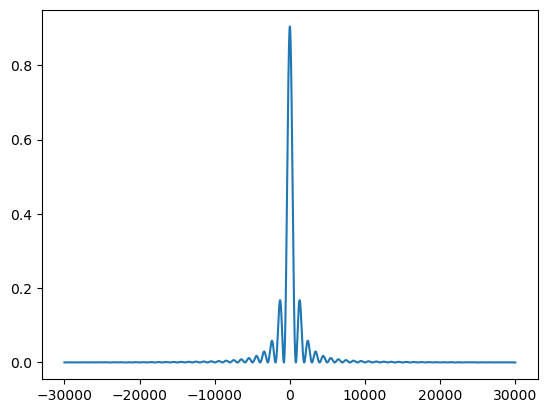

In [1790]:
detunings = np.arange(-30e3,30e3,0.001e3)
omega0 = 26.2370e6
tau = 1000e-6
omegaR = 0.6e3
offset = 0
P2 = _P2_Rabi(detunings+omega0, tau , omegaR, omega0, offset)
plt.plot(detunings, P2)
plt.show()